In [1]:
from scripts.pca_tools import *
from itertools import chain


In [2]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
sns.set_style("whitegrid")

In [3]:
# Functions to Calculate Aromatic Stacking Interactions
from __future__ import print_function, division
from mdtraj.geometry import _geometry
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles


def find_plane_normal(points):

    N = points.shape[0]
    A = np.concatenate((points[:, 0:2], np.ones((N, 1))), axis=1)
    B = points[:, 2]
    out = lstsq(A, B, rcond=-1)
    na_c, nb_c, d_c = out[0]
    if d_c != 0.0:
        cu = 1./d_c
        bu = -nb_c*cu
        au = -na_c*cu
    else:
        cu = 1.0
        bu = -nb_c
        au = -na_c
    normal = np.asarray([au, bu, cu])
    normal /= math.sqrt(dot(normal, normal))
    return normal


def find_plane_normal2(positions):
    # Alternate approach used to check sign - could the sign check cause descrepency with desres?
    # Use Ligand IDs 312, 308 and 309 to check direction
    # [304 305 306 307 308 309 310 311 312 313]
    v1 = positions[0]-positions[1]
    v1 /= np.sqrt(np.sum(v1**2))
    v2 = positions[2]-positions[1]
    v2 /= np.sqrt(np.sum(v2**2))
    normal = np.cross(v1, v2)
    return normal


def find_plane_normal2_assign_atomid(positions, id1, id2, id3):
    # Alternate approach used to check sign - could the sign check cause descrepency with desres?
    v1 = positions[id1]-positions[id2]
    v1 /= np.sqrt(np.sum(v1**2))
    v2 = positions[id3]-positions[id1]
    v2 /= np.sqrt(np.sum(v2**2))
    normal = np.cross(v1, v2)
    return normal


def get_ring_center_normal_assign_atomid(positions, id1, id2, id3):
    center = np.mean(positions, axis=0)
    normal = find_plane_normal(positions)
    normal2 = find_plane_normal2_assign_atomid(positions, id1, id2, id3)
    # check direction of normal using dot product convention
    comp = np.dot(normal, normal2)
    if comp < 0:
        normal = -normal
    return center, normal


def get_ring_center_normal_(positions):
    center = np.mean(positions, axis=0)
    normal = find_plane_normal(positions)
    normal2 = find_plane_normal2(positions)
    # check direction of normal using dot product convention
    comp = np.dot(normal, normal2)
    if comp < 0:
        normal = -normal
    return center, normal


def angle(v1, v2):
    return np.arccos(np.dot(v1, v2)/(np.sqrt(np.dot(v1, v1))*np.sqrt(np.dot(v2, v2))))


def get_ring_center_normal_trj_assign_atomid(position_array, id1, id2, id3):
    length = len(position_array)
    centers = np.zeros((length, 3))
    normals = np.zeros((length, 3))
    centers_normals = np.zeros((length, 2, 3))
    print(np.shape(length), np.shape(centers), np.shape(normals))
    for i in range(0, len(position_array)):
        center, normal = get_ring_center_normal_assign_atomid(
            position_array[i], id1, id2, id3)
        centers_normals[i][0] = center
        centers_normals[i][1] = normal
    return centers_normals

# MDtraj Functions to Calculate Hydrogen Bonds with custom selections of donors and acceptors

def _get_bond_triplets_print(topology, lig_donors, exclude_water=True, sidechain_only=False):
    def can_participate(atom):
        # Filter waters
        if exclude_water and atom.residue.is_water:
            return False
        # Filter non-sidechain atoms
        if sidechain_only and not atom.is_sidechain:
            return False
        # Otherwise, accept it
        return True

    def get_donors(e0, e1):
        # Find all matching bonds
        # print("get_donors e0 e1:",e0,e1)
        elems = set((e0, e1))
        atoms = [(one, two) for one, two in topology.bonds
                 if set((one.element.symbol, two.element.symbol)) == elems]
        # Filter non-participating atoms
        atoms = [atom for atom in atoms
                 if can_participate(atom[0]) and can_participate(atom[1])]
        # Get indices for the remaining atoms
        indices = []
        for a0, a1 in atoms:
            pair = (a0.index, a1.index)
            # make sure to get the pair in the right order, so that the index
            # for e0 comes before e1
            if a0.element.symbol == e1:
                pair = pair[::-1]
            indices.append(pair)

        return indices

    # Check that there are bonds in topology
    nbonds = 0
    for _bond in topology.bonds:
        nbonds += 1
        break  # Only need to find one hit for this check (not robust)
    if nbonds == 0:
        raise ValueError('No bonds found in topology. Try using '
                         'traj._topology.create_standard_bonds() to create bonds '
                         'using our PDB standard bond definitions.')

    nh_donors = get_donors('N', 'H')
    print("nh_donors", nh_donors)
    for i in nh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    oh_donors = get_donors('O', 'H')
    print("oh_donors", oh_donors)
    for i in oh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    sh_donors = get_donors('S', 'H')
    print("sh_donors", sh_donors)
    for i in sh_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    for i in lig_donors:
        print(top.atom(i[0]), top.atom(i[1]))
    # ADD IN ADDITIONAL SPECIFIED LIGAND DONORS
    xh_donors = np.array(nh_donors + oh_donors + sh_donors+lig_donors)

    if len(xh_donors) == 0:
        # if there are no hydrogens or protein in the trajectory, we get
        # no possible pairs and return nothing
        return np.zeros((0, 3), dtype=int)

    acceptor_elements = frozenset(('O', 'N', 'S'))
    acceptors = [a.index for a in topology.atoms
                 if a.element.symbol in acceptor_elements and can_participate(a)]
    print("acceptors")
    for i in acceptors:
        print(top.atom(i))
    # Make acceptors a 2-D numpy array
    acceptors = np.array(acceptors)[:, np.newaxis]

    # Generate the cartesian product of the donors and acceptors
    xh_donors_repeated = np.repeat(xh_donors, acceptors.shape[0], axis=0)
    acceptors_tiled = np.tile(acceptors, (xh_donors.shape[0], 1))
    bond_triplets = np.hstack((xh_donors_repeated, acceptors_tiled))

    # Filter out self-bonds
    self_bond_mask = (bond_triplets[:, 0] == bond_triplets[:, 2])
    return bond_triplets[np.logical_not(self_bond_mask), :]


def _get_bond_triplets(topology, lig_donors, exclude_water=True, sidechain_only=False):
    def can_participate(atom):
        # Filter waters
        if exclude_water and atom.residue.is_water:
            return False
        # Filter non-sidechain atoms
        if sidechain_only and not atom.is_sidechain:
            return False
        # Otherwise, accept it
        return True

    def get_donors(e0, e1):
        # Find all matching bonds
        elems = set((e0, e1))
        atoms = [(one, two) for one, two in topology.bonds
                 if set((one.element.symbol, two.element.symbol)) == elems]
        # Filter non-participating atoms
        atoms = [atom for atom in atoms
                 if can_participate(atom[0]) and can_participate(atom[1])]
        # Get indices for the remaining atoms
        indices = []
        for a0, a1 in atoms:
            pair = (a0.index, a1.index)
            # make sure to get the pair in the right order, so that the index
            # for e0 comes before e1
            if a0.element.symbol == e1:
                pair = pair[::-1]
            indices.append(pair)

        return indices

    # Check that there are bonds in topology
    nbonds = 0
    for _bond in topology.bonds:
        nbonds += 1
        break  # Only need to find one hit for this check (not robust)
    if nbonds == 0:
        raise ValueError('No bonds found in topology. Try using '
                         'traj._topology.create_standard_bonds() to create bonds '
                         'using our PDB standard bond definitions.')

    nh_donors = get_donors('N', 'H')
    oh_donors = get_donors('O', 'H')
    sh_donors = get_donors('S', 'H')
    xh_donors = np.array(nh_donors + oh_donors + sh_donors+lig_donors)

    if len(xh_donors) == 0:
        # if there are no hydrogens or protein in the trajectory, we get
        # no possible pairs and return nothing
        return np.zeros((0, 3), dtype=int)

    acceptor_elements = frozenset(('O', 'N', 'S'))
    acceptors = [a.index for a in topology.atoms
                 if a.element.symbol in acceptor_elements and can_participate(a)]
    # Make acceptors a 2-D numpy array
    acceptors = np.array(acceptors)[:, np.newaxis]

    # Generate the cartesian product of the donors and acceptors
    xh_donors_repeated = np.repeat(xh_donors, acceptors.shape[0], axis=0)
    acceptors_tiled = np.tile(acceptors, (xh_donors.shape[0], 1))
    bond_triplets = np.hstack((xh_donors_repeated, acceptors_tiled))

    # Filter out self-bonds
    self_bond_mask = (bond_triplets[:, 0] == bond_triplets[:, 2])
    return bond_triplets[np.logical_not(self_bond_mask), :]


def _compute_bounded_geometry(traj, triplets, distance_cutoff, distance_indices,
                              angle_indices, freq=0.0, periodic=True):
    """
    Returns a tuple include (1) the mask for triplets that fulfill the distance
    criteria frequently enough, (2) the actual distances calculated, and (3) the
    angles between the triplets specified by angle_indices.
    """
    # First we calculate the requested distances
    distances = md.compute_distances(
        traj, triplets[:, distance_indices], periodic=periodic)

    # Now we discover which triplets meet the distance cutoff often enough
    prevalence = np.mean(distances < distance_cutoff, axis=0)
    mask = prevalence > freq

    # Update data structures to ignore anything that isn't possible anymore
    triplets = triplets.compress(mask, axis=0)
    distances = distances.compress(mask, axis=1)

    # Calculate angles using the law of cosines
    abc_pairs = zip(angle_indices, angle_indices[1:] + angle_indices[:1])
    abc_distances = []

    # Calculate distances (if necessary)
    for abc_pair in abc_pairs:
        if set(abc_pair) == set(distance_indices):
            abc_distances.append(distances)
        else:
            abc_distances.append(md.compute_distances(traj, triplets[:, abc_pair],
                                                      periodic=periodic))

    # Law of cosines calculation
    a, b, c = abc_distances
    cosines = (a ** 2 + b ** 2 - c ** 2) / (2 * a * b)
    np.clip(cosines, -1, 1, out=cosines)  # avoid NaN error
    angles = np.arccos(cosines)
    return mask, distances, angles


def baker_hubbard2(traj, freq=0.1, exclude_water=True, periodic=True, sidechain_only=False,
                   distance_cutoff=0.35, angle_cutoff=150, lig_donor_index=[]):

    angle_cutoff = np.radians(angle_cutoff)

    if traj.topology is None:
        raise ValueError('baker_hubbard requires that traj contain topology '
                         'information')

    # Get the possible donor-hydrogen...acceptor triplets

    # ADD IN LIGAND HBOND DONORS
    add_donors = lig_donor_index

    bond_triplets = _get_bond_triplets(traj.topology,
                                       exclude_water=exclude_water, lig_donors=add_donors, sidechain_only=sidechain_only)

    mask, distances, angles = _compute_bounded_geometry(traj, bond_triplets,
                                                        distance_cutoff, [1, 2], [0, 1, 2], freq=freq, periodic=periodic)

    # Find triplets that meet the criteria
    presence = np.logical_and(
        distances < distance_cutoff, angles > angle_cutoff)
    mask[mask] = np.mean(presence, axis=0) > freq
    return bond_triplets.compress(mask, axis=0)


def print_donors_acceptors(traj, freq=0.1, exclude_water=True, periodic=True, sidechain_only=False,
                           distance_cutoff=0.35, angle_cutoff=150, lig_donor_index=[]):

    angle_cutoff = np.radians(angle_cutoff)

    if traj.topology is None:
        raise ValueError('baker_hubbard requires that traj contain topology '
                         'information')

    # Get the possible donor-hydrogen...acceptor triplets

    # ADD IN LIGAND HBOND DONORS
    # add_donors=[[296,318],[296,331]]
    # Manually tell it where to find proton donors on ligand
    # LIG58-O5 LIG58-H24
    # LIG58-O1 LIG58-H12
    # LIG58-N LIG58-H15
    # add_donors=[[768,796],[750,784],[752,787]]
    add_donors = lig_donor_index

    bond_triplets_print = _get_bond_triplets_print(traj.topology,
                                                   exclude_water=exclude_water, lig_donors=add_donors, sidechain_only=sidechain_only)

    # mask, distances, angles = _compute_bounded_geometry(traj, bond_triplets,
    #    distance_cutoff, [1, 2], [0, 1, 2], freq=freq, periodic=periodic)

    # Find triplets that meet the criteria
    # presence = np.logical_and(distances < distance_cutoff, angles > angle_cutoff)
    # mask[mask] = np.mean(presence, axis=0) > freq
    return


In [4]:
outdir = './outdir_s20g_hiapp_yxa1/'
!mkdir $outdir
pdb = './structure_files/hiapp_s20g_yxa1.gro'
rep0 = "/Users/f006j60/Robustelli_Group/IAPP/s20g_yxa1/pbc_trj_2.82us/pbc_1.xtc"
helixpdb = './structure_files/helix_s20g.pdb'
apodir = './outdir_s20g_hiapp_apo/'


# Define Aromatic Rings in YXA1
ligand_rings = [[560,561,562,563,564,565], [544,545,546,547,548,549], [553,554,555,556,557,558]]
# Definie Hydrogen Bond Donors in YXA1
lig_hbond_donors = [[541,577],[552,583]]

# Simulation Length in microseconds
print("outdir:", outdir)
print("pdb:", pdb)
print("helix pdb:", helixpdb)
print("trjaectory:", rep0)


mkdir: ./outdir_s20g_hiapp_yxa1/: File exists
outdir: ./outdir_s20g_hiapp_yxa1/
pdb: ./structure_files/hiapp_s20g_yxa1.gro
helix pdb: ./structure_files/helix_s20g.pdb
trjaectory: /Users/f006j60/Robustelli_Group/IAPP/s20g_yxa1/pbc_trj_2.82us/pbc_1.xtc


In [5]:
trj = md.load(rep0, top=pdb, stride=1)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames = trj.n_frames
sim_length = trj.time/1000*80/1000
sim_length = sim_length[-1]

In [6]:
nres = []
for res in trj.topology.residues:
    nres.append(res.resSeq)
sequence = (' %s' % [residue for residue in trj.topology.residues])
resname = (' %s' % [residue.name for residue in trj.topology.residues])
resindex = (' %s' % [residue.index for residue in trj.topology.residues])
prot_top = top.subset(top.select('protein'))
prot_res = []
for res in prot_top.residues:
    prot_res.append(res.resSeq)
prot_resname = (' %s' % [residue.name for residue in prot_top.residues])
residues = len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

residues = 38
residue_offset = 1
prot_res_renum = np.asarray(prot_res)
print(prot_res_renum)
residue_number = range(0, residues)
residue_number_offsetres = range(residue_offset, residue_offset+residues)
print("Residue Number Range:", residue_number)


** SYSTEM INFO **

Number of atoms: 593

Number of residues: 39

Number of protein residues: 37

Number of frames: 35251

Starting frame: 0

Last frame: 35251

sequence:  [LYS1, CYS2, ASN3, THR4, ALA5, THR6, CYS7, ALA8, THR9, GLN10, ARG11, LEU12, ALA13, ASN14, PHE15, LEU16, VAL17, HIS18, SER19, GLY20, ASN21, ASN22, PHE23, GLY24, ALA25, ILE26, LEU27, SER28, SER29, THR30, ASN31, VAL32, GLY33, SER34, ASN35, THR36, TYR37, NH238, LIG39]

residue names:  ['LYS', 'CYS', 'ASN', 'THR', 'ALA', 'THR', 'CYS', 'ALA', 'THR', 'GLN', 'ARG', 'LEU', 'ALA', 'ASN', 'PHE', 'LEU', 'VAL', 'HIS', 'SER', 'GLY', 'ASN', 'ASN', 'PHE', 'GLY', 'ALA', 'ILE', 'LEU', 'SER', 'SER', 'THR', 'ASN', 'VAL', 'GLY', 'SER', 'ASN', 'THR', 'TYR', 'NH2', 'LIG']

residue index:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 3

/Users/f006j60/git/hIAPP_monomer_simulations/scripts/pca_tools.py:58: RuntimeWarning: invalid value encountered in divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]


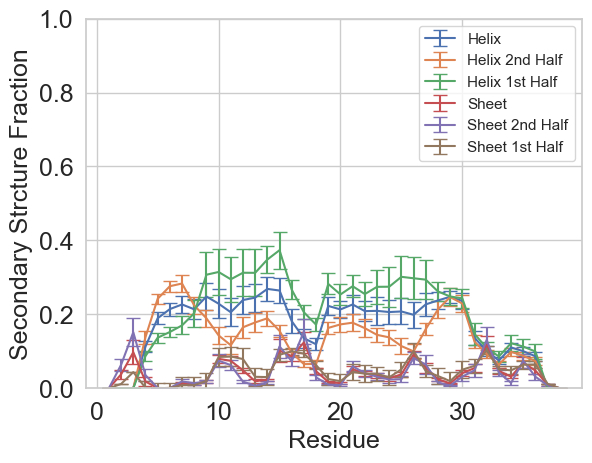

In [79]:
trjH1 = md.load(rep0, top=pdb, stride=1)
H1 = top.select("resid 0 to 37")
trjH1.restrict_atoms(H1)
trjH1.center_coordinates()
frames = trjH1.n_frames
half = int(np.floor(frames/2))

h_res = []
for res in trjH1.topology.residues:
    h_res.append(res.resSeq)
h_residues = len(set(h_res))
hres_renum = np.asarray(h_res)


frames = trj.n_frames
half = int(np.floor(frames/2))

dsspH1 = md.compute_dssp(trjH1, simplified=True)
dsspH1_h2 = md.compute_dssp(trjH1[half:-1], simplified=True)
dsspH1_h1 = md.compute_dssp(trjH1[0:half], simplified=True)

H1_H, H1_E = dssp_convert(dsspH1)
H1_H_h2, H1_E_h2 = dssp_convert(dsspH1_h2)
H1_H_h1, H1_E_h1 = dssp_convert(dsspH1_h1)

plt.errorbar(hres_renum, H1_H[:, 0], yerr=H1_H[:, 1], capsize=5, label='Helix')
plt.errorbar(
    hres_renum, H1_H_h2[:, 0], yerr=H1_H_h2[:, 1], capsize=5, label='Helix 2nd Half')
plt.errorbar(
    hres_renum, H1_H_h1[:, 0], yerr=H1_H_h1[:, 1], capsize=5, label='Helix 1st Half')
plt.errorbar(hres_renum, H1_E[:, 0], yerr=H1_E[:, 1], capsize=5, label='Sheet')
plt.errorbar(
    hres_renum, H1_E_h1[:, 0], yerr=H1_E_h1[:, 1], capsize=5, label='Sheet 2nd Half')
plt.errorbar(
    hres_renum, H1_E_h2[:, 0], yerr=H1_H_h2[:, 1], capsize=5, label='Sheet 1st Half')

plt.ylim(0, 1.0)
plt.legend(loc="upper right")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
np.savetxt(outdir+'Hprop.err.dat',
           np.column_stack((hres_renum, H1_H[:, 0], H1_H[:, 1])))
np.savetxt(outdir+'Eprop.err.dat',
           np.column_stack((hres_renum, H1_E[:, 0], H1_E[:, 1])))


In [80]:
# report helicity 
dsspH = np.copy(dsspH1)
dsspH[dsspH == 'H'] = 1
dsspH[dsspH == 'E'] = 0
dsspH[dsspH == 'C'] = 0
dsspH[dsspH == 'NA'] = 0
dsspH = dsspH.astype(int)
TotalH = np.sum(dsspH, axis=1)
np.save(outdir+"H_total" + ".npy", TotalH)

# report sheet
dsspE = np.copy(dsspH1)
dsspE[dsspE == 'H'] = 0
dsspE[dsspE == 'E'] = 1
dsspE[dsspE == 'C'] = 0
dsspE[dsspE == 'NA'] = 0
dsspE = dsspE.astype(int)
TotalE = np.sum(dsspE, axis=1)
np.save(outdir+"E_total" + ".npy", TotalE)

print("Average Helical Residues:%6.3lf" %
      (np.average(TotalH)), "+_%6.3lf" % ((block(TotalH)**.5)))
print("Average Fraction Helix:%6.3lf" %
      (np.average(TotalH)/37), "+_%6.3lf" % ((block(TotalH)**.5)/37))

print("Average Sheet Residues:%6.3lf" %
      (np.average(TotalE)), "+_%6.3lf" % ((block(TotalH)**.5)))
print("Average Fraction Sheet:%6.3lf" %
      (np.average(TotalE)/37), "+_%6.3lf" % ((block(TotalH)**.5)/37))

Average Helical Residues: 6.343 +_ 0.615
Average Fraction Helix: 0.171 +_ 0.017
Average Sheet Residues: 1.625 +_ 0.615
Average Fraction Sheet: 0.044 +_ 0.017


In [81]:
# Compute Phi and Psi
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
phi_label = []
for i_phi in range(0, indices_phi.shape[0]):
    resindex = trj.topology.atom(indices_phi[i_phi][3]).residue.resSeq
    phi_label.append(resindex)
phi_label = np.array(phi_label)
psi_label = []
for i_psi in range(0, indices_psi.shape[0]):
    resindex = trj.topology.atom(indices_psi[i_psi][3]).residue.resSeq
    psi_label.append(resindex)
psi_label = np.array(psi_label)
phipsi = []
for i in range(0, len(psi_label)-2):
    current_phipsi = np.column_stack((phis[:, i+1], psis[:, i]))
    phipsi.append(current_phipsi)
phipsi_array = np.array(phipsi)


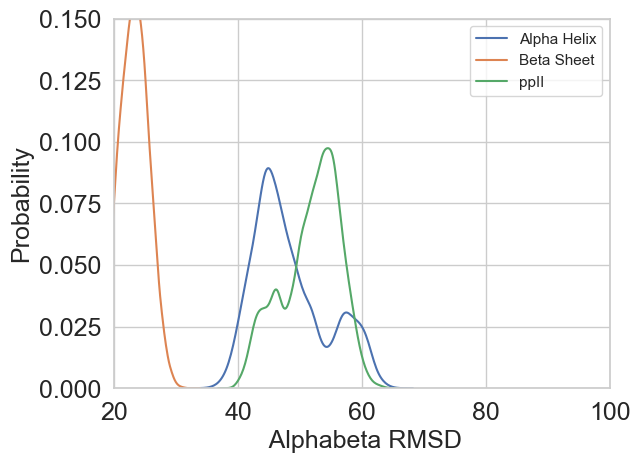

<Figure size 640x480 with 0 Axes>

In [82]:
def alphabeta_rmsd(phi, psi, phi_ref, psi_ref):
    alphabetarmsd = np.sum(0.5*(1+np.cos(psi-psi_ref)),
                           axis=1)+np.sum(0.5*(1+np.cos(phi-phi_ref)), axis=1)
    return alphabetarmsd


Phi_all = phis
Psi_all = psis
alphabeta_alpharight = alphabeta_rmsd(Phi_all, Psi_all, -1.05, -0.79)
alphabeta_betasheet = alphabeta_rmsd(Phi_all, Psi_all, 2.36, -2.36)
alphabeta_ppII = alphabeta_rmsd(Phi_all, Psi_all, -1.31, 2.71)

sns.kdeplot(data=alphabeta_alpharight, label='Alpha Helix')
sns.kdeplot(data=alphabeta_betasheet, label='Beta Sheet')
sns.kdeplot(data=alphabeta_ppII, label='ppII')

plt.xlabel(' Alphabeta RMSD', fontsize=18)
plt.xlim(20, 100)
plt.ylim(0, 0.15)

plt.ylabel('Probability', fontsize=18)
plt.legend(loc='upper right')
plt.tick_params(labelsize=18)

plt.show()
plt.savefig(outdir+'Alphabeta.histogram.png')


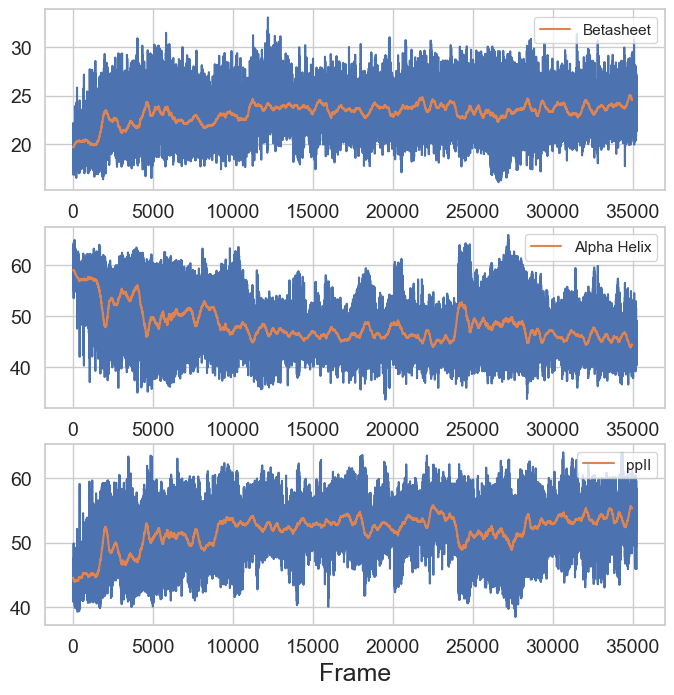

In [83]:
fig, ax = plt.subplots(3, figsize=((8, 8)))
N = 300
ax[0].plot(alphabeta_betasheet)
ax[0].plot(np.convolve(alphabeta_betasheet, np.ones(
    N)/N, mode='valid'), label='Betasheet')
ax[0].legend(loc='upper right')

ax[1].plot(alphabeta_alpharight)
ax[1].plot(np.convolve(alphabeta_alpharight, np.ones(
    N)/N, mode='valid'), label='Alpha Helix')
ax[1].legend(loc='upper right')

ax[2].plot(alphabeta_ppII)
ax[2].plot(np.convolve(alphabeta_ppII, np.ones(
    N)/N, mode='valid'), label='ppII')
ax[2].legend(loc='upper right')

ax[0].tick_params(labelsize=14)
ax[1].tick_params(labelsize=14)
ax[2].tick_params(labelsize=14)

plt.xlabel('Frame', size=18)
plt.savefig(outdir+'Alphabeta.timecourse.png')


CA Radius of Gyration: 1.236 +_ 0.019
1st Half CA Radius of Gyration: 1.172 +_ 0.007
2nd Half CA Radius of Gyration: 1.300 +_ 0.013


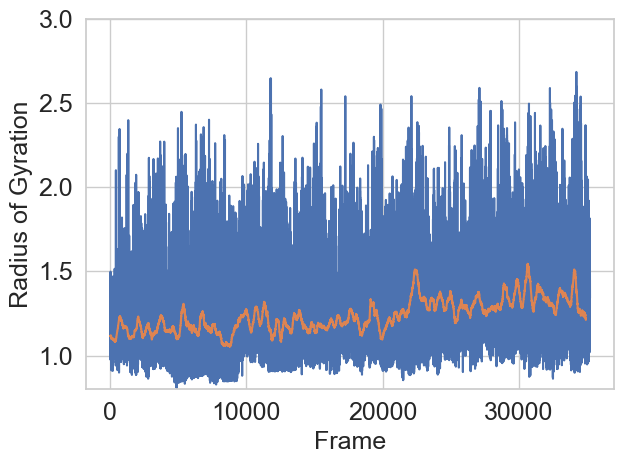

In [84]:
mass = []
for at in trj.topology.atoms:
    mass.append(at.element.mass)
mass_CA = len(mass)*[0.0]
# put the CA entries equal to 1.0
for i in trj.topology.select("name CA"):
    mass_CA[i] = 1.0
# calculate CA radius of gyration
rg_CA = md.compute_rg(trj, masses=np.array(mass_CA))
np.save(outdir+"Rg_total" + ".npy", rg_CA)

# SE_rg=(block(rg_all))**.5
plt.clf()
plt.plot(rg_CA)
plt.plot(np.convolve(rg_CA, np.ones(N)/N, mode='valid'))
plt.xlabel('Frame', size=18)
plt.ylabel('Radius of Gyration', size=18)
plt.ylim(0.8, 3.0)
plt.tick_params(labelsize=18)
plt.tight_layout()
print("CA Radius of Gyration:%6.3lf" %
      np.average(rg_CA), "+_%6.3lf" % block(rg_CA)**.5)
print("1st Half CA Radius of Gyration:%6.3lf" % np.average(
    rg_CA[0:half]), "+_%6.3lf" % block(rg_CA[0:half])**.5)
print("2nd Half CA Radius of Gyration:%6.3lf" % np.average(
    rg_CA[half:-1]), "+_%6.3lf" % block(rg_CA[half:-1])**.5)

plt.savefig(outdir+'rg.pdf')
np.savetxt(outdir+'rg.dat', rg_CA)


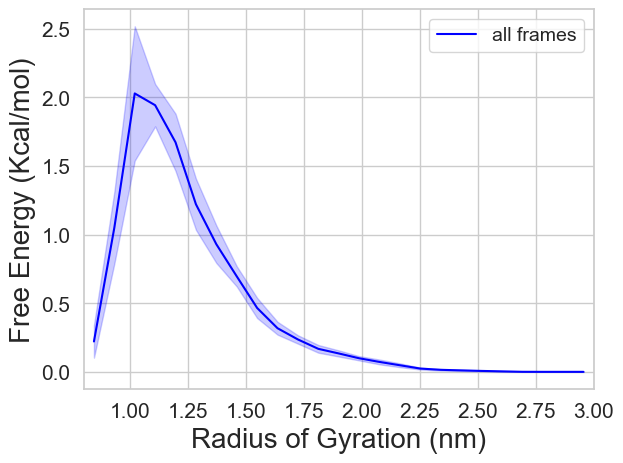

In [85]:
Rg_all, edges, u_err = histo_blockerror(rg_CA, 0.8, 3.0, 25, 5)

plt.plot(edges, Rg_all, c='blue', label='all frames')
plt.fill_between(edges, Rg_all-u_err, Rg_all+u_err, color='blue', alpha=0.2)

plt.xlim(0.8, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()


[0.070 0.342 1.197 0.119 0.217 0.174 0.093 0.027 0.027 0.011 0.005 0.004
 0.003 0.001 0.002 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000]
[0.221 1.051 2.029 1.943 1.672 1.221 0.930 0.696 0.465 0.318 0.236 0.168
 0.134 0.099 0.072 0.048 0.024 0.015 0.011 0.007 0.004 0.000 0.000 0.000
 0.000]


/Users/f006j60/git/hIAPP_monomer_simulations/scripts/pca_tools.py:99: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


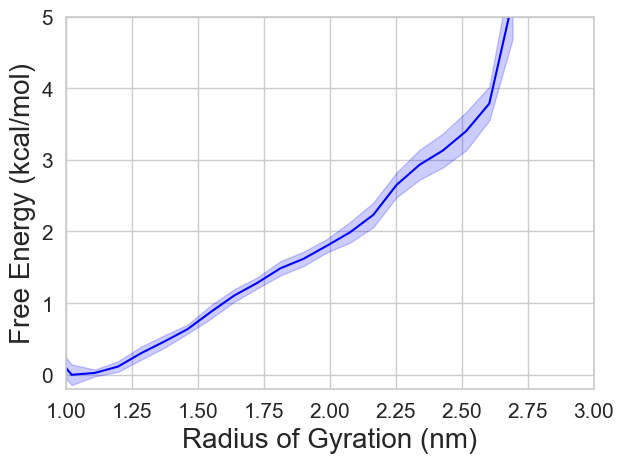

In [86]:
dG, bin_centers, ferr = free_energy_1D_blockerror(rg_CA, 300, 0.8, 3.0, 25, 5)
sns.lineplot(x=bin_centers, y=dG, color='blue')
plt.fill_between(bin_centers, dG-ferr, dG+ferr, color='blue', alpha=0.2)
plt.ylim(-0.2, 5)
plt.xlim(1.0, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
np.savetxt(outdir+'rg.dG.err.dat', np.column_stack((bin_centers, dG, ferr)))
plt.tight_layout()
plt.savefig('%s/Rg.dG.pdf' % outdir)
plt.show()


[0.275 0.511 1.430 0.211 0.042 0.009 0.006 0.012 0.004 0.005 0.003 0.004
 0.002 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000]
[0.427 1.527 2.694 2.195 1.302 0.883 0.647 0.554 0.329 0.232 0.179 0.127
 0.099 0.072 0.041 0.026 0.010 0.008 0.006 0.003 0.004 0.000 0.000 0.000
 0.000]
[0.000 0.093 0.845 0.139 0.353 0.125 0.058 0.025 0.024 0.012 0.004 0.002
 0.003 0.002 0.001 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000]
[0.015 0.574 1.364 1.691 2.043 1.560 1.213 0.838 0.602 0.404 0.293 0.208
 0.169 0.126 0.104 0.070 0.038 0.021 0.015 0.011 0.003 0.001 0.000 0.000
 0.000]


/Users/f006j60/git/hIAPP_monomer_simulations/scripts/pca_tools.py:99: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


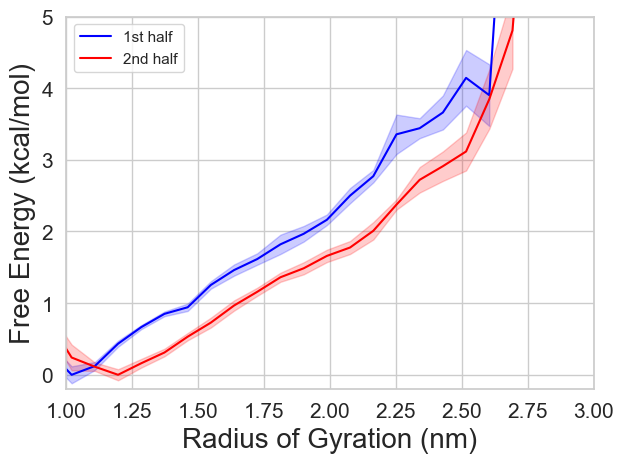

In [87]:
# [0:half],[half:-1]
dG1, bin_centers, ferr1 = free_energy_1D_blockerror(
    rg_CA[0:half], 300, 0.8, 3.0, 25, 5)
dG2, bin_centers, ferr2 = free_energy_1D_blockerror(
    rg_CA[half:-1], 300, 0.8, 3.0, 25, 5)
sns.lineplot(x=bin_centers, y=dG1, color='blue', label='1st half')
sns.lineplot(x=bin_centers, y=dG2, color='red', label='2nd half')

plt.fill_between(bin_centers, dG1-ferr1, dG1+ferr1, color='blue', alpha=0.2)
plt.fill_between(bin_centers, dG2-ferr2, dG2+ferr2, color='red', alpha=0.2)

plt.ylim(-0.2, 5)
plt.xlim(1.0, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.legend()
plt.tight_layout()
plt.tight_layout()
plt.savefig('%s/Rg.dG.splithalfs.pdf' % outdir)
plt.show()


Number of residues: 39

Sα: 3.005 +_ 0.416


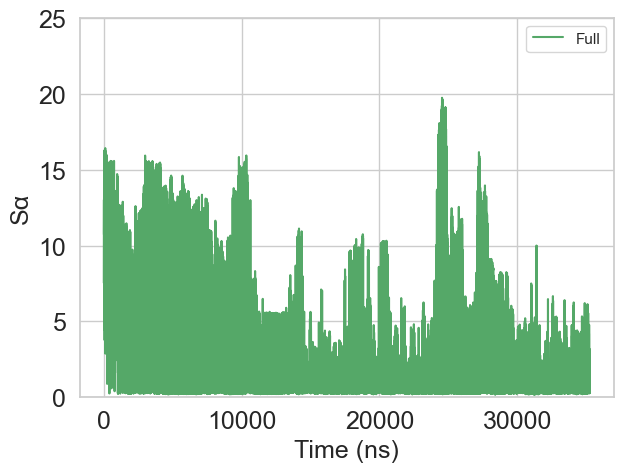

In [88]:
helix = md.load_pdb(helixpdb)
helix
top_helix = helix.topology
backbone_helix = top_helix.select("name CA")
backbone = top.select("name CA")

sel1 = top_helix.select("name CA and resid 0 to 37")

print("Number of residues: %d\n" % len(set(nres)))
RMS_start = 1
RMS_stop = 31
RMS = []
for i in range(RMS_start, RMS_stop):
    sel = top_helix.select("residue %s to %s and backbone" % (i, i+6))
    rmsd = md.rmsd(trj, helix, atom_indices=sel)
    RMS.append(rmsd)
RMS = np.asarray(RMS)
RMS

Sa_sum = np.zeros((trj.n_frames))
Sa = (1.0-(RMS/0.10)**8)/(1-(RMS/0.10)**12)
Sa_ave = np.average(Sa, axis=1)
Sa_total = np.sum(Sa, axis=0)
np.save(outdir+"Sa_total" + ".npy", Sa_total)


print("Sα:%6.3lf" % np.average(Sa_total),
      "+_%6.3lf" % block(Sa_total)**.5)

N = 300
plt.plot(Sa_total, label='Full', c='g')
plt.legend()
plt.xlabel('Time (ns)', size=18)
plt.ylabel('Sα', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0, 25)
plt.savefig(outdir+'Sa.timecourse.png')
np.savetxt(outdir+'Sa_total.dat', Sa_total)


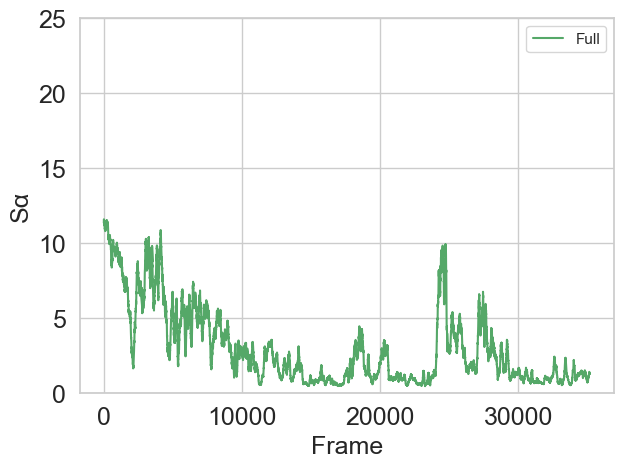

In [89]:
N = 100
plt.plot(np.convolve(Sa_total, np.ones(N)/N, mode='valid'), label='Full', c='g')
plt.legend()
plt.xlabel('Frame', size=18)
plt.ylabel('Sα', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.ylim(0, 25)
plt.savefig(outdir+'Sa.timecourse.smooth.png')


**All Frames- Not Partitioned into Bound and Unbound**
[0.021 0.001 0.001 0.000 0.000 0.001 0.000 0.000 0.000 0.001 0.003 0.002
 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000]
[0.557 0.095 0.054 0.028 0.027 0.042 0.018 0.025 0.023 0.021 0.035 0.028
 0.018 0.008 0.006 0.007 0.002 0.002 0.002 0.001 0.000 0.000 0.000 0.000
 0.000]


/Users/f006j60/git/hIAPP_monomer_simulations/scripts/pca_tools.py:99: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


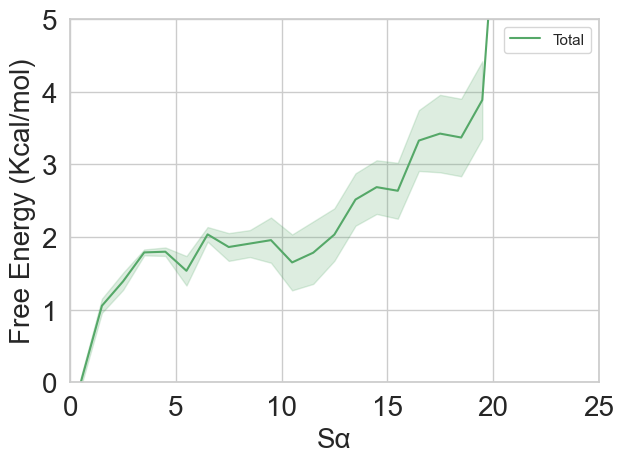

In [90]:
print("**All Frames- Not Partitioned into Bound and Unbound**")
Sa_dg, edges, Sa_err = free_energy_1D_blockerror(Sa_total, 300, 0, 25, 25, 5)


plt.clf()
plt.plot(edges, Sa_dg, c='g', label='Total')
plt.fill_between(edges, Sa_dg-Sa_err, Sa_dg+Sa_err, color='g', alpha=0.2)


plt.legend()

plt.ylim(0, 5)
plt.xlim(0, 25)
plt.xlabel('Sα', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='20')
plt.yticks(size='20')
plt.tight_layout()
np.savetxt(outdir+'Sa_dg.dat', np.column_stack((edges, Sa_dg, Sa_err)))
plt.savefig('%s/Sa.dG.png' % outdir)

In [91]:
# calculate the contacts without the last residue
contact_maps = []
contact_distances = []
for i in range(0, residues):
    contact_map = []
    contact_distance = []
    for j in range(0, residues):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.8, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


In [92]:
# no ligand in this seq 
seq = []
div = 2 
for n,i in enumerate(trj.topology.residues): 
    if n%div == 0: 
        seq.append(str(i))
    else: 
        seq.append("")
seq = seq[:-1] 

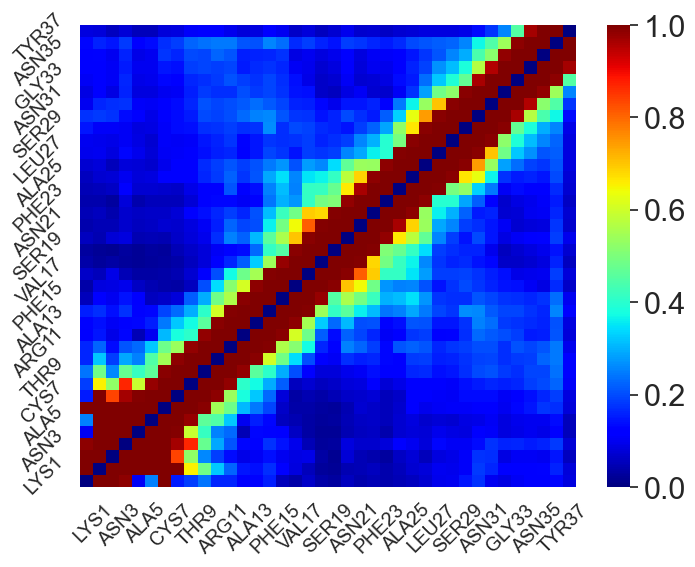

In [93]:
# the last residue is NH2 
contact_map = final_map
sequence = seq

# Make distance map
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
im = sns.heatmap(contact_map, cmap='jet', ax=ax)
ax.grid(which='both', alpha=0.5)
plt.xticks(residue_number_offsetres, sequence, rotation=45, size=14)
plt.yticks(residue_number_offsetres, sequence, rotation=45, size=14)
cbar = im.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)
ax.invert_yaxis()


np.savetxt(outdir+'contactmap.dat', final_map)
plt.savefig(outdir+'contact_map.png')
plt.savefig(outdir+'contact_map.pdf')
plt.show()


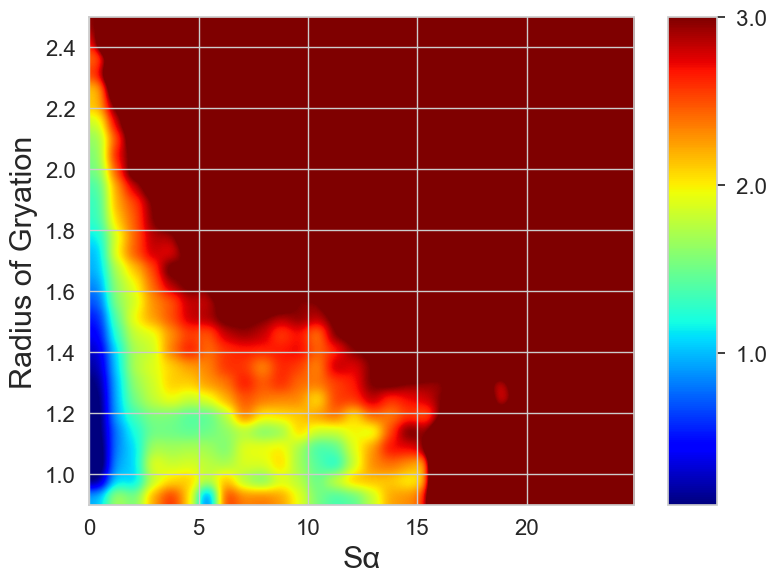

In [94]:
a, xedges, yedges = np.histogram2d(
    rg_CA, Sa_total, 30, [[0.9, 2.5], [0, 25.0]], normed=True, weights=None)
a = np.log(np.flipud(a)+.000001)
T = 300
a = -(0.001987*T)*a

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(a, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5]
plt.xlim(0, 24.9)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()

plt.ylabel("Radius of Gryation", size=22, labelpad=5)
plt.xlabel("Sα", size=22, labelpad=5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(size='16')
plt.yticks(size='16')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='16')


plt.tight_layout()
np.savetxt(outdir+'Rg_v_Sa.dG.allframes.dat', a)
plt.savefig(outdir+'Rg_v_Sa.dG.allframes.pdf')


In [95]:
# Select Ligand Residues
ligand = top.select("residue 39")
# Select Protein Residues
protein = top.select("residue 1 to 38")

ligand_atomid = []
for atom in ligand:
    indices = []
    indices.append(atom)
    indices.append(top.atom(atom))
    ligand_atomid.append(indices)


protein_atomid = []
for atom in protein:
    indices = []
    indices.append(atom)
    indices.append(top.atom(atom))
    protein_atomid.append(indices)

print(ligand_atomid)
print(protein_atomid)


[[533, LIG39-C], [534, LIG39-C1], [535, LIG39-C2], [536, LIG39-C3], [537, LIG39-C4], [538, LIG39-C5], [539, LIG39-C6], [540, LIG39-O], [541, LIG39-N], [542, LIG39-C7], [543, LIG39-C8], [544, LIG39-C9], [545, LIG39-N1], [546, LIG39-C10], [547, LIG39-N2], [548, LIG39-C11], [549, LIG39-C12], [550, LIG39-C13], [551, LIG39-O1], [552, LIG39-N3], [553, LIG39-C14], [554, LIG39-C15], [555, LIG39-C16], [556, LIG39-C17], [557, LIG39-C18], [558, LIG39-C19], [559, LIG39-F], [560, LIG39-C20], [561, LIG39-C21], [562, LIG39-C22], [563, LIG39-C23], [564, LIG39-C24], [565, LIG39-C25], [566, LIG39-H], [567, LIG39-H1], [568, LIG39-H2], [569, LIG39-H3], [570, LIG39-H4], [571, LIG39-H5], [572, LIG39-H6], [573, LIG39-H7], [574, LIG39-H8], [575, LIG39-H9], [576, LIG39-H10], [577, LIG39-H11], [578, LIG39-H12], [579, LIG39-H13], [580, LIG39-H14], [581, LIG39-H15], [582, LIG39-H16], [583, LIG39-H17], [584, LIG39-H18], [585, LIG39-H19], [586, LIG39-H20], [587, LIG39-H21], [588, LIG39-H22], [589, LIG39-H23], [590,

Fraction Bound: 0.6279254489234348


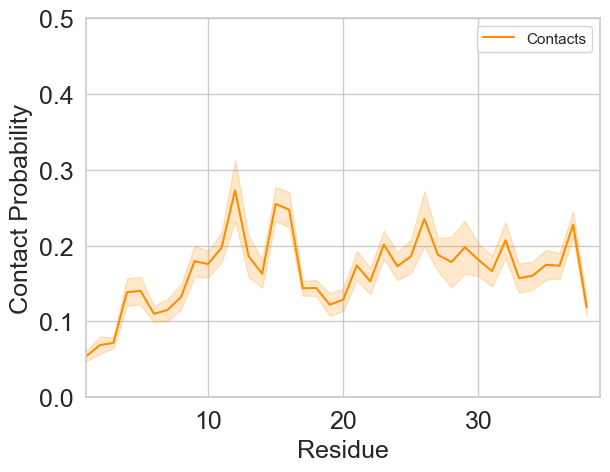

<Figure size 640x480 with 0 Axes>

In [96]:
# Calculate Contact Probabilities between each protein residue and the ligand
#residue_number = range(residue_offset, residue_offset+residues)
residues=38
contact_pairs = np.zeros((residues, 2))
ligand_residue_index = 38

for i in range(0, residues):
    contact_pairs[i] = [i, ligand_residue_index]
contact = md.compute_contacts(trj, contact_pairs, scheme='closest-heavy')
contacts = np.asarray(contact[0]).astype(float)
cutoff = 0.6
contact_matrix = np.where(contacts < cutoff, 1, 0)
contact_prob = np.sum(contact_matrix, axis=0)/trj.n_frames
np.savetxt(outdir+'contacts.traj.dat', contact_matrix, '%i')


contact_rows = np.sum(contact_matrix, axis=1)
contact_frames = np.where(contact_rows > 0)[0]
nocontact_frames = np.where(contact_rows == 0)[0]
contact_fraction = np.sum(np.where(contact_rows > 0, 1, 0))/len(contact_rows)
print("Fraction Bound:", contact_fraction)

# Total Contacts with errors
contact_ave, contact_pyb_be = get_blockerrors_pyblock(contact_matrix, 1.0)
contact_ave, contact_pyb_be_max = get_blockerrors_pyblock(contact_matrix, 1.0)

contact_be = np.column_stack((range(1,ligand_residue_index+1), contact_ave, contact_pyb_be))
contact_be_max = np.column_stack((range(1,ligand_residue_index+1), contact_ave, contact_pyb_be_max))

np.savetxt('%s/contact.be.pyblock.dat' % outdir, contact_be, '%.4f')
np.savetxt('%s/contact.be.pyblock.max.dat' % outdir, contact_be_max, '%.4f')
sns.set(style='whitegrid')

Contact = contact_be
sns.lineplot(x=Contact[:, 0], y=Contact[:, 1],
             color='darkorange', label='Contacts')
plt.fill_between(Contact[:, 0], Contact[:, 1]+Contact[:, 2],
                 Contact[:, 1]-Contact[:, 2], color='darkorange', alpha=0.2)

plt.xlabel('Residue', size=18)
plt.ylabel('Contact Probability', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues) # off by one because no ligand 
plt.tight_layout()
plt.savefig(outdir+'ContactFraction.byResidue.ClosestHeavy.png')
plt.ylim(0, 0.5)
plt.show()
plt.clf()

In [97]:
Box_L = trj.unitcell_lengths[0][0]
# Convert nM to meters for Box_V in M^3
Box_V = (Box_L*10**-9)**3
# Convert Box_V to L
Box_V_L = Box_V*1000
#Concentraion in Mols/L
Concentration = 1/(Box_V_L*(6.023*10**23))
print("L:", Box_L, "V:", Box_V, "Conc:", Concentration)

contact_binary = np.where(contact_rows > 0, 1, 0)
boundfrac, boundfrac_be = get_blockerror_pyblock(contact_binary)
print("Bound Fraction:", boundfrac, "+_", boundfrac_be)
upper = boundfrac+boundfrac_be
KD = Kd_calc(boundfrac, Concentration)
KD_upper = Kd_calc(upper, Concentration)
KD_error = KD-KD_upper
print("KD (mM):", KD*1000, "+_", KD_error*1000)


L: 6.4290004 V: 2.6572373841676223e-25 Conc: 0.006248226766973391
Bound Fraction: 0.6279254489234348 +_ 0.02366374746857825
KD (mM): 3.7023601660548 +_ 0.3613752002813286


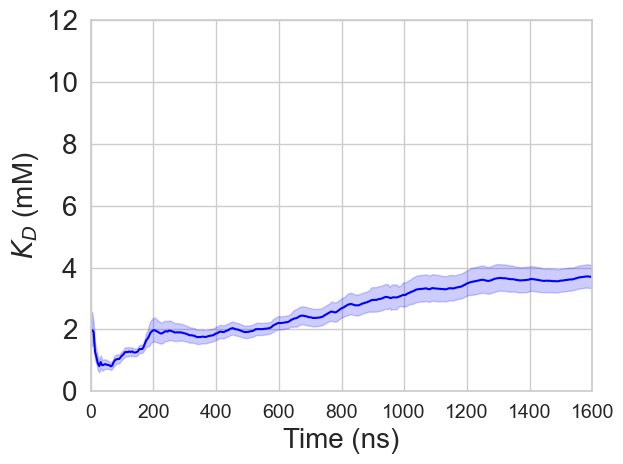

In [98]:
# Time Series of KD Calculations
time = np.linspace(0, 1600, len(contact_binary))
boundfrac_by_frame = []
t2 = []
err_by_frame = []
err_upper = []
err_lower = []
stride = 100

for i in range(stride, len(contact_binary), stride):
    Data = np.asarray(contact_binary[0:i])
    bf, be = get_blockerror_pyblock_nanskip(Data)
    boundfrac_by_frame.append(bf)
    err_by_frame.append(be)
    err_upper.append(bf-be)
    err_lower.append(bf+be)
    t2.append(time[i])

Kd = Kd_calc(np.asarray(boundfrac_by_frame), Concentration)*1000
Kd_upper = Kd_calc(np.asarray(err_upper), Concentration)*1000
Kd_lower = Kd_calc(np.asarray(err_lower), Concentration)*1000
np.savetxt('%s/KD.timecourse.errors.dat' %
           (outdir), np.column_stack((t2, Kd, Kd_upper, Kd_lower)), '%.4f')

# KD_upper=err_upper
plt.plot(t2, Kd, color='blue')
plt.fill_between(t2, Kd_upper, Kd_lower, color='blue', alpha=0.2)

plt.yticks(fontsize=20)
plt.xticks(fontsize=14)
plt.xlabel('Time (ns)', fontsize=20)
plt.ylabel('$K_D$ (mM)', fontsize=20)
plt.grid(True)
plt.ylim(0, 12.0)
plt.xlim(0, 1600)
plt.tight_layout()
plt.savefig(outdir+'KD.bytime.blockerrors.pdf', bbox_inches='tight')


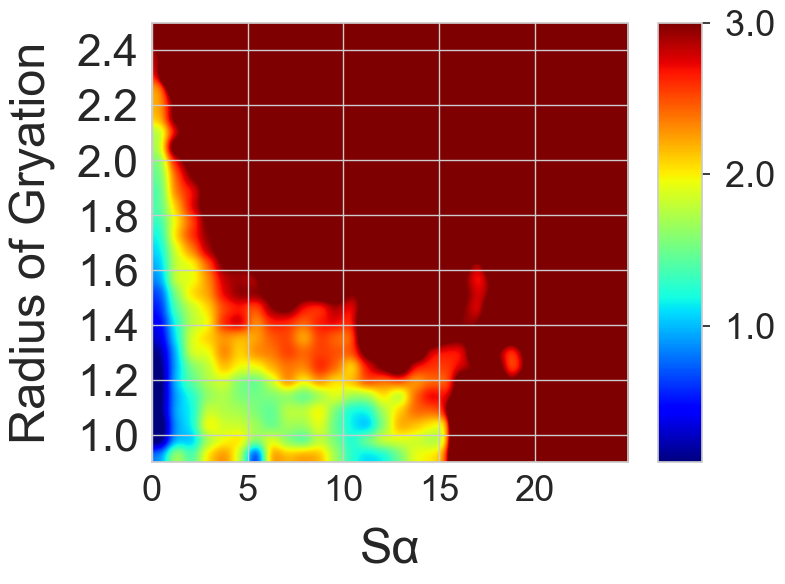

In [99]:
a, xedges, yedges = np.histogram2d(rg_CA[contact_frames], Sa_total[contact_frames], 30, [
                                   [0.9, 2.5], [0, 25.0]], normed=True, weights=None)
a = np.log(np.flipud(a)+.000001)
T = 300
a = -(0.001987*T)*a

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(a, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.xlim(0, 24.9)
plt.ylabel("Radius of Gryation", size=35, labelpad=15)
plt.xlabel("Sα", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')


plt.tight_layout()
np.savetxt(outdir+'Rg_v_Sa.ligand_contacts.dG.dat', a)
plt.savefig(outdir+'Rg_v_Sa.dG.ligand_contacts.pdf')


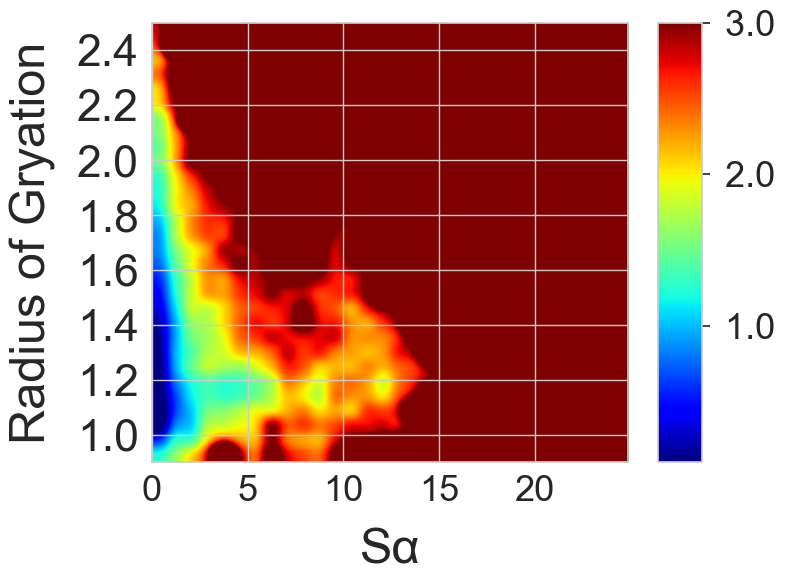

In [100]:
# unbound 

a, xedges, yedges = np.histogram2d(rg_CA[nocontact_frames], Sa_total[nocontact_frames], 30, [
                                   [0.9, 2.5], [0, 25.0]], normed=True, weights=None)
a = np.log(np.flipud(a)+.000001)
T = 300
a = -(0.001987*T)*a

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(a, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.xlim(0, 24.9)

plt.ylabel("Radius of Gryation", size=35, labelpad=15)
plt.xlabel("Sα", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')


plt.tight_layout()
np.savetxt(outdir+'Rg_v_Sa.unbound.dG.dat', a)
plt.savefig(outdir+'Rg_v_Sa.dG.unbound.pdf')


Bound Average Helical Res: 7.154 +_ 1.058
Bound Averagr Fraction Helix: 0.128 +_ 0.029
Unbound Average Helical Res: 4.974 +_ 0.496
Unbound Averagr Fraction Helix: 0.131 +_ 0.013
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


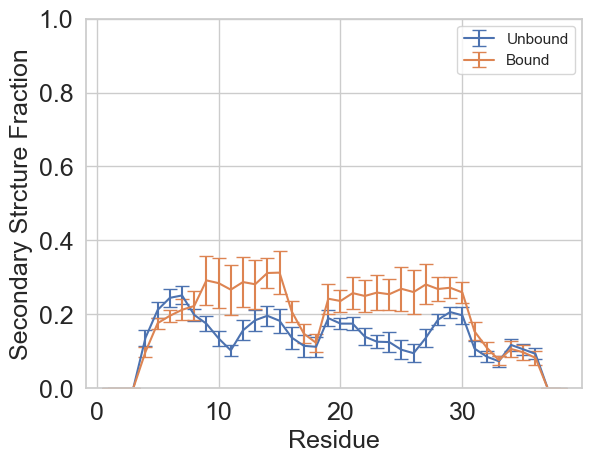

In [101]:
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
    array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock


dssp_bound = dsspH1[contact_frames]
dssp_unbound = dsspH1[nocontact_frames]
H1_H_bound, H1_E_bound = dssp_convert(dssp_bound)
H1_H_unbound, H1_E_unbound = dssp_convert(dssp_unbound)

plt.errorbar(hres_renum, H1_H_unbound[:, 0],
             yerr=H1_H_unbound[:, 1], capsize=5, label='Unbound')
plt.errorbar(hres_renum, H1_H_bound[:, 0],
             yerr=H1_H_bound[:, 1], capsize=5, label='Bound')


plt.ylim(0, 1.0)
plt.legend(loc="upper right")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
np.savetxt(outdir+'Hprop.bound.err.dat',
           np.column_stack((hres_renum, H1_H_bound[:, 0], H1_H_bound[:, 1])))
np.savetxt(outdir+'Eprop.bound.err.dat',
           np.column_stack((hres_renum, H1_E_bound[:, 0], H1_E_bound[:, 1])))

np.savetxt(outdir+'Hprop.unbound.err.dat',
           np.column_stack((hres_renum, H1_H_unbound[:, 0], H1_H_unbound[:, 1])))
np.savetxt(outdir+'Eprop.unbound.derr.dat',
           np.column_stack((hres_renum, H1_E_unbound[:, 0], H1_E_unbound[:, 1])))
plt.savefig(outdir+'Hprop.bound.v.unbound.pdf')


dsspH = np.copy(dssp_bound)
dsspH[dsspH == 'H'] = 1
dsspH[dsspH == 'E'] = 0
dsspH[dsspH == 'C'] = 0
dsspH[dsspH == 'NA'] = 0
dsspH = dsspH.astype(int)
TotalH = np.sum(dsspH, axis=1)
np.shape(dsspH1)
TotalH
print("Bound Average Helical Res:%6.3lf" %
      (np.average(TotalH)), "+_%6.3lf" % ((block(TotalH)**.5)))
print("Bound Averagr Fraction Helix:%6.3lf" %
      (np.average(TotalH)/56.0), "+_%6.3lf" % ((block(TotalH)**.5)/37.0))


dsspH = np.copy(dssp_unbound)
dsspH[dsspH == 'H'] = 1
dsspH[dsspH == 'E'] = 0
dsspH[dsspH == 'C'] = 0
dsspH[dsspH == 'NA'] = 0
dsspH = dsspH.astype(int)
TotalH = np.sum(dsspH, axis=1)
np.shape(dsspH1)
TotalH
print("Unbound Average Helical Res:%6.3lf" %
      (np.average(TotalH)), "+_%6.3lf" % ((block(TotalH)**.5)))
print("Unbound Averagr Fraction Helix:%6.3lf" %
      (np.average(TotalH)/residues), "+_%6.3lf" % ((block(TotalH)**.5)/37.0))
print((hres_renum))


Bound Sα: 3.643 +_ 0.723
Unbound Sα: 1.927 +_ 0.302
[0.027 0.002 0.001 0.000 0.000 0.003 0.000 0.001 0.001 0.001 0.004 0.002
 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000]
[0.514 0.078 0.053 0.023 0.024 0.052 0.023 0.032 0.027 0.026 0.046 0.039
 0.023 0.011 0.009 0.010 0.003 0.003 0.003 0.001 0.000 0.000 0.000 0.000
 0.000]
[0.008 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000]
[0.630 0.124 0.056 0.036 0.034 0.026 0.011 0.012 0.016 0.013 0.016 0.009
 0.011 0.004 0.001 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000]


/Users/f006j60/git/hIAPP_monomer_simulations/scripts/pca_tools.py:99: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


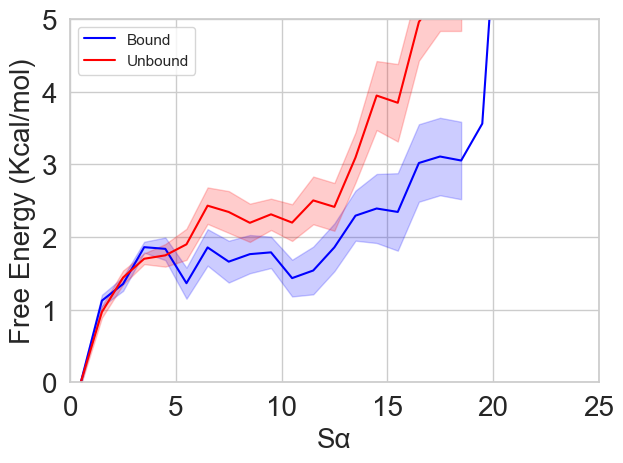

In [102]:
print("Bound Sα:%6.3lf" % np.average(
    Sa_total[contact_frames]), "+_%6.3lf" % block(Sa_total[contact_frames])**.5)
print("Unbound Sα:%6.3lf" % np.average(
    Sa_total[nocontact_frames]), "+_%6.3lf" % block(Sa_total[nocontact_frames])**.5)
np.savetxt(outdir + 'Sa.bf.dat', Sa_total[contact_frames])

dG1, bin_centers, ferr = free_energy_1D_blockerror(
    Sa_total[contact_frames], 300, 0, 25, 25, 5)
dG2, bin_centers, ferr = free_energy_1D_blockerror(
    Sa_total[nocontact_frames], 300, 0, 25, 25, 5)
sns.lineplot(x=bin_centers, y=dG1, color='blue', label="Bound")
sns.lineplot(x=bin_centers, y=dG2, color='red', label="Unbound")
plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color='blue', alpha=0.2)
plt.fill_between(bin_centers, dG2-ferr, dG2+ferr, color='red', alpha=0.2)

plt.ylim(0, 5)
plt.xlim(0, 25)
plt.xlabel('Sα', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='20')
plt.yticks(size='20')
plt.tight_layout()
plt.show()


[0.027 0.002 0.001 0.000 0.000 0.003 0.000 0.001 0.001 0.001 0.004 0.002
 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000]
[0.514 0.078 0.053 0.023 0.024 0.052 0.023 0.032 0.027 0.026 0.046 0.039
 0.023 0.011 0.009 0.010 0.003 0.003 0.003 0.001 0.000 0.000 0.000 0.000
 0.000]
[0.008 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000]
[0.630 0.124 0.056 0.036 0.034 0.026 0.011 0.012 0.016 0.013 0.016 0.009
 0.011 0.004 0.001 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000]


/Users/f006j60/git/hIAPP_monomer_simulations/scripts/pca_tools.py:99: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


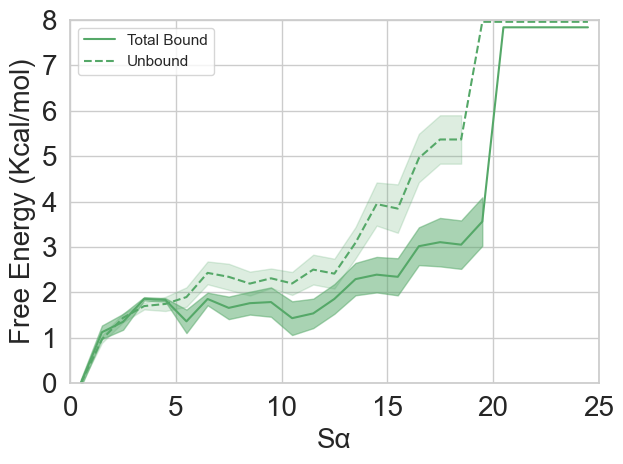

In [103]:
Sa_dg_b, edges, Sa_b_err = free_energy_1D_blockerror(
    Sa_total[contact_frames], 300, 0, 25, 25, 5)

Sa_dg_u, edges, Sa_u_err = free_energy_1D_blockerror(
    Sa_total[nocontact_frames], 300, 0, 25, 25, 5)

plt.plot(edges, Sa_dg_b, c='g', label='Total Bound')

plt.fill_between(edges, Sa_dg_b-Sa_b_err, Sa_dg_b +
                 Sa_b_err, color='g', alpha=0.5)

plt.plot(edges, Sa_dg_u, c='g', linestyle='dashed', label='Unbound')

plt.fill_between(edges, Sa_dg_u-Sa_u_err, Sa_dg_u +
                 Sa_u_err, color='g', alpha=0.2)

plt.legend()

plt.ylim(0, 8)
plt.xlim(0, 25)
plt.xlabel('Sα', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='20')
plt.yticks(size='20')
plt.tight_layout()
plt.savefig('%s/Sa.dG.compare_bound.png' % outdir)

np.savetxt(outdir+'Sa.bound.dG.dat',
           np.column_stack((edges, Sa_dg_b, Sa_b_err)))

np.savetxt(outdir+'Sa.unbound.dG.dat',
           np.column_stack((edges, Sa_dg_u, Sa_u_err)))


Bound Rg: 1.197008706419969 +_ 0.014
Unbound Rg: 1.301585515712434 +_ 0.012
[0.000 0.052 0.724 0.251 0.431 0.084 0.046 0.011 0.016 0.007 0.004 0.006
 0.003 0.000 0.001 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000]
[0.005 0.325 1.573 2.131 1.792 1.341 1.163 0.872 0.628 0.411 0.341 0.236
 0.186 0.114 0.093 0.070 0.030 0.025 0.014 0.012 0.002 0.000 0.000 0.000
 0.000]
[0.252 0.368 1.327 0.349 0.210 0.216 0.125 0.043 0.028 0.012 0.005 0.003
 0.003 0.002 0.002 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000]
[0.350 1.481 2.299 1.832 1.602 1.150 0.792 0.591 0.369 0.263 0.174 0.127
 0.103 0.090 0.060 0.035 0.020 0.009 0.009 0.004 0.005 0.001 0.000 0.000
 0.000]


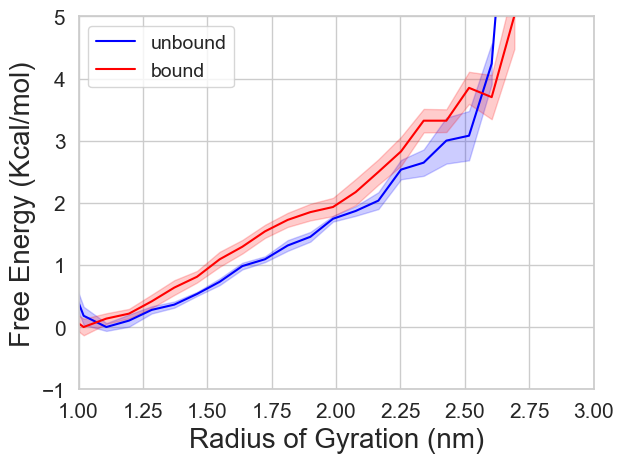

In [104]:
print("Bound Rg:", np.average(rg_CA[contact_frames]),
      "+_%6.3lf" % block(rg_CA[contact_frames])**.5)
print("Unbound Rg:", np.average(
    rg_CA[nocontact_frames]), "+_%6.3lf" % block(rg_CA[nocontact_frames])**.5)
np.savetxt(outdir + 'rg.bf.dat', rg_CA[contact_frames])

Rg_dG_unbound, edges, u_err = free_energy_1D_blockerror(
    rg_CA[nocontact_frames], 300, 0.8, 3.0, 25, 5)
Rg_dG_bound, edges, b_err = free_energy_1D_blockerror(
    rg_CA[contact_frames], 300, 0.8, 3.0, 25, 5)

plt.clf()
plt.plot(edges, Rg_dG_unbound, c='blue', label='unbound')
plt.plot(edges, Rg_dG_bound, c='red', label='bound')
plt.fill_between(edges, Rg_dG_unbound-u_err, Rg_dG_unbound +
                 u_err, color='blue', alpha=0.2)
plt.fill_between(edges, Rg_dG_bound-b_err, Rg_dG_bound +
                 b_err, color='red', alpha=0.2)

plt.ylim(-1, 5)
plt.xlim(1.0, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.legend(loc='upper left', fontsize=14)

plt.tight_layout()
np.savetxt('%s/Rg.dG.bound.dat' %
           outdir, np.column_stack((edges, Rg_dG_bound, b_err)))
np.savetxt('%s/Rg.dG.unbound.dat' %
           outdir, np.column_stack((edges, Rg_dG_unbound, u_err)))
plt.savefig('%s/Rg.dG.compare.pdf' % outdir)
plt.show()

Bound Rg: 1.197008706419969 +_ 0.014
Unbound Rg: 1.301585515712434 +_ 0.012
Unbound Rg: 1.247396867271178 +_ 0.014
[0.000 0.052 0.724 0.251 0.431 0.084 0.046 0.011 0.016 0.007 0.004 0.006
 0.003 0.000 0.001 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000]
[0.005 0.325 1.573 2.131 1.792 1.341 1.163 0.872 0.628 0.411 0.341 0.236
 0.186 0.114 0.093 0.070 0.030 0.025 0.014 0.012 0.002 0.000 0.000 0.000
 0.000]
[0.252 0.368 1.327 0.349 0.210 0.216 0.125 0.043 0.028 0.012 0.005 0.003
 0.003 0.002 0.002 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000]
[0.350 1.481 2.299 1.832 1.602 1.150 0.792 0.591 0.369 0.263 0.174 0.127
 0.103 0.090 0.060 0.035 0.020 0.009 0.009 0.004 0.005 0.001 0.000 0.000
 0.000]
[0.007 0.248 0.774 0.102 0.420 0.138 0.117 0.093 0.028 0.016 0.006 0.001
 0.002 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000]
[0.101 1.102 1.878 1.659 1.752 1.474 1.068 0.731 0.464 0.343 0.216 0.166
 0.121 0.107 0.065 0.048 0.033 0.023 0.006

/Users/f006j60/git/hIAPP_monomer_simulations/scripts/pca_tools.py:99: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


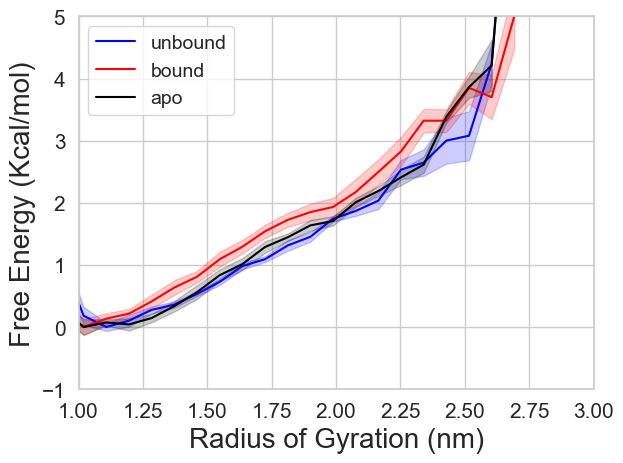

In [105]:
rg_apo = np.loadtxt(apodir+'rg.dat')

print("Bound Rg:", np.average(rg_CA[contact_frames]),
      "+_%6.3lf" % block(rg_CA[contact_frames])**.5)
print("Unbound Rg:", np.average(
    rg_CA[nocontact_frames]), "+_%6.3lf" % block(rg_CA[nocontact_frames])**.5)
print("Unbound Rg:", np.average(rg_apo), "+_%6.3lf" % block(rg_apo)**.5)

Rg_dG_unbound, edges, u_err = free_energy_1D_blockerror(
    rg_CA[nocontact_frames], 300, 0.8, 3.0, 25, 5)
Rg_dG_bound, edges, b_err = free_energy_1D_blockerror(
    rg_CA[contact_frames], 300, 0.8, 3.0, 25, 5)
Rg_dG_apo, edges, a_err = free_energy_1D_blockerror(
    rg_apo, 300, 0.8, 3.0, 25, 5)

plt.clf()
plt.plot(edges, Rg_dG_unbound, c='blue', label='unbound')
plt.plot(edges, Rg_dG_bound, c='red', label='bound')
plt.plot(edges, Rg_dG_apo, c='black', label='apo')

plt.fill_between(edges, Rg_dG_unbound-u_err, Rg_dG_unbound +
                 u_err, color='blue', alpha=0.2)
plt.fill_between(edges, Rg_dG_bound-b_err, Rg_dG_bound +
                 b_err, color='red', alpha=0.2)
plt.fill_between(edges, Rg_dG_apo-a_err, Rg_dG_apo +
                 a_err, color='black', alpha=0.2)

plt.ylim(-1, 5)
plt.xlim(1.0, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.legend(loc='upper left', fontsize=14)

plt.tight_layout()
plt.savefig(outdir+'Rg.dG.compare.wapo.pdf')
plt.show()


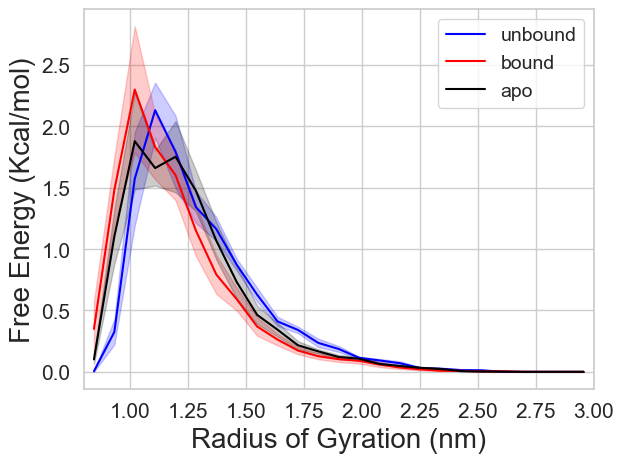

In [106]:
Rg_unbound, edges, u_err = histo_blockerror(
    rg_CA[nocontact_frames], 0.8, 3.0, 25, 5)
Rg_bound, edges, b_err = histo_blockerror(
    rg_CA[contact_frames], 0.8, 3.0, 25, 5)
Rg_apo, edges, a_err = histo_blockerror(rg_apo, 0.8, 3.0, 25, 5)

plt.plot(edges, Rg_unbound, c='blue', label='unbound')
plt.plot(edges, Rg_bound, c='red', label='bound')
plt.plot(edges, Rg_apo, c='black', label='apo')

plt.fill_between(edges, Rg_unbound-u_err, Rg_unbound +
                 u_err, color='blue', alpha=0.2)
plt.fill_between(edges, Rg_bound-b_err, Rg_bound+b_err, color='red', alpha=0.2)
plt.fill_between(edges, Rg_apo-a_err, Rg_apo+a_err, color='black', alpha=0.2)

#plt.ylim(0, 1)
plt.xlim(0.8, 3.0)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()


In [107]:
# add in contact_index 
contact_index = []
for i in range(len(contact_binary)):
    if contact_binary[i] == 1:
        contact_index.append(i)

In [108]:
def calc_err(contact_binary, name):
    boundfrac_by_frame = []
    t2 = []
    err_by_frame = []
    err_upper = []
    err_lower = []
    time = np.linspace(0, sim_length/len(Sa_total)*len(contact_binary), len(contact_binary))
    srtide = 100
    for i in range(stride, len(contact_binary), stride):
        Data = np.asarray(contact_binary[0:i])
        bf, be = get_blockerror_pyblock_nanskip(Data)
        boundfrac_by_frame.append(bf)
        err_by_frame.append(be)
        err_upper.append(bf-be)
        err_lower.append(bf+be)
        t2.append(time[i])
    np.savetxt(outdir + name, np.column_stack((t2, boundfrac_by_frame, err_upper, err_lower)), '%.4f')

calc_err(rg_CA, 'rg.be.dat')
calc_err(Sa_total, 'Sa.be.dat')
calc_err(rg_CA[contact_index], 'rg.bf.be.dat')
calc_err(Sa_total[contact_index], 'Sa.bf.be.dat')


In [109]:
# Calculate Hydrophobic contacts
ligand_hphob = top.select("residue 39 and element C")
protein_hphob = top.select("residue 1 to 38 and element C")


ligand_hphob_atoms = []
for atom in ligand_hphob:
    ligand_hphob_atoms.append(top.atom(atom))

protein_hphob_atoms = []
for atom in protein_hphob:
    protein_hphob_atoms.append(top.atom(atom))

print(ligand_hphob)
print(ligand_hphob_atoms)


def add_contact_pair(pairs, a1, a2, a1_id, a2_id, prot_res, contact_prob):
    if prot_res not in pairs:
        pairs[prot_res] = {}
    if a2 not in pairs[prot_res]:
        pairs[prot_res][a2] = {}
    if a1_id not in pairs[prot_res][a2]:
        pairs[prot_res][a2][a1_id] = contact_prob


hphob_pairs = []
for i in ligand_hphob:
    for j in protein_hphob:
        hphob_pairs.append([i, j])


contact = md.compute_distances(trj, hphob_pairs)
contacts = np.asarray(contact).astype(float)
cutoff = 0.4
contact_frames = np.where(contacts < cutoff, 1, 0)
contact_prob_hphob = np.sum(contact_frames, axis=0)/trj.n_frames


# Hphob Contacts at Atom Pair Resolution
hphob_pair_names = {}
for i in range(0, len(hphob_pairs)):
    a1_id = hphob_pairs[i][0]
    a2_id = hphob_pairs[i][1]
    a1 = top.atom(hphob_pairs[i][0])
    a2 = top.atom(hphob_pairs[i][1])
    prot_res = top.atom(hphob_pairs[i][1]).residue.resSeq
    add_contact_pair(hphob_pair_names, a1, a2, a1_id,
                     a2_id, prot_res, contact_prob_hphob[i])

#residue_number = range(residue_offset, residue_offset+residues)
hphob_max_contacts = {}

# Print Most Populated Contact For Each Aliphatic Carbon in the protein
for i in residue_number:
    if i in hphob_pair_names.keys():
        maxi = 0
        for j in hphob_pair_names[i]:
            max_contact_j = max(
                hphob_pair_names[i][j], key=hphob_pair_names[i][j].get)
            max_contact_fraction = hphob_pair_names[i][j][max_contact_j]
            if max_contact_fraction > maxi:
                max_key_j = j
                max_j_subkey = max_contact_j
                maxi = max_contact_fraction
        hphob_max_contacts[i] = [max_key_j, max_j_subkey, top.atom(
            max_j_subkey), hphob_pair_names[i][max_key_j][max_j_subkey]]


[533 534 535 536 537 538 539 542 543 544 546 548 549 550 553 554 555 556
 557 558 560 561 562 563 564 565]
[LIG39-C, LIG39-C1, LIG39-C2, LIG39-C3, LIG39-C4, LIG39-C5, LIG39-C6, LIG39-C7, LIG39-C8, LIG39-C9, LIG39-C10, LIG39-C11, LIG39-C12, LIG39-C13, LIG39-C14, LIG39-C15, LIG39-C16, LIG39-C17, LIG39-C18, LIG39-C19, LIG39-C20, LIG39-C21, LIG39-C22, LIG39-C23, LIG39-C24, LIG39-C25]


1 38


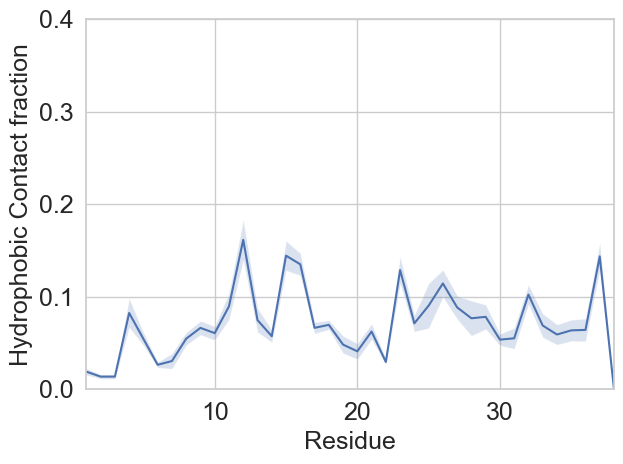

<Figure size 640x480 with 0 Axes>

In [110]:
residues = 38
hydrophob_renum = np.arange(1,residues+1)
# Cast hydrophobic contacts as per residue in each frame
Hphob_res_contacts = np.zeros((n_frames, residues)) # offset because no ligand or NH2
for frame in range(n_frames):
    if np.sum(contact_frames[frame]) > 0:
        contact_pairs = np.where(contact_frames[frame] == 1)
        for j in contact_pairs[0]:
            residue = top.atom(hphob_pairs[j][1]).residue.resSeq
            # the 37th index, or NH2 does not have carbons, so leave out 
            # if residue == 37: 
            #     continue
            # else:
            Hphob_res_contacts[frame][residue-1] = 1


np.savetxt(outdir+'hphob_contacts.traj.dat', Hphob_res_contacts, '%i')
hphob_ave, hphob_pyb_be = get_blockerrors_pyblock(Hphob_res_contacts, 1.0)
hphob_by_res = np.column_stack(
    (hydrophob_renum, hphob_ave, hphob_pyb_be))
np.savetxt(outdir+'hphob_contacts.be.dat', hphob_by_res)

plt.plot(hydrophob_renum, hphob_by_res[:, 1])
plt.fill_between(hydrophob_renum,
                 hphob_by_res[:, 1]+hphob_by_res[:, 2], hphob_by_res[:, 1]-hphob_by_res[:, 2], alpha=0.2)

plt.xlabel('Residue', size=18)
plt.ylabel('Hydrophobic Contact fraction', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
print(residue_offset,residues)
plt.ylim(0, 0.4)
plt.tight_layout()
plt.savefig(outdir+"HydrophobicContactFraction.LigandCarbon.ProteinCarbon.pdf")
plt.show()
plt.clf()


hphob_by_res_boundfraction = np.column_stack(
    (hydrophob_renum, hphob_by_res[:, 1]/boundfrac, hphob_by_res[:, 2]/boundfrac))
np.savetxt(outdir+'hphob_contacts.BF.dat', hphob_by_res, fmt='%.4f')
plt.plot(hphob_by_res_boundfraction[:, 0], hphob_by_res_boundfraction[:, 1])
plt.fill_between(hphob_by_res_boundfraction[:, 0], hphob_by_res_boundfraction[:, 1] +
                 hphob_by_res_boundfraction[:, 2], hphob_by_res_boundfraction[:, 1]-hphob_by_res_boundfraction[:, 2], alpha=0.2)
plt.xlabel('Residue', size=18)
plt.ylabel('Hydrophobic Contact fraction', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues)
plt.xticks(np.arange(0,38,5))
plt.ylim(0, 0.4)
plt.tight_layout()
plt.savefig(outdir+"HydrophobicContacts.BoundFraction.pdf")
plt.clf()

In [111]:
n_rings = len(ligand_rings)
print("Ligand Aromatics Rings:", n_rings)

ligand_ring_params = []
for i in range(0, n_rings):
    ring = np.array(ligand_rings[i])
    print(ring)
    positions = trj.xyz[:, ring, :]
    print(ligand_rings[i][0], ligand_rings[i][1], ligand_rings[i][2])
    ligand_centers_normals = get_ring_center_normal_trj_assign_atomid(
        positions, 0, 1, 2)
    ligand_ring_params.append(ligand_centers_normals)

prot_rings = []
aro_residues = []
prot_ring_name = []
prot_ring_index = []

aro_select = top.select("resname TYR PHE HIS TRP and name CA")
for i in aro_select:
    atom = top.atom(i)
    resname = atom.residue.name
    print(atom.index, atom.name, atom.residue.name,
          atom.residue, atom.residue.index)
    if resname == "TYR":
        ring = top.select(
            "resid %s and name CG CD1 CD2 CE1 CE2 CZ" % atom.residue.index)
        print(atom.residue, ring)
    if resname == "TRP":
        ring = top.select(
            "resid %s and name CG CD1 NE1 CE2 CD2 CZ2 CE3 CZ3 CH2" % atom.residue.index)
        print(atom.residue, ring)
    if resname == "HIS":
        ring = top.select("resid %s and name CG ND1 CE1 NE2 CD2" %
                          atom.residue.index)
        print(atom.residue, ring)
    if resname == "PHE":
        ring = top.select(
            "resid %s and name CG CD1 CD2 CE1 CE2 CZ" % atom.residue.index)
        print(atom.residue, ring)
    prot_rings.append(ring)
    prot_ring_name.append(atom.residue)
    prot_ring_index.append(atom.residue.index)


print("Protein Aromatics Rings:", len(prot_rings), prot_ring_name)

prot_ring_params = []
for i in range(0, len(prot_rings)):
    ring = np.array(prot_rings[i])
    positions = trj.xyz[:, ring, :]
    ring_centers_normals = get_ring_center_normal_trj_assign_atomid(
        positions, 0, 1, 2)
    prot_ring_params.append(ring_centers_normals)

Ligand Aromatics Rings: 3
[560 561 562 563 564 565]
560 561 562
() (35251, 3) (35251, 3)
[544 545 546 547 548 549]
544 545 546
() (35251, 3) (35251, 3)
[553 554 555 556 557 558]
553 554 555
() (35251, 3) (35251, 3)
206 CA PHE PHE15 14
PHE15 [211 212 214 216 218 220]
261 CA HIS HIS18 17
HIS18 [266 267 268 270 272]
324 CA PHE PHE23 22
PHE23 [329 330 332 334 336 338]
511 CA TYR TYR37 36
TYR37 [516 517 519 521 524 526]
Protein Aromatics Rings: 4 [PHE15, HIS18, PHE23, TYR37]
() (35251, 3) (35251, 3)
() (35251, 3) (35251, 3)
() (35251, 3) (35251, 3)
() (35251, 3) (35251, 3)


In [112]:
frames = n_frames
sidechains = len(prot_rings)
ligrings = len(ligand_rings)
print(frames, sidechains)
Ringstacked_old = {}
Ringstacked = {}
Quadrants = {}
Stackparams = {}
Aro_Contacts = {}
Pstack = {}
Tstack = {}


def normvector_connect(point1, point2):
    vec = point1-point2
    vec = vec/np.sqrt(np.dot(vec, vec))
    return vec


def angle(v1, v2):
    return np.arccos(np.dot(v1, v2)/(np.sqrt(np.dot(v1, v1))*np.sqrt(np.dot(v2, v2))))


for l in range(0, ligrings):
    name = "Lig_ring.%s" % l
    print(name)
    Stackparams[name] = {}
    Pstack[name] = {}
    Tstack[name] = {}
    Aro_Contacts[name] = {}
    alphas = np.zeros(shape=(frames, sidechains))
    betas = np.zeros(shape=(frames, sidechains))
    dists = np.zeros(shape=(frames, sidechains))
    thetas = np.zeros(shape=(frames, sidechains))
    phis = np.zeros(shape=(frames, sidechains))
    pstacked_old = np.zeros(shape=(frames, sidechains))
    pstacked = np.zeros(shape=(frames, sidechains))
    tstacked = np.zeros(shape=(frames, sidechains))
    stacked = np.zeros(shape=(frames, sidechains))
    aro_contacts = np.zeros(shape=(frames, sidechains))

    for i in range(0, frames):
        ligcenter = ligand_ring_params[l][i][0]
        lignormal = ligand_ring_params[l][i][1]
        for j in range(0, sidechains):
            protcenter = prot_ring_params[j][i][0]
            protnormal = prot_ring_params[j][i][1]
            dists[i, j] = np.linalg.norm(ligcenter-protcenter)
            connect = normvector_connect(protcenter, ligcenter)
            # alpha is the same as phi in gervasio/Procacci definition
            alphas[i, j] = np.rad2deg(angle(connect, protnormal))
            betas[i, j] = np.rad2deg(angle(connect, lignormal))
            theta = np.rad2deg(angle(protnormal, lignormal))
            thetas[i, j] = np.abs(theta)-2*(np.abs(theta)
                                            > 90.0)*(np.abs(theta)-90.0)
            phi = np.rad2deg(angle(protnormal, connect))
            phis[i, j] = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)

    for j in range(0, sidechains):
        name2 = prot_ring_index[j]
        res2 = prot_ring_name[j]
        print(name2, res2)
        Ringstack = np.column_stack(
            (dists[:, j], alphas[:, j], betas[:, j], thetas[:, j], phis[:, j]))
        stack_distance_cutoff = 0.65
        r = np.where(dists[:, j] <= stack_distance_cutoff)[0]
        aro_contacts[:, j][r] = 1

        # New Definitions
        # p-stack: r < 6.5 Å, θ < 60° and ϕ < 60°.
        # t-stack: r < 7.5 Å, 75° < θ < 90° and ϕ < 60°.
        p_stack_distance_cutoff = 0.65
        t_stack_distance_cutoff = 0.75
        r_pstrict = np.where(dists[:, j] <= p_stack_distance_cutoff)[0]
        r_tstrict = np.where(dists[:, j] <= t_stack_distance_cutoff)[0]

        e = np.where(thetas[:, j] <= 45)
        f = np.where(phis[:, j] <= 60)
        g = np.where(thetas[:, j] >= 75)

        pnew = np.intersect1d(np.intersect1d(e, f), r_pstrict)
        tnew = np.intersect1d(np.intersect1d(g, f), r_tstrict)
        pstacked[:, j][pnew] = 1
        tstacked[:, j][tnew] = 1
        stacked[:, j][pnew] = 1
        stacked[:, j][tnew] = 1
        total_stacked = len(pnew)+len(tnew)
        print("Contacts:", len(r), "Total:", total_stacked,
              "P-stack:", len(pnew), "T-stack:", len(tnew))
        Stackparams[name][name2] = Ringstack
    Pstack[name] = pstacked
    Tstack[name] = tstacked
    Aro_Contacts[name] = aro_contacts
    Ringstacked[name] = stacked


35251 4
Lig_ring.0
14 PHE15
Contacts: 2664 Total: 1156 P-stack: 917 T-stack: 239
17 HIS18
Contacts: 1254 Total: 576 P-stack: 405 T-stack: 171
22 PHE23
Contacts: 1983 Total: 838 P-stack: 645 T-stack: 193
36 TYR37
Contacts: 2805 Total: 1577 P-stack: 1279 T-stack: 298
Lig_ring.1
14 PHE15
Contacts: 2259 Total: 1566 P-stack: 1335 T-stack: 231
17 HIS18
Contacts: 1106 Total: 602 P-stack: 438 T-stack: 164
22 PHE23
Contacts: 2025 Total: 1306 P-stack: 1112 T-stack: 194
36 TYR37
Contacts: 2922 Total: 1926 P-stack: 1659 T-stack: 267
Lig_ring.2
14 PHE15
Contacts: 1674 Total: 688 P-stack: 334 T-stack: 354
17 HIS18
Contacts: 988 Total: 378 P-stack: 224 T-stack: 154
22 PHE23
Contacts: 1876 Total: 896 P-stack: 615 T-stack: 281
36 TYR37
Contacts: 1746 Total: 778 P-stack: 526 T-stack: 252


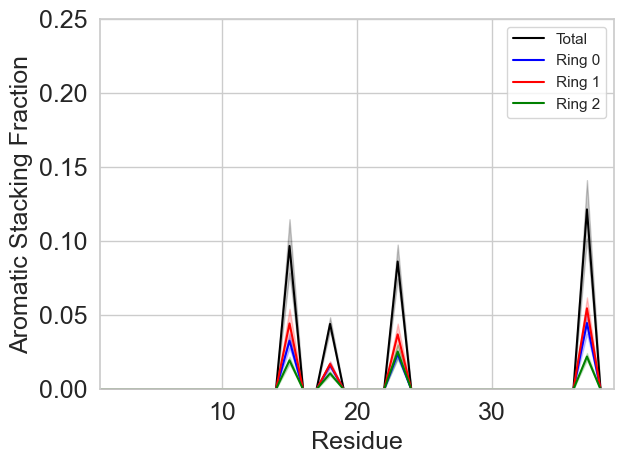

<Figure size 640x480 with 0 Axes>

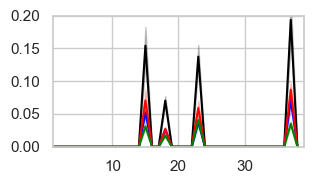

In [113]:
residue_number = range(residue_offset , residues + residue_offset) # not including ligand 
aro_res_index = np.array(prot_ring_index)

aromatic_stacking_contacts_r0 = np.zeros((n_frames, residues))
aromatic_stacking_contacts_r1 = np.zeros((n_frames, residues))
aromatic_stacking_contacts_r2 = np.zeros((n_frames, residues))
aromatic_stacking_contacts = np.zeros((n_frames, residues))

aromatic_contacts_r0 = np.zeros((n_frames, residues))
aromatic_contacts_r1 = np.zeros((n_frames, residues))
aromatic_contacts_r2 = np.zeros((n_frames, residues))
aromatic_contacts = np.zeros((n_frames, residues))

# print(aro_res_index)

for i in range(0, len(aro_res_index)):
    aromatic_stacking_contacts_r0[:, aro_res_index[i]
                                  ] = Ringstacked['Lig_ring.0'][:, i]
    aromatic_contacts_r0[:, aro_res_index[i]
                         ] = Aro_Contacts['Lig_ring.0'][:, i]

    aromatic_stacking_contacts_r1[:, aro_res_index[i]
                                  ] = Ringstacked['Lig_ring.1'][:, i]
    aromatic_contacts_r1[:, aro_res_index[i]
                         ] = Aro_Contacts['Lig_ring.1'][:, i]
    
    aromatic_stacking_contacts_r2[:, aro_res_index[i]
                                  ] = Ringstacked['Lig_ring.2'][:, i]
    aromatic_contacts_r2[:, aro_res_index[i]
                         ] = Aro_Contacts['Lig_ring.2'][:, i]

    aromatic_stacking_contacts[:, aro_res_index[i]
                               ] += Ringstacked['Lig_ring.0'][:, i]
    aromatic_stacking_contacts[:, aro_res_index[i]
                               ] += Ringstacked['Lig_ring.1'][:, i]
    aromatic_stacking_contacts[:, aro_res_index[i]
                               ] += Ringstacked['Lig_ring.2'][:, i]

    aromatic_contacts[:, aro_res_index[i]] += Aro_Contacts['Lig_ring.0'][:, i]
    aromatic_contacts[:, aro_res_index[i]] += Aro_Contacts['Lig_ring.1'][:, i]
    aromatic_contacts[:, aro_res_index[i]] += Aro_Contacts['Lig_ring.2'][:, i]


np.savetxt(outdir+'aromatic_stacking.traj.dat',
           aromatic_stacking_contacts, '%i')
aro_ave, aro_pyb_be = get_blockerrors_pyblock(aromatic_stacking_contacts, 1.0)
aro_by_res = np.column_stack((residue_number, aro_ave, aro_pyb_be))
np.savetxt(outdir+'aromatic_stacking.fraction.be.dat', aro_by_res)

np.savetxt(outdir+'aromatic_stacking.traj.r0.dat',
           aromatic_stacking_contacts_r0, '%i')
aro_r0_ave, aro_r0_pyb_be = get_blockerrors_pyblock(
    aromatic_stacking_contacts_r0, 1.0)
aro_r0_by_res = np.column_stack(
    (residue_number, aro_r0_ave, aro_r0_pyb_be))
np.savetxt(outdir+'aromatic_stacking.fraction.r0.be.dat', aro_r0_by_res)

np.savetxt(outdir+'aromatic_stacking.traj.r1.dat',
           aromatic_stacking_contacts_r1, '%i')
aro_r1_ave, aro_r1_pyb_be = get_blockerrors_pyblock(
    aromatic_stacking_contacts_r1, 1.0)
aro_r1_by_res = np.column_stack(
    (residue_number, aro_r1_ave, aro_r1_pyb_be))
np.savetxt(outdir+'aromatic_stacking.fraction.r1.be.dat', aro_r1_by_res)

np.savetxt(outdir+'aromatic_stacking.traj.r2.dat',
           aromatic_stacking_contacts_r2, '%i')
aro_r2_ave, aro_r2_pyb_be = get_blockerrors_pyblock(
    aromatic_stacking_contacts_r2, 1.0)
aro_r2_by_res = np.column_stack(
    (residue_number, aro_r2_ave, aro_r2_pyb_be))
np.savetxt(outdir+'aromatic_stacking.fraction.r1.be.dat', aro_r2_by_res)


plt.plot(aro_by_res[:, 0], aro_by_res[:, 1], color='black', label='Total')
plt.fill_between(aro_by_res[:, 0], aro_by_res[:, 1]+aro_by_res[:, 2],
                 aro_by_res[:, 1]-aro_by_res[:, 2], color='black', alpha=0.2)

plt.plot(aro_r0_by_res[:, 0], aro_r0_by_res[:, 1],
         label='Ring 0', color='blue')
plt.fill_between(aro_r0_by_res[:, 0], aro_r0_by_res[:, 1]+aro_r0_by_res[:, 2],
                 aro_r0_by_res[:, 1]-aro_r0_by_res[:, 2], alpha=0.2, color='blue')

plt.plot(aro_r1_by_res[:, 0], aro_r1_by_res[:, 1], label='Ring 1', color='red')
plt.fill_between(aro_r1_by_res[:, 0], aro_r1_by_res[:, 1]+aro_r1_by_res[:, 2],
                 aro_r1_by_res[:, 1]-aro_r1_by_res[:, 2], alpha=0.2, color='red')

plt.plot(aro_r2_by_res[:, 0], aro_r2_by_res[:, 1], label='Ring 2', color='green')
plt.fill_between(aro_r2_by_res[:, 0], aro_r2_by_res[:, 1]+aro_r2_by_res[:, 2],
                 aro_r2_by_res[:, 1]-aro_r2_by_res[:, 2], alpha=0.2, color='green')

plt.legend()
plt.xlabel('Residue', size=18)
plt.ylabel('Aromatic Stacking Fraction', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues)
plt.ylim(0, 0.25)
plt.tight_layout()
plt.savefig(outdir+'AromaticStackingFraction.pdf')
plt.show()
plt.clf()


# Scale For Bound Faction
aro_by_res_bf = np.column_stack(
    (residue_number, aro_ave/boundfrac, aro_pyb_be/boundfrac))
np.savetxt(outdir+'aromatic_stacking.boundfraction.be.dat', aro_by_res_bf)

aro_r0_by_res_bf = np.column_stack(
    (residue_number, aro_r0_ave/boundfrac, aro_r0_pyb_be/boundfrac))
np.savetxt(outdir+'aromatic_stacking.boundfraction.r0.be.dat', aro_r0_by_res_bf)

aro_r1_by_res_bf = np.column_stack(
    (residue_number, aro_r1_ave/boundfrac, aro_r1_pyb_be/boundfrac))
np.savetxt(outdir+'aromatic_stacking.boundfraction.r1.be.dat', aro_r1_by_res_bf)

aro_r2_by_res_bf = np.column_stack(
    (residue_number, aro_r2_ave/boundfrac, aro_r2_pyb_be/boundfrac))
np.savetxt(outdir+'aromatic_stacking.boundfraction.r2.be.dat', aro_r2_by_res_bf)


plt.figure(figsize=(3.3,2))
plt.plot(aro_by_res_bf[:, 0], aro_by_res_bf[:, 1],
         color='black', label='Total')
plt.fill_between(aro_by_res_bf[:, 0], aro_by_res_bf[:, 1]+aro_by_res_bf[:, 2],
                 aro_by_res_bf[:, 1]-aro_by_res_bf[:, 2], color='black', alpha=0.2)

plt.plot(aro_r0_by_res_bf[:, 0],
         aro_r0_by_res_bf[:, 1], label='Ring 0', color='blue')
plt.fill_between(aro_r0_by_res_bf[:, 0], aro_r0_by_res_bf[:, 1]+aro_r0_by_res_bf[:, 2],
                 aro_r0_by_res_bf[:, 1]-aro_r0_by_res_bf[:, 2], alpha=0.2, color='blue')

plt.plot(aro_r1_by_res_bf[:, 0],
         aro_r1_by_res_bf[:, 1], label='Ring 1', color='red')
plt.fill_between(aro_r1_by_res_bf[:, 0], aro_r1_by_res_bf[:, 1]+aro_r1_by_res_bf[:, 2],
                 aro_r1_by_res_bf[:, 1]-aro_r1_by_res_bf[:, 2], alpha=0.2, color='red')

plt.plot(aro_r2_by_res_bf[:, 0],
         aro_r2_by_res_bf[:, 1], label='Ring 2', color='green')
plt.fill_between(aro_r2_by_res_bf[:, 0], aro_r2_by_res_bf[:, 1]+aro_r2_by_res_bf[:, 2],
                 aro_r2_by_res_bf[:, 1]-aro_r2_by_res_bf[:, 2], alpha=0.2, color='green')


plt.legend()
# plt.xlabel('Residue')
# plt.ylabel('Aromatic Stacking Fraction')
plt.xlim(residue_offset, residue_offset+residues)
plt.ylim(0, 0.20)
plt.tight_layout()
plt.legend(labels=[], frameon=False)
# plt.title("Bound Fraction")
plt.savefig(outdir+'AromaticStackingFraction.BoundFraction.pdf', dpi=400)
plt.show()

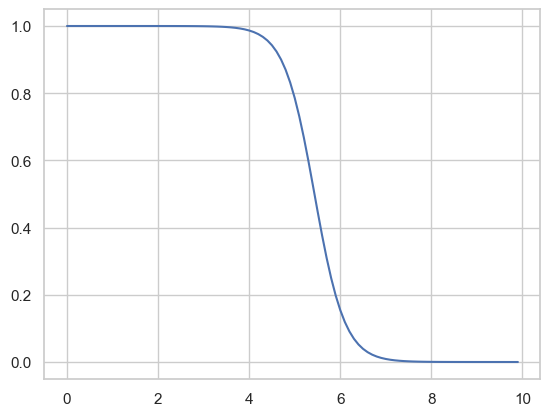

In [114]:
dists = np.arange(0, 10, 0.1)
def sigmoid(x, a, b):
      
    z = np.exp(-(a*x+b))
    sig = 1- 1 / (1 + z)

    return sig
# switch = (1.0-((dists-max)/min)**8)/(1-((dists-max)/min)**12)

plt.plot(dists,sigmoid(dists, 3, -16.3))


[4.588 0.599 3.884 ... 0.032 0.189 2.067]


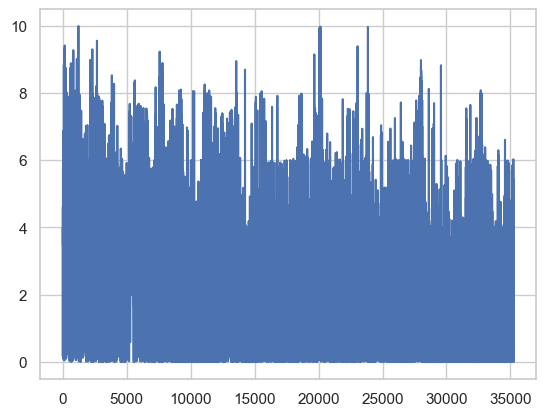

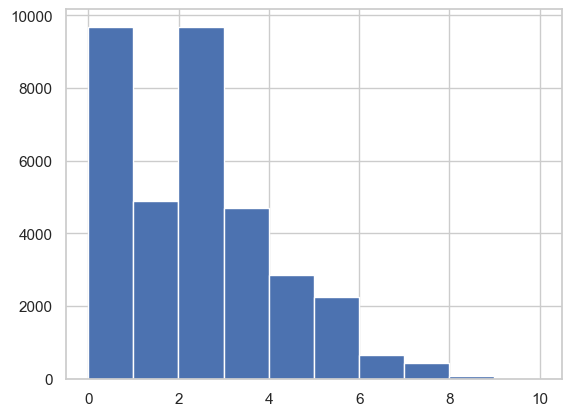

<Figure size 640x480 with 0 Axes>

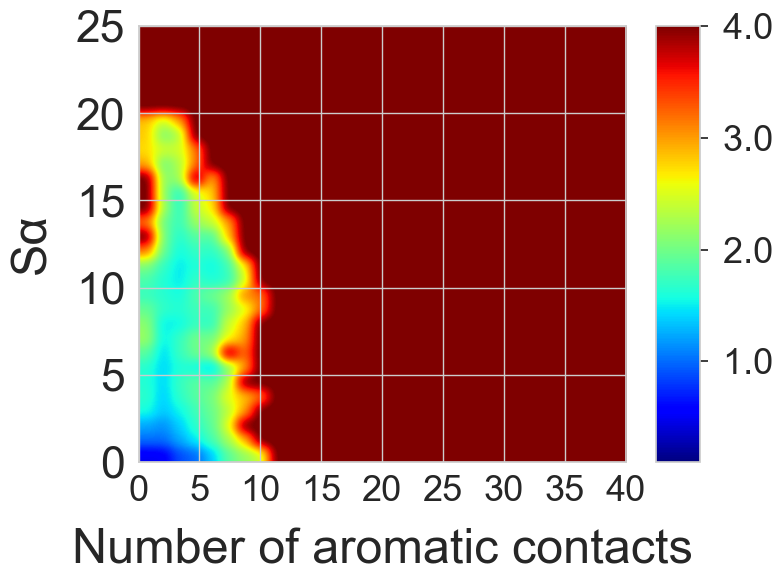

<Figure size 640x480 with 0 Axes>

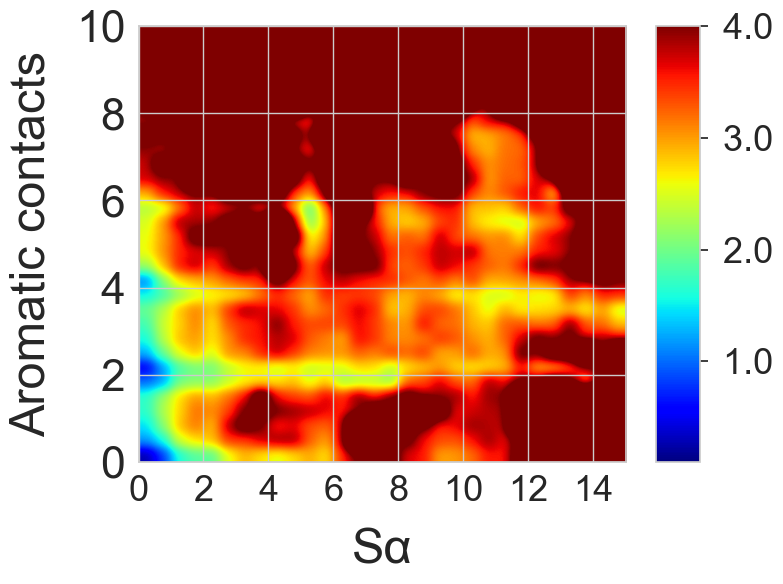

<Figure size 640x480 with 0 Axes>

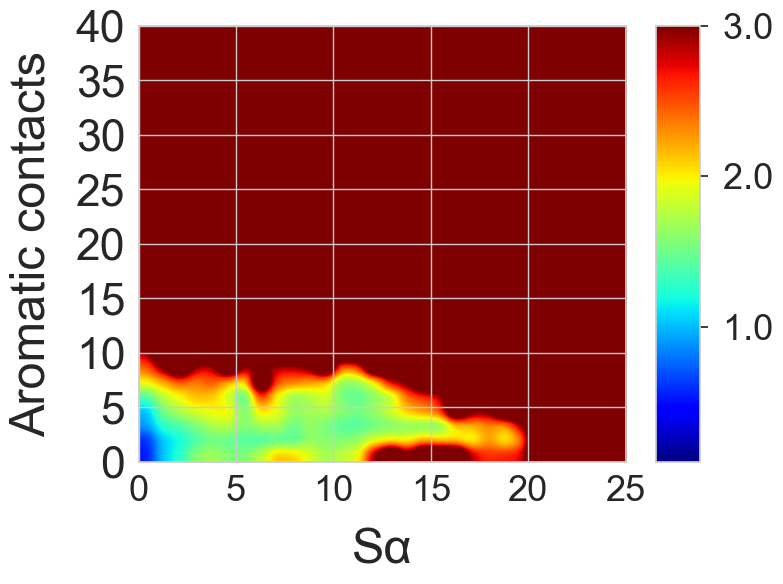

In [115]:
# Protein-protein
# Cut-off 4A, 7A
# 'closest-heavy'
prot_aromatic_res_index = [14,17,22,36]
aromatic_contact_pairs = []
for i in range(len(prot_aromatic_res_index)):
    aromatic_contact_pair = []
    for j in range(len(prot_aromatic_res_index)): 
        pair = [prot_aromatic_res_index[i], prot_aromatic_res_index[j]]
        dist = md.compute_contacts(trj, [pair], scheme='closest-heavy')
        dists = np.asarray(dist[0]).astype(float)
        switch_aro = sigmoid(dists*10, 3, -16.3)
        aromatic_contact_pair.append(switch_aro)
    aromatic_contact_pairs.append(aromatic_contact_pair) 
aromatic_contact_pairs = np.asarray(aromatic_contact_pairs).astype(float)
aromatic_contact_sum = aromatic_contact_pairs.sum(axis = 0).sum(axis = 0)- len(prot_aromatic_res_index)
aromatic_contact_sum = aromatic_contact_sum[:,0]
print(aromatic_contact_sum)
plt.plot(aromatic_contact_sum)
plt.show()
plt.clf()

plt.hist(aromatic_contact_sum)
plt.show()
plt.clf()


dG, xedges, yedges = free_energy(Sa_total, aromatic_contact_sum, 150, 0, 25, 0, 40)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Sα", size=35, labelpad=15)
plt.xlabel("Number of aromatic contacts", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=4.0)
plt.yticks(size='26')
plt.tight_layout()
# np.savetxt(outdir+'Sa_v_aromatic.dG.dat', dG)
plt.savefig(outdir+'Sa_v_aromatic.pdf')
plt.show()
plt.clf()


dG, xedges, yedges = free_energy(aromatic_contact_sum[contact_index], Sa_total[contact_index], 300, 0, 10, 0, 15)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.xlabel("Sα", size=35, labelpad=15)
plt.ylabel("Aromatic contacts", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=4.0)
plt.yticks(size='26')
plt.tight_layout()
plt.show()
# np.savetxt(outdir+'Sa_v_aromatic.dG.dat', dG)
plt.savefig(outdir+'Sa_v_aromatic.bf.pdf')

dG, xedges, yedges = free_energy(aromatic_contact_sum[contact_index], Sa_total[contact_index], 150, 0, 40, 0, 25)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.xlabel("Sα", size=35, labelpad=15)
plt.ylabel("Aromatic contacts", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')
plt.tight_layout()
# np.savetxt(outdir+'Sa_v_aromatic.dG.dat', dG)
plt.savefig(outdir+'Sa_v_aromatic.bf.pdf')

In [116]:
Sa_vs_aromatic = np.column_stack((Sa_total[contact_index], aromatic_contact_sum[contact_index]))
Sa_min = [7.5, 0]
Sa_max = [11, 3]
aromatic_min = [8, 4]
aromatic_max = [16, 11]
basin = []
for i in range(len(Sa_min)):
    Sa_basin = np.where((Sa_vs_aromatic[:, 0] > Sa_min[i]) & (Sa_vs_aromatic[:, 0] < Sa_max[i]))[0]
    aromatic_basin = np.where((Sa_vs_aromatic[:, 1] > aromatic_min[i]) & (Sa_vs_aromatic[:, 1] < aromatic_max[i]))[0]
    basin_index = np.intersect1d(Sa_basin, aromatic_basin)
    newtraj = trj[basin_index]
    md.Trajectory.save_xtc(newtraj, outdir + 'Sa.aromatic.%s.xtc' % i)
    print(newtraj)
    basin.append(basin_index)
print(basin)

<mdtraj.Trajectory with 22 frames, 593 atoms, 39 residues, and unitcells>
<mdtraj.Trajectory with 1579 frames, 593 atoms, 39 residues, and unitcells>
[array([  104,   110,   179,   193,   204,   241,   526,   558,   560,
         645,   648,   665,   892,  1901,  2175,  2177,  2178,  2181,
        2217,  2218,  7060, 17789]), array([ 1144,  1145,  1273, ..., 22127, 22128, 22130])]


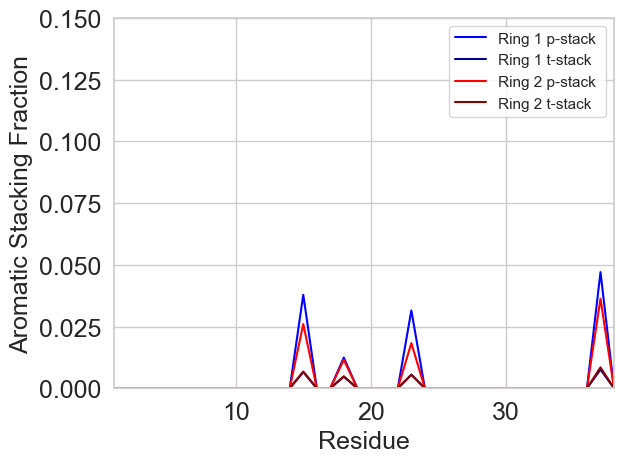

<Figure size 640x480 with 0 Axes>

In [117]:
# Cast aromatic contacts as per residue in each frame
aro_res_index = np.array(prot_ring_index)

aromatic_stacking_contacts_r0_p = np.zeros((n_frames, residues))
aromatic_stacking_contacts_r0_t = np.zeros((n_frames, residues))
aromatic_stacking_contacts_r1_p = np.zeros((n_frames, residues))
aromatic_stacking_contacts_r1_t = np.zeros((n_frames, residues))

for i in range(0, len(aro_res_index)):
    aromatic_stacking_contacts_r0_p[:,
                                    aro_res_index[i]] = Pstack['Lig_ring.0'][:, i]
    aromatic_stacking_contacts_r1_p[:,
                                    aro_res_index[i]] = Pstack['Lig_ring.1'][:, i]
    aromatic_stacking_contacts_r0_t[:,
                                    aro_res_index[i]] = Tstack['Lig_ring.0'][:, i]
    aromatic_stacking_contacts_r1_t[:,
                                    aro_res_index[i]] = Tstack['Lig_ring.1'][:, i]

np.savetxt(outdir+'aromatic_pstacking.traj.r0.dat',
           aromatic_stacking_contacts_r0_p, '%i')
aromatic_pstacking_fraction_r0 = np.sum(
    aromatic_stacking_contacts_r0_p, axis=0)/trj.n_frames
np.savetxt(outdir+'aromatic_pstacking.traj.r1.dat',
           aromatic_stacking_contacts_r1_p, '%i')
aromatic_pstacking_fraction_r1 = np.sum(
    aromatic_stacking_contacts_r1_p, axis=0)/trj.n_frames

np.savetxt(outdir+'aromatic_tstacking.traj.r0.dat',
           aromatic_stacking_contacts_r0_t, '%i')
aromatic_tstacking_fraction_r0 = np.sum(
    aromatic_stacking_contacts_r0_t, axis=0)/trj.n_frames
np.savetxt(outdir+'aromatic_tstacking.traj.r1.dat',
           aromatic_stacking_contacts_r1_t, '%i')
aromatic_tstacking_fraction_r1 = np.sum(
    aromatic_stacking_contacts_r1_t, axis=0)/trj.n_frames


aromatic_by_res_r0_p = np.column_stack(
    (residue_number, aromatic_pstacking_fraction_r0/boundfrac))
np.savetxt(outdir+'aromatic_pstacking.fraction.r0.dat',
           aromatic_by_res_r0_p, fmt='%.4f')
aromatic_by_res_r0_t = np.column_stack(
    (residue_number, aromatic_tstacking_fraction_r0/boundfrac))
np.savetxt(outdir+'aromatic_tstacking.fraction.r0.dat',
           aromatic_by_res_r0_t, fmt='%.4f')
aromatic_by_res_r1_p = np.column_stack(
    (residue_number, aromatic_pstacking_fraction_r1/boundfrac))
np.savetxt(outdir+'aromatic_pstacking.fraction.r1.dat',
           aromatic_by_res_r1_p, fmt='%.4f')
aromatic_by_res_r1_t = np.column_stack(
    (residue_number, aromatic_tstacking_fraction_r1/boundfrac))
np.savetxt(outdir+'aromatic_tstacking.fraction.r1.dat',
           aromatic_by_res_r1_t, fmt='%.4f')


plt.plot(residue_number, aromatic_pstacking_fraction_r1,
         label='Ring 1 p-stack ', color='blue')
plt.plot(residue_number, aromatic_tstacking_fraction_r1,
         label='Ring 1 t-stack ', color='darkblue')
plt.plot(residue_number, aromatic_pstacking_fraction_r0,
         label='Ring 2 p-stack ', color='red')
plt.plot(residue_number, aromatic_tstacking_fraction_r0,
         label='Ring 2 t-stack ', color='darkred')

plt.legend()
plt.xlabel('Residue', size=18)
plt.ylabel('Aromatic Stacking Fraction', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.ylim(0, 0.15)
plt.tight_layout()
plt.savefig(outdir+'AromaticStackingFraction.p_vs_t.pdf')
plt.show()
plt.clf()


In [118]:
sidechains = len(prot_rings)
print(n_frames)
stack_distance_cutoff = 0.65
bound_fraction = boundfrac
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print("Ring_Contacts", "Stacked", "P-stacked", "T-stacked")
for j in range(0, sidechains):
    name = prot_ring_index[j]
    res = prot_ring_name[j]
    theta = Stackparams['Lig_ring.0'][name][:, 3]
    newtheta = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(theta)-90.0)
    phi = Stackparams['Lig_ring.0'][name][:, 4]
    newphi = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)
    # Procacci: We define p-stack a domain S in the r, θ, ϕ space as the subset of points such that 3.5 < r < 4.5 Å, θ < 15° and ϕ < 30°.
    # Here: p-stack a domain S in the r<0.6, θ < 45° and ϕ < 45°.
    contacts = np.where(Stackparams['Lig_ring.0']
                        [name][:, 0] <= stack_distance_cutoff)
    b = np.where(newtheta[contacts] <= 45)
    c = np.where(newphi[contacts] <= 60)
    pstack = np.intersect1d(b, c)
    # Procacci: T-stack is the volume of the following T domain: 4.5 < r < 5.5 Å, 75° < θ < 90° and ϕ < 15°.
    # Here :  r < 6.0 Å, 75° < θ < 90° and ϕ < 15°.
    d = np.where(newtheta[contacts] >= 75)
    e = np.where(newphi[contacts] <= 60)
    tstack = np.intersect1d(d, e)
    print(name, res)
    arocontacts = len(contacts[0])/n_frames
    stacked = (len(pstack)+len(tstack))/n_frames
    pstacked = len(pstack)/n_frames
    tstacked = len(tstack)/n_frames
    print("Ring 0: %6.3lf %6.3lf %6.3lf %6.3lf" %
          (arocontacts, stacked, pstacked, tstacked))

    theta = Stackparams['Lig_ring.1'][name][:, 3]
    newtheta = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(theta)-90.0)
    phi = Stackparams['Lig_ring.1'][name][:, 4]
    newphi = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)
    # Procacci: We define p-stack a domain S in the r, θ, ϕ space as the subset of points such that 3.5 < r < 4.5 Å, θ < 15° and ϕ < 30°.
    # Here: p-stack a domain S in the r<0.6, θ < 45° and ϕ < 60°.
    contacts = np.where(Stackparams['Lig_ring.1']
                        [name][:, 0] <= stack_distance_cutoff)
    b = np.where(newtheta[contacts] <= 45)
    c = np.where(newphi[contacts] <= 60)
    pstack = np.intersect1d(b, c)
    # Procacci: T-stack is the volume of the following T domain: 4.5 < r < 5.5 Å, 75° < θ < 90° and ϕ < 15°.
    # Here :  r < 7.5 Å, 45° < θ and ϕ < 60°.
    d = np.where(newtheta[contacts] >= 75)
    e = np.where(newphi[contacts] <= 60)
    tstack = np.intersect1d(c, e)
    arocontacts = len(contacts[0])/n_frames
    stacked = (len(pstack)+len(tstack))/n_frames
    pstacked = len(pstack)/n_frames
    tstacked = len(tstack)/n_frames
    print("Ring 1: %6.3lf %6.3lf %6.3lf %6.3lf" %
          (arocontacts, stacked, pstacked, tstacked))


35251
Ring_Contacts Stacked P-stacked T-stacked
14 PHE15
Ring 0:  0.076  0.030  0.026  0.004
Ring 1:  0.064  0.087  0.038  0.049
17 HIS18
Ring 0:  0.036  0.015  0.011  0.004
Ring 1:  0.031  0.034  0.012  0.021
22 PHE23
Ring 0:  0.056  0.022  0.018  0.004
Ring 1:  0.057  0.075  0.032  0.044
36 TYR37
Ring 0:  0.080  0.043  0.036  0.006
Ring 1:  0.083  0.109  0.047  0.062


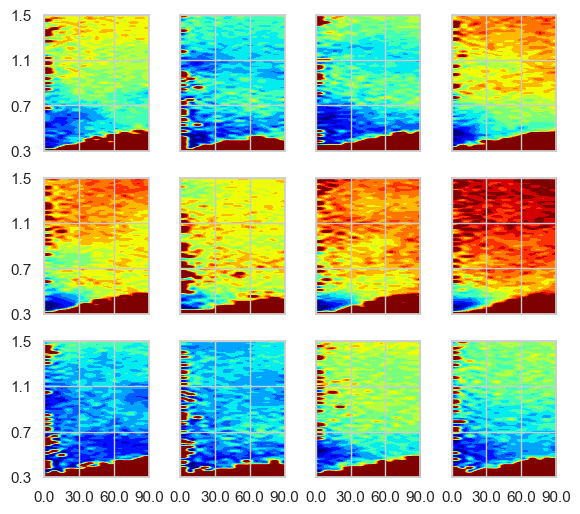

In [167]:
sidechains = len(prot_rings)
fig, ax = plt.subplots(3, sidechains, figsize=(6.6, 6), sharex=True, sharey=True)

y0 = 0
ymax = 90.0
x0 = 0.3
xmax = 1.5
maxangle = ymax
maxdist = xmax
mindist = x0
minangle = y0

j = 0
name = prot_ring_index[j]
res = prot_ring_name[j]
theta = Stackparams['Lig_ring.0'][name][:, 3]
newtheta = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(theta)-90.0)
d = Stackparams['Lig_ring.0'][name][:, 0]
a, xedges, yedges = np.histogram2d(d, newtheta, [65, 15], [[x0, xmax], [
                                   y0, ymax]], normed=True, weights=None)
bin_centers_d = np.zeros((len(xedges)-1, len(yedges)-1))
bin_centers_theta = np.zeros((len(xedges)-1, len(yedges)-1))
norm = np.zeros((len(xedges)-1, len(yedges)-1))
kbT = 300*0.008314/4.184  # kT in kcal/mol

for i in range(1, len(xedges)):
    for j in range(1, len(yedges)):
        bin_centers_d[i-1, j-1] = (xedges[i-1]+xedges[i])/2
        bin_centers_theta[i-1, j-1] = (yedges[j-1]+yedges[j])/2

for i in range(1, len(xedges)):
    for j in range(1, len(yedges)):
        dist = bin_centers_d[i-1, j-1]
        thet = bin_centers_theta[i-1, j-1]
        norm[i-1, j-1] = np.sin(np.deg2rad(thet))*dist**2*a.sum()

for j in range(0, sidechains):
    name = prot_ring_index[j]
    res = prot_ring_name[j]
    theta = Stackparams['Lig_ring.0'][name][:, 3]
    newtheta = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(theta)-90.0)
    d = Stackparams['Lig_ring.0'][name][:, 0]
    a, xedges, yedges = np.histogram2d(d, newtheta, [65, 15], [[x0, xmax], [
                                       y0, ymax]], normed=True, weights=None)

    kbT = 300*0.008314/4.184  # kT in kcal/mol
    dG_norm = np.log((a/norm)+.000001)
    dG_norm = -(kbT)*dG_norm  # Convert to kcal/mol
    minvalue = np.min(dG_norm)
    dG_norm = dG_norm-minvalue
    fes_cutoff = 3.60
    above_threshold = np.where(dG_norm > 5)
    dG_norm[above_threshold] = 5
    # ax[0, j].set_title("%s %s" % (name, res), fontsize=12)
    ax[0, j].set_xticks(np.linspace(0, maxangle, 4))
    ax[0, j].set_yticks(np.linspace(mindist, maxdist, 4))
    ax[0, j].set_xticklabels([str(round(a, 2))
                             for a in np.linspace(0, maxangle, 4)])
    ax[0, j].set_yticklabels([str(round(a, 2))
                             for a in np.linspace(mindist, maxdist, 4)])
    cmap = plt.get_cmap('jet', 15)
    maxangle = ymax
    maxdist = xmax
    ax[0, j].imshow(dG_norm, extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
                    origin='lower', aspect='auto', cmap=cmap, interpolation='spline36', vmin=0, vmax=4)

    theta = Stackparams['Lig_ring.1'][name][:, 3]
    newtheta = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(theta)-90.0)
    d = Stackparams['Lig_ring.1'][name][:, 0]
    a, xedges, yedges = np.histogram2d(d, newtheta, [65, 15], [[x0, xmax], [
                                       y0, ymax]], normed=True, weights=None)
    dG_norm = np.log((a/norm)+.000001)
    dG_norm = -(kbT)*dG_norm  # Convert to kcal/mol
    minvalue = np.min(dG_norm)
    dG_norm = dG_norm-minvalue
    fes_cutoff = 3.60
    above_threshold = np.where(dG_norm > 5)
    dG_norm[above_threshold] = 5
    ax[1, j].imshow(dG_norm, extent=[0, maxangle, mindist, maxdist], origin='lower',
                    aspect='auto', cmap=cmap, interpolation='spline36', vmin=0, vmax=4)
    # ax[1, j].set_title("%s %s" % (name, res), fontsize=12)
    ax[1, j].set_xticks(np.linspace(0, maxangle, 4))
    ax[1, j].set_yticks(np.linspace(mindist, maxdist, 4))
    ax[1, j].set_xticklabels([str(round(a, 2))
                             for a in np.linspace(0, maxangle, 4)])
    ax[1, j].set_yticklabels([str(round(a, 2))
                             for a in np.linspace(mindist, maxdist, 4)])
    
    theta = Stackparams['Lig_ring.2'][name][:, 3]
    newtheta = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(theta)-90.0)
    d = Stackparams['Lig_ring.2'][name][:, 0]
    a, xedges, yedges = np.histogram2d(d, newtheta, [65, 15], [[x0, xmax], [
                                       y0, ymax]], normed=True, weights=None)
    dG_norm = np.log((a/norm)+.000001)
    dG_norm = -(kbT)*dG_norm  # Convert to kcal/mol
    minvalue = np.min(dG_norm)
    dG_norm = dG_norm-minvalue
    fes_cutoff = 3.60
    above_threshold = np.where(dG_norm > 5)
    dG_norm[above_threshold] = 5
    cax = ax[2, j].imshow(dG_norm, extent=[0, maxangle, mindist, maxdist], origin='lower',
                    aspect='auto', cmap=cmap, interpolation='spline36', vmin=0, vmax=4)
    # ax[2, j].set_title("%s %s" % (name, res), fontsize=12)
    ax[2, j].set_xticks(np.linspace(0, maxangle, 4))
    ax[2, j].set_yticks(np.linspace(mindist, maxdist, 4))
    ax[2, j].set_xticklabels([str(round(a, 2))
                             for a in np.linspace(0, maxangle, 4)])
    ax[2, j].set_yticklabels([str(round(a, 2))
                             for a in np.linspace(mindist, maxdist, 4)])
plt.subplots_adjust(wspace=0.3) 
plt.savefig(outdir+'AromaticStackingFraction.RvTheta.pdf')
plt.show()


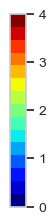

In [168]:
# Create a separate figure for the colorbar
fig2, ax2 = plt.subplots(figsize=(0.2, 2.5))  # Adjust the size for the colorbar figure
# Add the colorbar in the new figure
colorbar = fig2.colorbar(cax, cax=ax2, orientation='vertical')
colorbar.ax.tick_params(labelsize=10)
plt.savefig(outdir+'AromaticStackingFraction.RvTheta.colorbar.pdf', dpi=300, bbox_inches="tight")
plt.show()

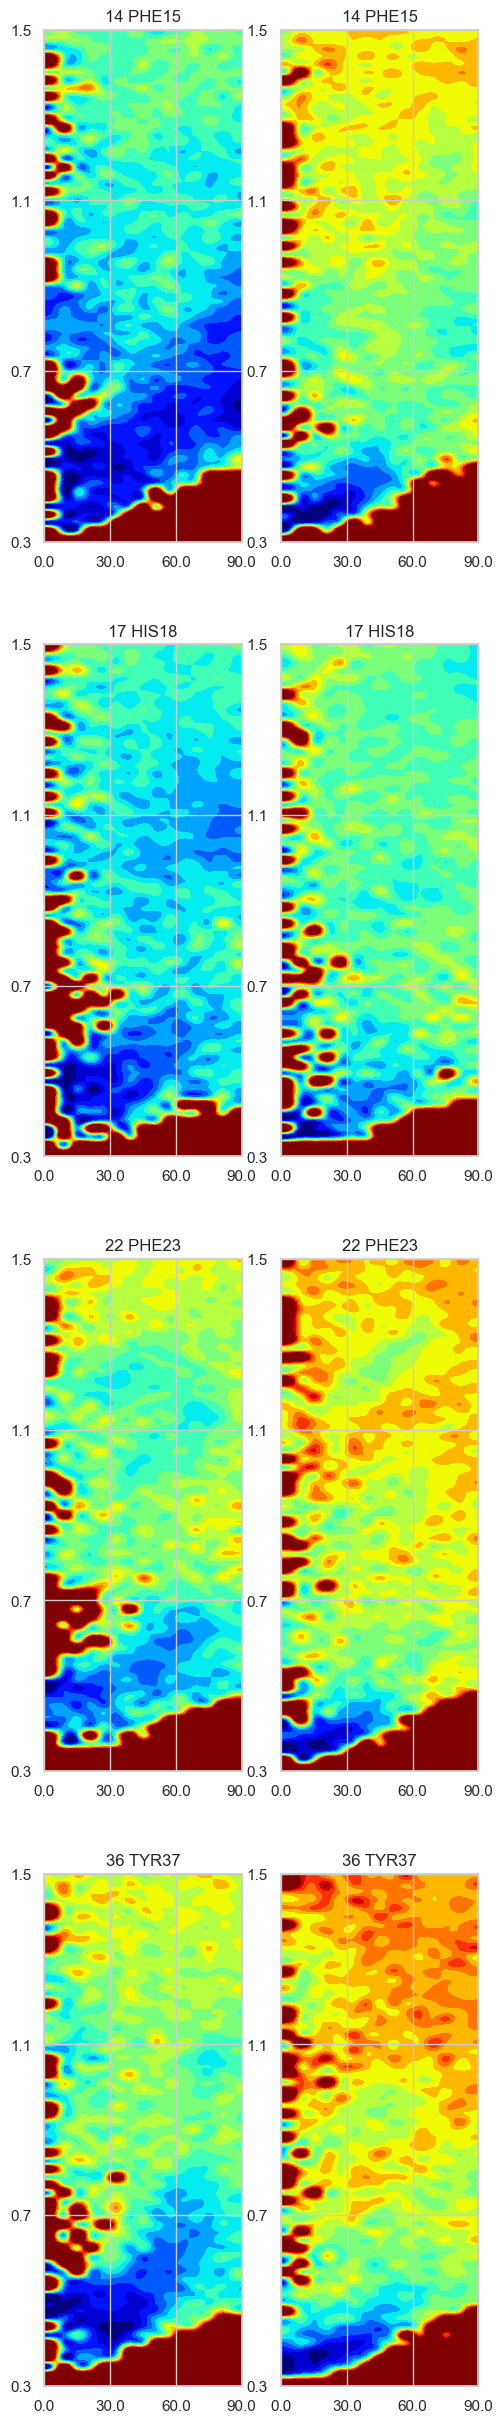

In [120]:
sidechains = len(prot_rings)
fig, ax = plt.subplots(sidechains, 2, figsize=(5.6, 30.6))

y0 = 0
ymax = 90.0
x0 = 0.3
xmax = 1.5
maxangle = ymax
maxdist = xmax
mindist = x0
minangle = y0

j = 0
name = prot_ring_index[j]
res = prot_ring_name[j]
phi = Stackparams['Lig_ring.0'][name][:, 4]
newphi = np.abs(theta)-2*(np.abs(theta) > 90.0)*(np.abs(phi)-90.0)
d = Stackparams['Lig_ring.0'][name][:, 0]
a, xedges, yedges = np.histogram2d(d, newtheta, [65, 15], [[x0, xmax], [
                                   y0, ymax]], normed=True, weights=None)
bin_centers_d = np.zeros((len(xedges)-1, len(yedges)-1))
bin_centers_theta = np.zeros((len(xedges)-1, len(yedges)-1))
norm = np.zeros((len(xedges)-1, len(yedges)-1))
kbT = 300*0.008314/4.184  # kT in kcal/mol

for i in range(1, len(xedges)):
    for j in range(1, len(yedges)):
        bin_centers_d[i-1, j-1] = (xedges[i-1]+xedges[i])/2
        bin_centers_theta[i-1, j-1] = (yedges[j-1]+yedges[j])/2

for i in range(1, len(xedges)):
    for j in range(1, len(yedges)):
        dist = bin_centers_d[i-1, j-1]
        thet = bin_centers_theta[i-1, j-1]
        norm[i-1, j-1] = np.sin(np.deg2rad(thet))*dist**2*a.sum()

for j in range(0, sidechains):
    name = prot_ring_index[j]
    res = prot_ring_name[j]
    phi = Stackparams['Lig_ring.0'][name][:, 4]
    newphi = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)
    d = Stackparams['Lig_ring.0'][name][:, 0]
    a, xedges, yedges = np.histogram2d(
        d, newphi, [65, 15], [[x0, xmax], [y0, ymax]], normed=True, weights=None)

    kbT = 300*0.008314/4.184  # kT in kcal/mol
    dG_norm = np.log((a/norm)+.000001)
    dG_norm = -(kbT)*dG_norm  # Convert to kcal/mol
    minvalue = np.min(dG_norm)
    dG_norm = dG_norm-minvalue
    fes_cutoff = 3.60
    above_threshold = np.where(dG_norm > 5)
    dG_norm[above_threshold] = 5
    ax[j, 0].set_title("%s %s" % (name, res), fontsize=12)
    ax[j, 0].set_xticks(np.linspace(0, maxangle, 4))
    ax[j, 0].set_yticks(np.linspace(mindist, maxdist, 4))
    ax[j, 0].set_xticklabels([str(round(a, 2))
                             for a in np.linspace(0, maxangle, 4)])
    ax[j, 0].set_yticklabels([str(round(a, 2))
                             for a in np.linspace(mindist, maxdist, 4)])
    cmap = plt.get_cmap('jet', 15)
    maxangle = ymax
    maxdist = xmax
    ax[j, 0].imshow(dG_norm, extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],
                    origin='lower', aspect='auto', cmap=cmap, interpolation='spline36', vmin=0, vmax=4)
    phi = Stackparams['Lig_ring.1'][name][:, 4]
    newphi = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)
    d = Stackparams['Lig_ring.1'][name][:, 0]
    a, xedges, yedges = np.histogram2d(
        d, newphi, [65, 15], [[x0, xmax], [y0, ymax]], normed=True, weights=None)
    dG_norm = np.log((a/norm)+.000001)
    dG_norm = -(kbT)*dG_norm  # Convert to kcal/mol
    minvalue = np.min(dG_norm)
    dG_norm = dG_norm-minvalue
    fes_cutoff = 3.60
    above_threshold = np.where(dG_norm > 5)
    dG_norm[above_threshold] = 5
    ax[j, 1].imshow(dG_norm, extent=[0, maxangle, mindist, maxdist], origin='lower',
                    aspect='auto', cmap=cmap, interpolation='spline36', vmin=0, vmax=4)
    ax[j, 1].set_title("%s %s" % (name, res), fontsize=12)
    ax[j, 1].set_title("%s %s" % (name, res), fontsize=12)
    ax[j, 1].set_xticks(np.linspace(0, maxangle, 4))
    ax[j, 1].set_yticks(np.linspace(mindist, maxdist, 4))
    ax[j, 1].set_xticklabels([str(round(a, 2))
                             for a in np.linspace(0, maxangle, 4)])
    ax[j, 1].set_yticklabels([str(round(a, 2))
                             for a in np.linspace(mindist, maxdist, 4)])
    cmap = plt.get_cmap('jet', 15)

plt.savefig(outdir+'AromaticStackingFraction.RvPhi.pdf')
plt.show()


In [121]:
# Select Ligand Residues
ligand = top.select("resid 38")
# Select Protein Residues
protein = top.select("resid 0 to 37")


HBond_PD = np.zeros((n_frames, residues))
HBond_LD = np.zeros((n_frames, residues))
Hbond_pairs_PD = {}
Hbond_pairs_LD = {}


def add_hbond_pair(donor, acceptor, hbond_pairs, donor_res):
    """
    counting the types of bonds with a dictionary donor_res-->donor-->accepptor
    """
    if donor_res not in hbond_pairs:
        hbond_pairs[donor_res] = {}
    if donor not in hbond_pairs[donor_res]:
        hbond_pairs[donor_res][donor] = {}
    if acceptor not in hbond_pairs[donor_res][donor]:
        hbond_pairs[donor_res][donor][acceptor] = 0
    hbond_pairs[donor_res][donor][acceptor] += 1

# Donor & Acceptors Definitions from DESRES paper:
# ligdon = mol.select('chain B and (nitrogen or oxygen or sulfur) and (withinbonds 1 of hydrogen)')
# ligacc = mol.select('chain B and (nitrogen or oxygen or sulfur)')
# protdon = mol.select('chain A and (nitrogen or oxygen or sulfur) and (withinbonds 1 of hydrogen)')
# protacc = mol.select('chain A and (nitrogen or oxygen or sulfur)')


for frame in range(n_frames):
    hbonds = baker_hubbard2(trj[frame], angle_cutoff=150,
                            distance_cutoff=0.35, lig_donor_index=lig_hbond_donors)
    for hbond in hbonds:
        if ((hbond[0] in protein) and (hbond[2] in ligand)):
            donor = top.atom(hbond[0])
            donor_id = hbond[0]
            donor_res = top.atom(hbond[0]).residue.resSeq
            acc = top.atom(hbond[2])
            acc = top.atom(hbond[2])
            acc_res = top.atom(hbond[2]).residue.resSeq
            HBond_PD[frame][donor_res - 1] = 1 # off by one due to indexing 
            add_hbond_pair(donor, acc, Hbond_pairs_PD, donor_res)

        if ((hbond[0] in ligand) and (hbond[2] in protein)):
            donor = top.atom(hbond[0])
            donor_id = hbond[0]
            donor_res = top.atom(hbond[0]).residue.resSeq
            acc = top.atom(hbond[2])
            acc_id = hbond[2]
            acc_res = top.atom(hbond[2]).residue.resSeq
            HBond_LD[frame][acc_res - 1] = 1 # off by one due to indexing 
            add_hbond_pair(donor, acc, Hbond_pairs_LD, acc_res)


In [122]:
residue_number = range(residue_offset, residues + residue_offset) # to include ligand? 
# print(len(residue_number))

HB_Total = HBond_PD+HBond_LD
HB_Total_ave = np.mean(HB_Total, axis=0)


PD_ave = np.mean(HBond_PD, axis=0)
LD_ave = np.mean(HBond_LD, axis=0)
# for i in Hbond_pairs_PD:
    # print(i, int(i), Hbond_pairs_PD[i]) # don't have to add an offset here

# print("HBond_Ligand Donors")

# for i in Hbond_pairs_LD:
    # print(i, Hbond_pairs_LD[i])

np.savetxt(outdir+'Hbond.PD.traj.dat', HBond_PD, '%i')
np.savetxt(outdir+'Hbond.LD.traj.dat', HBond_LD, '%i')
np.savetxt(outdir+'Hbond.all.traj.dat', HB_Total, '%i')
hbond_by_res = np.column_stack((residue_number, HB_Total_ave))
hbond_by_res_PD = np.column_stack((residue_number, PD_ave))
hbond_by_res_LD = np.column_stack((residue_number, LD_ave))


HBond_PD_ave, HBond_PD_pyb_be = get_blockerrors_pyblock(HBond_PD, 1.0)
HBond_LD_ave, HBond_LD_pyb_be = get_blockerrors_pyblock(HBond_LD, 1.0)
HBond_ave, HBond_pyb_be = get_blockerrors_pyblock(HB_Total, 1.0)

Hbond_by_res = np.column_stack(
    (residue_number, HBond_ave, HBond_pyb_be))
Hbond_by_res_bf = np.column_stack(
    (residue_number, HBond_ave/boundfrac, HBond_pyb_be/boundfrac))
np.savetxt(outdir+'hbond_fraction.be.dat', Hbond_by_res)
np.savetxt(outdir+'hbond_fraction.boundfraction.be.dat', Hbond_by_res_bf)


Hbond_by_res_LD = np.column_stack(
    (residue_number, HBond_LD_ave, HBond_LD_pyb_be))
np.savetxt(outdir+'hbond_fraction.PD.be.dat', Hbond_by_res_LD)
Hbond_by_res_LD_bf = np.column_stack(
    (residue_number, HBond_LD_ave/boundfrac, HBond_LD_pyb_be/boundfrac))
np.savetxt(outdir+'hbond_fraction.PD.boundfraction.be.dat', Hbond_by_res_LD_bf)


Hbond_by_res_PD = np.column_stack(
    (residue_number, HBond_PD_ave, HBond_PD_pyb_be))
np.savetxt(outdir+'hbond_fraction.LD.be.dat', Hbond_by_res_PD)
Hbond_by_res_PD_bf = np.column_stack(
    (residue_number, HBond_PD_ave/boundfrac, HBond_PD_pyb_be/boundfrac))
np.savetxt(outdir+'hbond_fraction.PD.boundfraction.be.dat', Hbond_by_res_PD_bf)


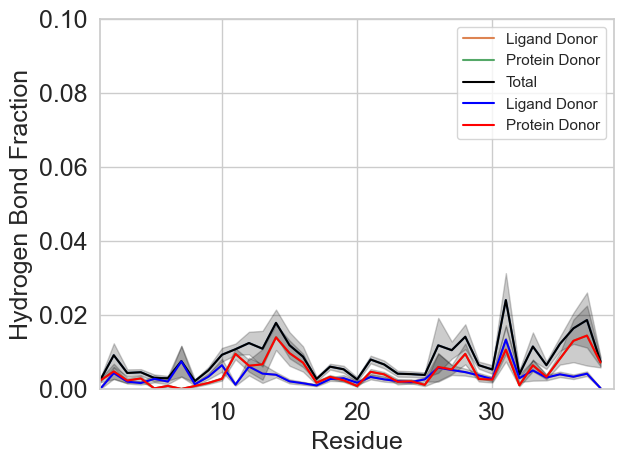

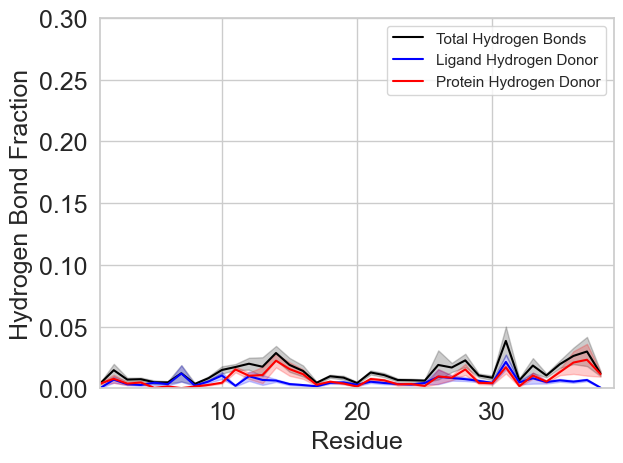

<Figure size 640x480 with 0 Axes>

In [123]:
residue_number = range(residue_offset, residue_offset+residues)
plt.plot(residue_number, HB_Total_ave)
plt.plot(residue_number, LD_ave, label="Ligand Donor")
plt.plot(residue_number, PD_ave, label="Protein Donor")


plt.plot(Hbond_by_res[:, 0], Hbond_by_res[:, 1], color='black', label='Total')
plt.fill_between(Hbond_by_res[:, 0], Hbond_by_res[:, 1]+Hbond_by_res[:, 2],
                 Hbond_by_res[:, 1]-Hbond_by_res[:, 2], color='black', alpha=0.2)
plt.plot(Hbond_by_res_LD[:, 0], Hbond_by_res_LD[:, 1],
         color='blue', label='Ligand Donor')
plt.fill_between(Hbond_by_res_LD[:, 0], Hbond_by_res_LD[:, 1]+Hbond_by_res_LD[:, 2],
                 Hbond_by_res_LD[:, 1]-Hbond_by_res_LD[:, 2], color='black', alpha=0.2)
plt.plot(Hbond_by_res_PD[:, 0], Hbond_by_res_PD[:, 1],
         color='red', label='Protein Donor')
plt.fill_between(Hbond_by_res_PD[:, 0], Hbond_by_res_PD[:, 1]+Hbond_by_res_PD[:, 2],
                 Hbond_by_res_PD[:, 1]-Hbond_by_res_PD[:, 2], color='black', alpha=0.2)


plt.legend()
plt.ylim(0, 0.10)
plt.xlabel('Residue', size=18)
plt.ylabel('Hydrogen Bond Fraction', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues)
plt.tight_layout()
plt.savefig(outdir+'HbondFraction.allframes.pdf')
plt.show()
plt.clf()


plt.plot(Hbond_by_res_bf[:, 0], Hbond_by_res_bf[:, 1],
         color='black', label='Total Hydrogen Bonds')
plt.fill_between(Hbond_by_res_bf[:, 0], Hbond_by_res_bf[:, 1]+Hbond_by_res_bf[:, 2],
                 Hbond_by_res_bf[:, 1]-Hbond_by_res_bf[:, 2], color='black', alpha=0.2)
plt.plot(Hbond_by_res_LD_bf[:, 0], Hbond_by_res_LD_bf[:,
         1], color='blue', label='Ligand Hydrogen Donor')
plt.fill_between(Hbond_by_res_LD_bf[:, 0], Hbond_by_res_LD_bf[:, 1]+Hbond_by_res_LD_bf[:, 2],
                 Hbond_by_res_LD_bf[:, 1]-Hbond_by_res_LD_bf[:, 2], color='blue', alpha=0.2)
plt.plot(Hbond_by_res_PD_bf[:, 0], Hbond_by_res_PD_bf[:,
         1], color='red', label='Protein Hydrogen Donor')
plt.fill_between(Hbond_by_res_PD_bf[:, 0], Hbond_by_res_PD_bf[:, 1]+Hbond_by_res_PD_bf[:, 2],
                 Hbond_by_res_PD_bf[:, 1]-Hbond_by_res_PD_bf[:, 2], color='red', alpha=0.2)


plt.legend()
plt.xlabel('Residue', size=18)
plt.ylabel('Hydrogen Bond Fraction', size=18)
plt.ylim(0, 0.30)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues)
plt.tight_layout()
plt.savefig(outdir+'HbondFraction.boundfraction.pdf')
plt.show()
plt.clf()


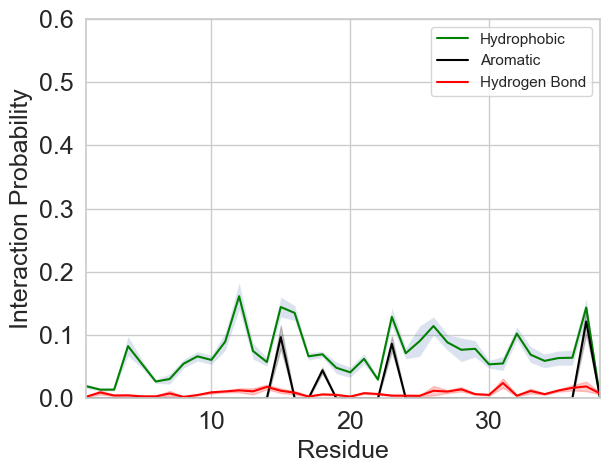

<Figure size 640x480 with 0 Axes>

In [124]:
plt.plot(range(1,residues + 1),
         hphob_by_res[:, 1], label='Hydrophobic', color='green')
plt.fill_between(range(1,residues+1),
                 hphob_by_res[:, 1]+hphob_by_res[:, 2], hphob_by_res[:, 1]-hphob_by_res[:, 2], alpha=0.2)

plt.plot(aro_by_res[:, 0], aro_by_res[:, 1], color='black', label='Aromatic')
plt.fill_between(aro_by_res[:, 0], aro_by_res[:, 1]+aro_by_res[:, 2],
                 aro_by_res[:, 1]-aro_by_res[:, 2], color='black', alpha=0.2)

plt.plot(Hbond_by_res[:, 0], Hbond_by_res[:, 1],
         label='Hydrogen Bond', color='red')
plt.fill_between(Hbond_by_res[:, 0], Hbond_by_res[:, 1]+Hbond_by_res[:, 2],
                 Hbond_by_res[:, 1]-Hbond_by_res[:, 2], color='red', alpha=0.2)

plt.xlabel('Residue', size=18)
plt.ylabel('Interaction Probability', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.legend()
plt.tight_layout()
plt.savefig(outdir+'LigandInteractions.allframes.pdf')
plt.ylim(0, 0.6)
plt.show()
plt.clf()

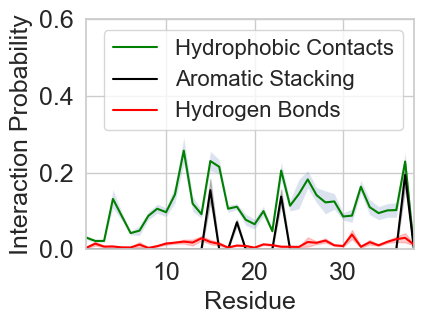

<Figure size 640x480 with 0 Axes>

In [125]:
plt.figure(figsize=(4.4,3.4))
plt.plot(range(1,residues+1),
         hphob_by_res[:, 1]/boundfrac, label='Hydrophobic Contacts', color='green')
plt.fill_between(range(1,residues+1), hphob_by_res[:, 1]/boundfrac+hphob_by_res[:, 2] /
                 boundfrac, hphob_by_res[:, 1]/boundfrac-hphob_by_res[:, 2]/boundfrac, alpha=0.2)

plt.plot(aro_by_res[:, 0], aro_by_res[:, 1]/boundfrac,
         color='black', label='Aromatic Stacking')
plt.fill_between(aro_by_res[:, 0], aro_by_res[:, 1]/boundfrac+aro_by_res[:, 2]/boundfrac,
                 aro_by_res[:, 1]/boundfrac-aro_by_res[:, 2]/boundfrac, color='black', alpha=0.2)

plt.plot(Hbond_by_res[:, 0], Hbond_by_res[:, 1] /
         boundfrac, label='Hydrogen Bonds', color='red')
plt.fill_between(Hbond_by_res[:, 0], Hbond_by_res[:, 1]/boundfrac+Hbond_by_res[:, 2]/boundfrac,
                 Hbond_by_res[:, 1]/boundfrac-Hbond_by_res[:, 2]/boundfrac, color='red', alpha=0.2)

plt.xlabel('Residue', size=18)
plt.ylabel('Interaction Probability', size=18)
plt.tick_params(labelsize=18)
plt.xlim(residue_offset, residue_offset+residues-1)
plt.ylim(0, 0.6)
plt.legend(fontsize=16)
#plt.title("Bound Ensemble",size=18)
plt.tight_layout()
plt.savefig(outdir+'LigandInteractions.boundfraction.pdf')
plt.show()
plt.clf()


In [126]:
sequence = []
residue_offset = 1
for residue in trj.topology.residues:
    index = residue.index
    renum = int(index) + residue_offset
    sequence.append(residue.name + "%s" % (renum))
print(sequence)

# Make dual contact map
# This part can be commented once the dual_contact_map.dat is generated to save time
contact_maps = []
for i in range(0, 38):
    # print(i)
    contact_map = []
    for j in range(0, 38):
        dist1 = md.compute_contacts(trj, [[i, 38]], scheme='closest-heavy')
        dist2 = md.compute_contacts(trj, [[j, 38]], scheme='closest-heavy')
        array1 = np.asarray(dist1[0]).astype(float)
        array2 = np.asarray(dist2[0]).astype(float)
        contact1 = np.where(array1 < 0.5, 1, 0)
        contact2 = np.where(array2 < 0.5, 1, 0)
        sum = contact1 + contact2
        contact = np.where(sum == 2, 1, 0)
        contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
final_map = np.asarray(contact_maps).astype(float)
np.savetxt('%s/dual_contact_map.dat' % outdir, final_map, fmt='%1.3f')

sequence = seq[:-1]

final_map = np.loadtxt('%s/dual_contact_map.dat' % outdir)


['LYS1', 'CYS2', 'ASN3', 'THR4', 'ALA5', 'THR6', 'CYS7', 'ALA8', 'THR9', 'GLN10', 'ARG11', 'LEU12', 'ALA13', 'ASN14', 'PHE15', 'LEU16', 'VAL17', 'HIS18', 'SER19', 'GLY20', 'ASN21', 'ASN22', 'PHE23', 'GLY24', 'ALA25', 'ILE26', 'LEU27', 'SER28', 'SER29', 'THR30', 'ASN31', 'VAL32', 'GLY33', 'SER34', 'ASN35', 'THR36', 'TYR37', 'NH238', 'LIG39']


In [127]:
sequence = []
residue_offset = 1
count = 0

for residue in trj.topology.residues:
    if count % 2 == 0: 
        index = residue.index
        renum = int(index) + residue_offset
        sequence.append(residue.name + "%s" % (renum))
    else: 
        sequence.append("")
    count +=1
print(sequence)

['LYS1', '', 'ASN3', '', 'ALA5', '', 'CYS7', '', 'THR9', '', 'ARG11', '', 'ALA13', '', 'PHE15', '', 'VAL17', '', 'SER19', '', 'ASN21', '', 'PHE23', '', 'ALA25', '', 'LEU27', '', 'SER29', '', 'ASN31', '', 'GLY33', '', 'ASN35', '', 'TYR37', '', 'LIG39']


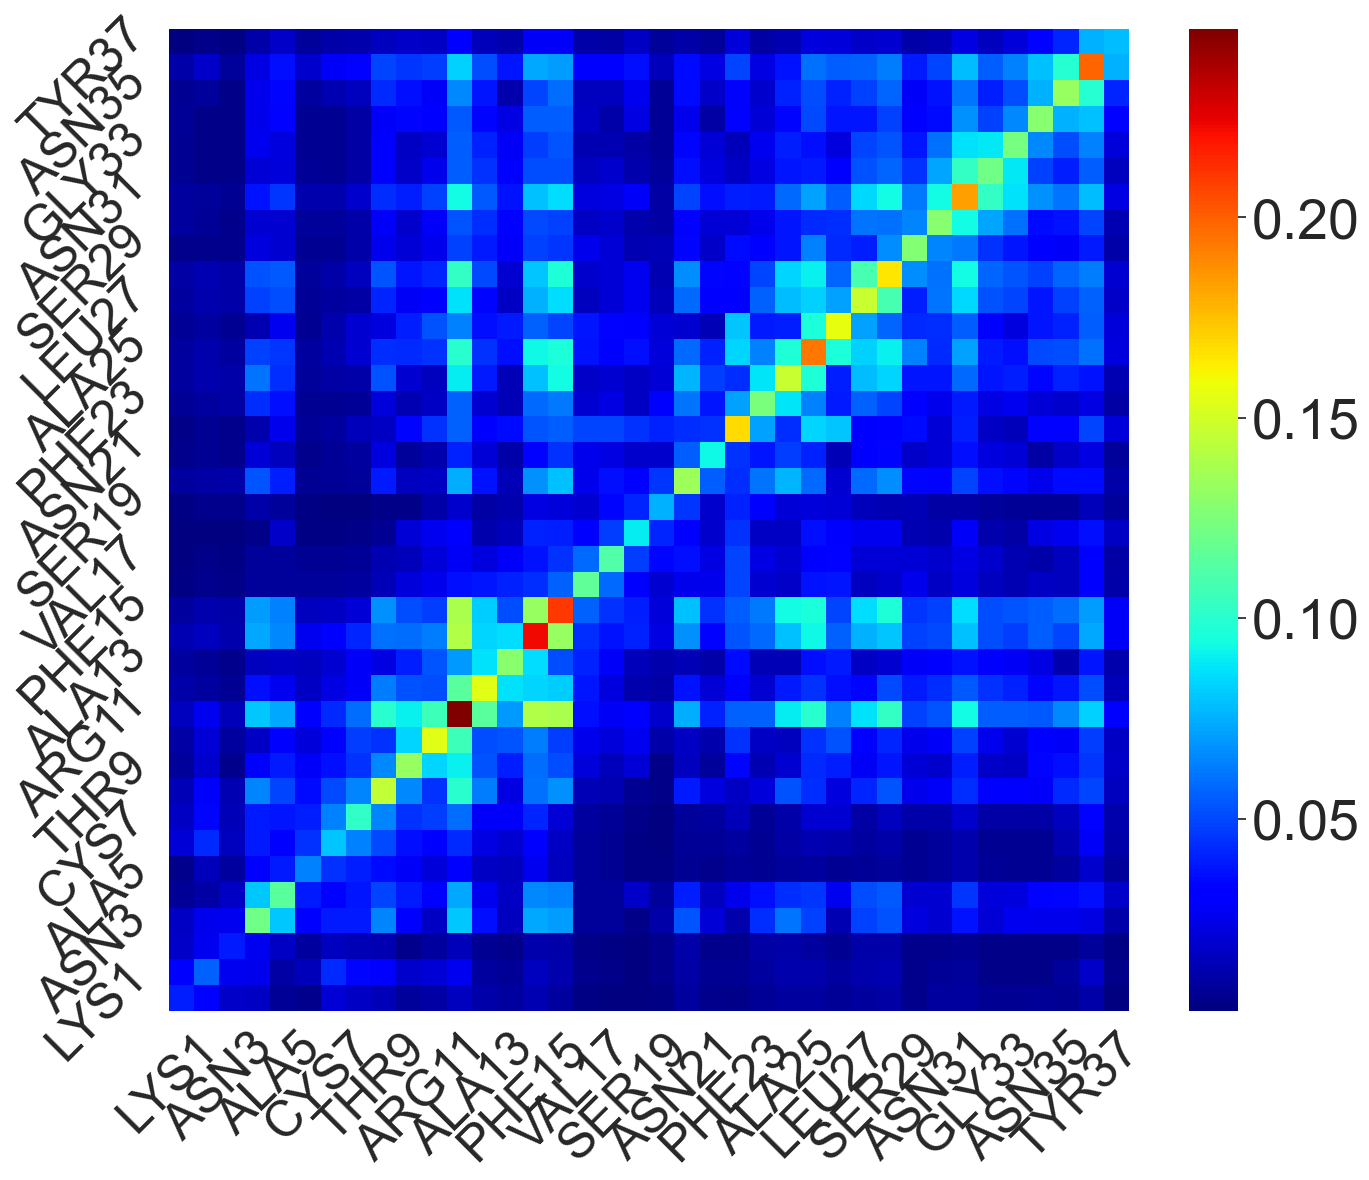

In [128]:
# Make distance map
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111)
im = sns.heatmap(final_map, cmap = 'jet', ax = ax)
ax.grid(which='both', alpha=0.5)
ax.tick_params(width = 3)
plt.xticks(range(38), sequence[:-1], rotation=45, size=36)
plt.yticks(range(0, 38), sequence[:-1], rotation=45, size=36)
cbar = im.collections[0].colorbar
cbar.ax.tick_params(labelsize=40)
# cbar.set_ticklabels(0, 0.45)
# cbar.mappable.set_clim(0,0.4)
ax.invert_yaxis()
plt.tight_layout()

plt.savefig('%s/dual_contact_map.png' % outdir)
plt.savefig('%s/dual_contact_map.pdf' % outdir)

# Circuit Topology Analysis 
- Run the circuit topology script, and then load in data to continue analysis. 

In [18]:
sequence_ol_s20g = ['K', 'C', 'N', 'T', 'A', 'T', 'C', 'A', 'T', 'Q', 'R', 'L', 'A', 'N', 'F', 'L', 'V', 'H', 'S', 'G', 'N', 'N', 'F', 'G', 'A', 'I', 'L', 'S', 'S', 'T', 'N', 'V', 'G', 'S', 'N', 'T', 'Y', '      NH$_2$']

In [19]:
from matplotlib.colors import ListedColormap
from cycler import cycler
from matplotlib import colormaps 
import pickle

# Define the number of shades in the gradient
num_grays = 8
# Create a list of distinct gray values
grays = np.linspace(0.0, 0.8, num_grays)
# Create a ListedColormap with distinct gray values
custom_pastel_gray_cmap = ListedColormap([(gray, gray, gray) for gray in grays])

# create color map and cycler for clusters 
max_num_clusters = 5
viridis = colormaps['viridis'].resampled(max_num_clusters)
default_cycler = cycler(color=viridis(range(max_num_clusters)))
viridis_hex = ["#3E0651","#3A487B", "#478F8A", "#7AC76D", "#F9E855"]

######## Clusters ########
with open(outdir+"/kmeans_cluster_indices.pkl", "rb") as f: 
    c_dict = pickle.load(f)

In [20]:
def calc_contact(trj, ligand_residue_index, residues=38):
    contact_pairs = np.zeros((residues, 2))

    for i in range(0, residues):
        contact_pairs[i] = [i, ligand_residue_index]
    contact = md.compute_contacts(trj, contact_pairs, scheme='closest-heavy')
    contacts = np.asarray(contact[0]).astype(float)
    cutoff = 0.6
    contact_matrix = np.where(contacts < cutoff, 1, 0)

    return contact_matrix

def create_pos_contact(trj, cutoff=0.5, ligand_residue_index=38): 
    """
    # get the indices of a positive contact given the trajectory 
    """
    contact_array = np.empty([1, ligand_residue_index])
    contact = calc_contact(trj, ligand_residue_index)
    contact_array = np.append(contact_array, contact, axis=0)
    contact_array = np.delete(contact_array, 0, 0)
    avg_contact = np.mean(contact_array, axis=1)
    pos_contact = np.where(avg_contact >= cutoff)[0]
    print("this is the population of the bound frames for the given cutoff:", len(pos_contact)/trj.n_frames)
    return pos_contact

In [21]:
def plt_box(xmin,xmax,ymin,ymax):
    plt.vlines(xmin, ymin, ymax, colors="k")
    plt.vlines (xmax, ymin, ymax, colors="k")
    plt.hlines(ymin, xmin, xmax, colors="k")
    plt.hlines(ymax, xmin, xmax, colors="k")
    return

In [22]:
def get_centroid(traj_basin): 
    """
    Get the centroid 
    :traj_basin: (mdtraj object) the trajectory of the basin 
    :ind_list: the list of indices that made that traj 
    """
    atom_indices = [a.index for a in traj_basin.topology.atoms if a.element.symbol != 'H']
    distances = np.empty((traj_basin.n_frames, traj_basin.n_frames))
    
    for i in range(traj_basin.n_frames):
        distances[i] = md.rmsd(traj_basin, traj_basin, i, atom_indices=atom_indices)

    beta = 1
    index = np.exp(-beta*distances / distances.std()).sum(axis=1).argmax()

    return int(index)


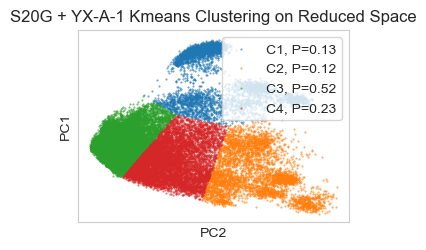

In [23]:
metric = np.load(outdir + "incPCs.npy" )

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(3.5,2.5))

lbl = "S20G + YX-A-1"
# plot by the cluster 
for i in range(len(c_dict.keys())):
    frame_ind = c_dict[i]
    x = metric[frame_ind][:,0]
    y = metric[frame_ind][:,1]
    ax.scatter(x,y, label='C%s' %
        str(i+1) + ", P=" + str(np.round(len(frame_ind)/int(metric.shape[0]), 2)), marker = ".", alpha=0.7, s=1)
    ax.set_title('%s Kmeans Clustering on Reduced Space'% lbl)
plt.ylabel("PC1")
plt.xlabel("PC2")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

In [24]:
fraction_assignments = []
n_cluster=4
circuit_matrix = np.load(outdir + "ctop_model.npy")

for i in range(n_cluster): #enumerate(axes.flat):
    fraction_assignment = []
    # index data for this cluster 
    tensor = circuit_matrix[c_dict[i],:].flatten()
    nonzero_idx = np.where(tensor!=0)[0]
    tensor = tensor[nonzero_idx]
    total_nonzero = nonzero_idx.size
    
    for i in range(1,8): 
        fraction_assignment.append(np.sum(np.where(tensor == i, 1, 0)/ total_nonzero)) # zero assignment not a contact
    print(np.sum(fraction_assignment))
    fraction_assignments.append(fraction_assignment)

KeyboardInterrupt: 

([<matplotlib.axis.XTick at 0x158987d00>,
 [Text(0.5, 0, 'Series'),
  Text(1.5, 0, 'Parallel'),
  Text(2.5, 0, 'Parallel-1'),
  Text(3.5, 0, 'Cross'),
  Text(4.5, 0, 'C. Parallel'),
  Text(5.5, 0, 'C. Parallel-1'),
  Text(6.5, 0, 'C. Series')])

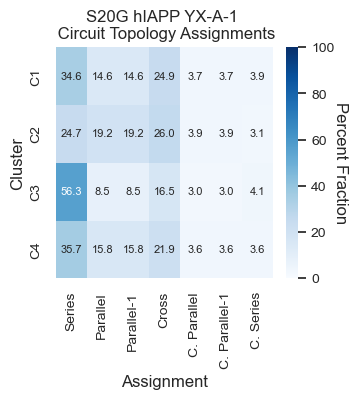

In [136]:
fig, ax = plt.subplots(figsize=(3.5,3))
heatmap = sns.heatmap(np.array(fraction_assignments)*100, cmap="Blues", annot=True, fmt="0.1f", ax=ax, annot_kws={"size": 8}, vmin=0.0, vmax=100.0)
# Customize colorbar tick sizes
cbar = heatmap.collections[0].colorbar  # Get the colorbar object
cbar.ax.tick_params(labelsize=10)  # Set the tick size
cbar.set_label("Percent Fraction", rotation=-90, labelpad=10)
# other details 
plt.title("S20G hIAPP YX-A-1 \n Circuit Topology Assignments")
plt.xlabel("Assignment")
plt.ylabel("Cluster") 
plt.yticks(np.arange(n_cluster) + 0.5, labels=["C" + str(i+1) for i in range(n_cluster)], fontsize=10)
plt.xticks(np.arange(0,7) +0.5, labels=["Series", "Parallel", "Parallel-1", "Cross", 
                                 "C. Parallel", "C. Parallel-1", "C. Series"], rotation=90, fontsize=10)

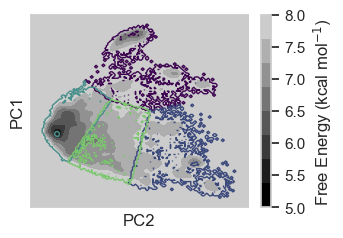

In [137]:

PCs = np.load(outdir+"/incPCs.npy")
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(3.5,2.5))

# Create free energy surface with an inverse boltzmann 
counts,xbins,ybins=np.histogram2d(PCs[:,1],PCs[:,0],bins=50,normed=True, range=[[np.min(PCs[:,1])-50, np.max(PCs[:,1])+50], [np.min(PCs[:,0])-50, np.max(PCs[:,0])+50]]) # LogNorm()
a = np.log(np.flipud(counts)+.000001)
T = 300
a = -(0.001987*T)*a

# Create a colored density map using ax.imshow
im = ax.imshow(a, interpolation='gaussian', extent=[ybins[0], ybins[-1], 
                                                    xbins[0], xbins[-1]], cmap=custom_pastel_gray_cmap, aspect='auto')
im.set_clim(5.0, 8.0)  # Adjust these values based on your data
# Add a colorbar to the plot
cbar = plt.colorbar(im, ax=ax, label='Free Energy (kcal mol$^{-1}$)')

# plot the outlines with a thicker line 
for i in range(len(c_dict.keys())):
        frame_ind = c_dict[i]
        x = PCs[frame_ind][:,0]
        y = PCs[frame_ind][:,1]
        
        # calculate the 2D density of the data given
        counts,xbins,ybins=np.histogram2d(x,y,bins=150,normed=True, range=[[np.min(PCs[:,0])-50, np.max(PCs[:,0])+50], [np.min(PCs[:,1])-50, np.max(PCs[:,1])+50]]) # LogNorm()
        # make the contour plot
        ax.contour(counts.transpose(),extent=[xbins.min(),xbins.max(), ybins.min(),ybins.max()],linewidths=1.0,colors=viridis_hex[i],
            linestyles='solid', levels=1)


# Add a colorbar to the plot
# cbar = plt.colorbar(contour_plot, ax=ax, label='Density')
# plt.plot(PCs[:,0], PCs[:,1])
plt.ylim(ybins.min(), ybins.max())
plt.xlim(xbins.min(), xbins.max())
plt.ylabel("PC1")
plt.xlabel("PC2")
plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.savefig(outdir + "iapp_s20g_yxa1_FES_on_PCs.pdf", dpi=400, bbox_inches="tight")

plt.show()

In [ ]:
# # compute SASA
# solv = md.shrake_rupley(trj, mode="residue")
# np.save(outdir+"/sasa.npy", solv)

In [25]:
def create_pos_contact_avg_contact(trj, cutoff=0.5, ligand_residue_index=38): 
    """
    # get the indices of a positive contact given the trajectory 
    """
    contact_array = np.empty([1, 38])
    contact = calc_contact(trj, ligand_residue_index)
    contact_array = np.append(contact_array, contact, axis=0)
    contact_array = np.delete(contact_array, 0, 0)
    num_res_contact = np.sum(contact_array, axis=1)
    pos_contact = np.where(np.mean(contact_array, axis=1) >= cutoff)[0]
    return pos_contact, num_res_contact

27.0
28.97761 59.297092 0.8075987332750587 2.685520201304545 0 29
28.97761 59.297092 0.8075987332750587 2.685520201304545 0 29
28.97761 59.297092 0.8075987332750587 2.685520201304545 0 29


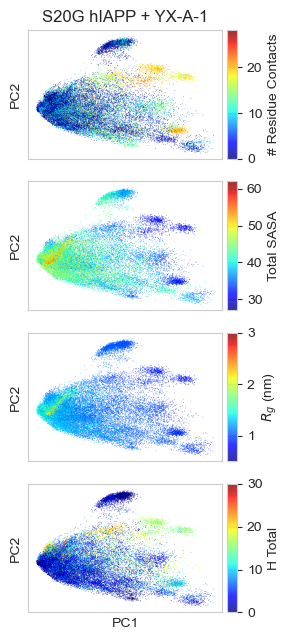

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable 
PCs = np.load(outdir+"/incPCs.npy")
bds = [[0,28], [27,62], [0.5,3.0], [0,30]]

# load in quantities 
Rg = np.load(outdir+"/Rg_total" + ".npy")
Sa = np.load(outdir+"/Sa_total" + ".npy")
H_tot = np.load(outdir+"/H_total" + ".npy")
solv_sum = np.sum(np.load(outdir+"/sasa.npy"), axis=1)

# labels 
cbar_lbl = ["# Residue Contacts", "Total SASA", "$R_g$ (nm)", "H Total"]

# create one plot to show all 4 quantities 
fig, axes = plt.subplots(4,1, figsize=(3,6.5), sharey=True, sharex=True)
ax = axes.flatten()

# # plot the outlines with a thicker line 
# create pos_contact 
pos_contact, res_num_contact = create_pos_contact_avg_contact(trj, cutoff=0.5)
scatt = ax[0].scatter(PCs[:,0],PCs[:,1], marker = ".", alpha=0.8, c=res_num_contact, cmap="jet", s=1, edgecolors="None", vmin=bds[0][0], vmax=bds[0][1])
print(res_num_contact.max())
ax[0].set_ylabel("PC2")
# Add color bar
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(scatt, cax=cax)
cbar.set_label(cbar_lbl[0],fontsize=10)  # Set your desired label
ax[0].grid(False)

# project onto the surface 
for k, var in enumerate([solv_sum, Rg, H_tot]): 
    print(solv_sum.min(), solv_sum.max(), Rg.min(), Rg.max(), H_tot.min(), H_tot.max())
    scatt = ax[k+1].scatter(PCs[:,0],PCs[:,1], marker = ".", alpha=0.8, c=var, cmap="jet", s=1, edgecolors="None", vmin=bds[k+1][0], vmax=bds[k+1][1])
    # ax.legend(loc='best', ncol=1)
    
    ax[k+1].set_ylabel("PC2")
    
    ax[k+1].grid(False)
    ax[k+1].set_xticks([])
    ax[k+1].set_yticks([])
    # Add color bar
    divider = make_axes_locatable(ax[k+1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(scatt, cax=cax)
    cbar.set_label(cbar_lbl[k+1],fontsize=10)  # Set your desired label
axes[0].set_title("S20G hIAPP + YX-A-1")
axes[-1].set_xlabel("PC1")
plt.tight_layout()
plt.savefig( outdir + "res_num_in_contact_project_SASA_Rg_H_total.png", dpi=400, bbox_inches="tight")
plt.show()

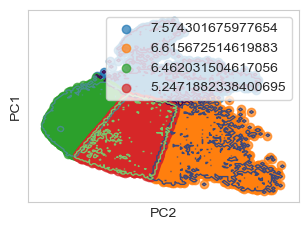

In [27]:

PCs = np.load(outdir+"/incPCs.npy")
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(3.5,2.5))

# plot the outlines with a thicker line 
for i in range(len(c_dict.keys())):
        frame_ind = c_dict[i]
        x = PCs[frame_ind][:,0]
        y = PCs[frame_ind][:,1]
        
        plt.scatter(x,y, label = str(np.average(H_tot[frame_ind])), alpha=0.7)
        # calculate the 2D density of the data given
        counts,xbins,ybins=np.histogram2d(x,y,bins=150,normed=True, range=[[np.min(PCs[:,0])-50, np.max(PCs[:,0])+50], [np.min(PCs[:,1])-50, np.max(PCs[:,1])+50]]) # LogNorm()
        # make the contour plot
        ax.contour(counts.transpose(),extent=[xbins.min(),xbins.max(), ybins.min(),ybins.max()],linewidths=1.0,colors=viridis_hex[i],
            linestyles='solid', levels=1)



plt.ylim(ybins.min(), ybins.max())
plt.xlim(xbins.min(), xbins.max())
plt.ylabel("PC1")
plt.xlabel("PC2")
plt.legend()
plt.xticks([])
plt.yticks([])
plt.grid(False)

In [28]:
pos_contact = create_pos_contact(trj, cutoff=0.5)
pos_contact_all_bf = create_pos_contact(trj, cutoff=0.01)

this is the population of the bound frames for the given cutoff: 0.056452299225553886
this is the population of the bound frames for the given cutoff: 0.6279254489234348


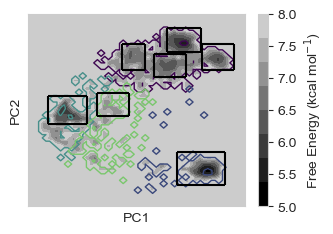

In [29]:
# load in the correct c_dict and the correct PCs
# get pcs 
PCs_old = np.load(outdir+"/incPCs.npy")

# only care about the PCs in contact
frame_range = PCs_old.shape[0]
PCs = PCs_old[np.intersect1d(pos_contact,np.arange(0,frame_range))]

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(3.5,2.5))
counts,xbins,ybins=np.histogram2d(PCs[:,1],PCs[:,0],bins=50,normed=True, range=[[np.min(PCs[:,1])-50, np.max(PCs[:,1])+50], [np.min(PCs[:,0])-50, np.max(PCs[:,0])+50]]) # LogNorm()
a = np.log(np.flipud(counts)+.000001)
T = 300
a = -(0.001987*T)*a

# Create a colored density map using ax.imshow
im = ax.imshow(a, interpolation='gaussian', extent=[ybins[0], ybins[-1], 
                                                    xbins[0], xbins[-1]], cmap=custom_pastel_gray_cmap, aspect='auto') 

im.set_clim(5.0, 8.0)  # Adjust these values based on your data
# Add a colorbar to the plot
cbar = plt.colorbar(im, ax=ax, label='Free Energy (kcal mol$^{-1}$)')

# plot the outlines with a thicker line 

for i in range(len(c_dict.keys())):
        frame_ind = c_dict[i]
        in_contact = np.intersect1d(pos_contact,frame_ind)
        x = PCs_old[in_contact][:,0]
        y = PCs_old[in_contact][:,1]
        # ax.scatter(x,y, s=1, marker=".", c=viridis_hex[i])

        # calculate the 2D density of the data given
        counts,xbins,ybins=np.histogram2d(x,y,bins=60,normed=True, range=[[np.min(PCs[:,0])-50, np.max(PCs[:,0])+50], [np.min(PCs[:,1])-50, np.max(PCs[:,1])+50]]) # LogNorm()
        # make the contour plot
        ax.contour(counts.transpose(),extent=[xbins.min(),xbins.max(), ybins.min(),ybins.max()],linewidths=1.0,colors=viridis_hex[i],
            linestyles='solid', levels=1)

plt.ylim(ybins.min(), ybins.max())
plt.xlim(xbins.min(), xbins.max())

plt.ylabel("PC2")
plt.xlabel("PC1")
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.savefig(outdir + "iapp_s20g_yxa1_FES_on_PCs_0.5_in_contact.png", dpi=400, bbox_inches="tight")

# bound poses

# bin for cluster 1 
plt_box(220, 325, 205, 280)
plt_box(330, 430, 150, 230)
plt_box(180, 280, 130, 200)
plt_box(80, 150, 150, 230)

# bins for cluster 2 
plt_box(250, 400, -202, -102)

# bins for cluster 3  
plt_box(-150, -30, -15, 70)

# bins for cluster 4 
plt_box(0, 100, 10, 80)

plt.savefig(outdir + "iapp_s20g_yxa1_FES_on_PCs_0.5_w_bounds_in_contact.png", dpi=400, bbox_inches="tight")

plt.show()

Save the corresponding trajectories

In [30]:
# binned bounds 
bounds = [
[[220, 325, 205, 280], [330, 430, 150, 230], [180, 280, 130, 200], [80, 150, 150, 230]], 
[[250, 400, -202, -102]],
[[-150, -30, -15, 70]],
[[0, 100, 10, 80]]
]
# the population that is reported here is that over the total amount of bound frames. 
populations = []

# loop through the clusters
for c in range(len(bounds)):
    # get all the frames 
    frame_ind = c_dict[c]
    in_contact = np.intersect1d(pos_contact,frame_ind)
    print("cluster, ", c, len(in_contact))
    
    if len(in_contact) < 1: 
        continue
    # in contact and cluster 
    c_x = PCs_old[:,0]
    c_y = PCs_old[:,1]
    
    # loop through the number of bins in each cluster
    for n, bound in enumerate(bounds[c]): 
        # unpack bound 
        xmin, xmax, ymin, ymax = bound

        # get the pos contact within the bounds 
        x_bound = np.intersect1d(np.where(c_x > xmin)[0], np.where(c_x < xmax)[0])
        y_bound = np.intersect1d(np.where(c_y > ymin)[0], np.where(c_y < ymax)[0])
        bf_in_bounds = np.intersect1d(x_bound, y_bound)
        bf_in_bounds = np.intersect1d(in_contact, bf_in_bounds)

        if len(bf_in_bounds) < 1: 
            continue

        # save the files 
        psystem = "iapp_s20g_yxa1"
        c_file = outdir + psystem + "_0.5_bf_centroid_c" + str(c+1) + "_b"+ str(n)+".gro"
        trj_file = outdir + psystem+ "_0.5_bf_c" + str(c+1)+ "_b"+ str(n) + ".xtc"

        # get only bf and compute centroid
        temp = trj.slice(bf_in_bounds)
        temp2 = temp.atom_slice(trj.topology.select("residue 1 to 38"))
        c_i = get_centroid(temp2)

        # save the files 
        temp.slice(c_i).save_gro(c_file)
        temp.save_xtc(trj_file)

        populations.append((len(bf_in_bounds)/ len(pos_contact))*100)
print(populations)

cluster,  0 957
cluster,  1 476
cluster,  2 395
cluster,  3 162
[15.07537688442211, 6.180904522613066, 8.693467336683417, 5.577889447236181, 22.311557788944725, 14.170854271356784, 2.21105527638191]


NameError: name 'hres_renum' is not defined

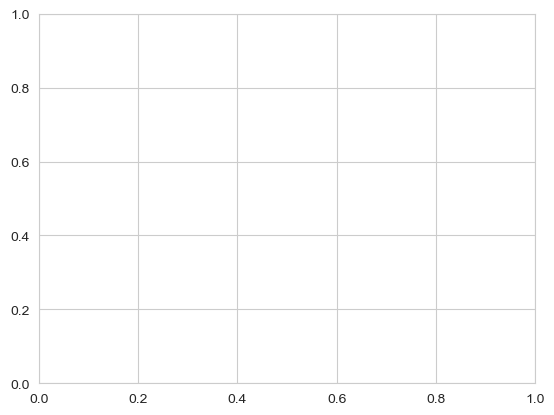

In [34]:
# compute the avg contacts 
def contact_arr_avg(trj, ligand_residue_index=38, residues=38): 
    """
    # get the indices of a positive contact given the trajectory 
    """
    contact_array = np.empty([1, residues])
    contact = calc_contact(trj, ligand_residue_index)
    contact_array = np.append(contact_array, contact, axis=0)
    contact_array = np.delete(contact_array, 0, 0)
    avg_contact = np.mean(contact_array, axis=0)
    return avg_contact

avg_filter_contact = []
fig, ax = plt.subplots(1,1)
for c in range(len(bounds)):
    # reload the systems that were just saved 
    for n, bound in enumerate(bounds[c]): 
        if len(bound) < 1: 
            continue 
        c_file = outdir + psystem + "_0.5_bf_centroid_c" + str(c+1) + "_b"+ str(n)+".gro"
        trj_file = outdir + psystem+ "_0.5_bf_c" + str(c+1)+ "_b"+ str(n) + ".xtc"
        trj_c = md.load(trj_file, top=c_file)
        avg_contact = contact_arr_avg(trj_c)
        plt.plot(hres_renum, avg_contact, label =str(c+1) + "_b"+ str(n))
        avg_filter_contact.append(avg_contact)
plt.show()

In [38]:
from matplotlib.cm import get_cmap
from matplotlib.patheffects import withStroke

# add color 
def add_color_to_string(s, values, vmin=None, vmax=None, cmap_name='viridis',fname=None):
    if vmin is None:
        vmin = min(values)
    if vmax is None:
        vmax = max(values)
    cmap = get_cmap(cmap_name)

    fig, ax = plt.subplots(figsize=(len(s)*0.5, 1))
    ax.axis('off')

    counter = 0 
    x = 0
    for char, value in zip(s, values):
        norm_value = (value - vmin) / (vmax - vmin)
        color = cmap(norm_value)
        
        # text = ax.text(x, 0.5, char, color=color, fontsize=12, ha='left', va='center', transform=ax.transAxes)
        # text.set_path_effects([withStroke(linewidth=0.7, foreground='black')])
        
        if counter >= 20: 
            if counter == 20: 
                x = 0
            text = ax.text(x, 0.0, char, color=color, fontsize=14, ha='left', va='center', transform=ax.transAxes)
            text.set_path_effects([withStroke(linewidth=0.7, foreground='black')])
        else: 
            text = ax.text(x, 0.5, char, color=color, fontsize=14, ha='left', va='center', transform=ax.transAxes)
            text.set_path_effects([withStroke(linewidth=0.7, foreground='black')])

        x += 0.01
        counter +=1

    plt.savefig(fname, dpi=400)
    plt.show()

In [36]:
def make_chimera_prot_contact_file(contact_probability, traj_dir, psystem, c="-1", res_num=38): 
    # calculate the ligand centroid, with all its atoms 

    # get atom labels 
    labels = np.arange(1,res_num+1)
    file_path = traj_dir + psystem +".prot.chimera.contact."+c+ ".txt"

    # automated file writing for each atom 
    with open(file_path, "w") as file:
        file.write("attribute: contact_all \n")
        file.write("match mode: 1-to-1 \n")
        file.write("recipient: residues \n")

        for n in labels:
            # add residue index
            file.write("\t"+":" +str(n) + "\t" + str(np.round(contact_probability[n-1],3)) + "\n")
    return

/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_917/1431898154.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap_name)


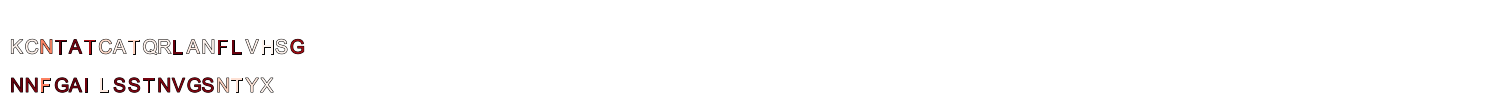

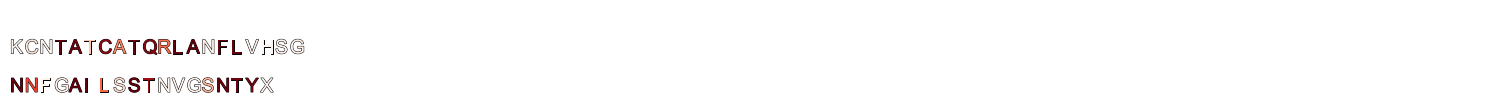

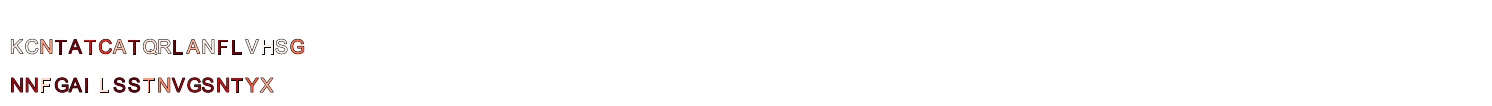

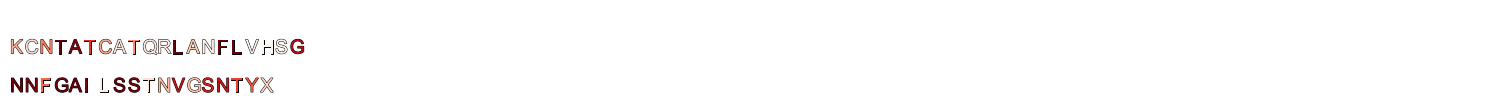

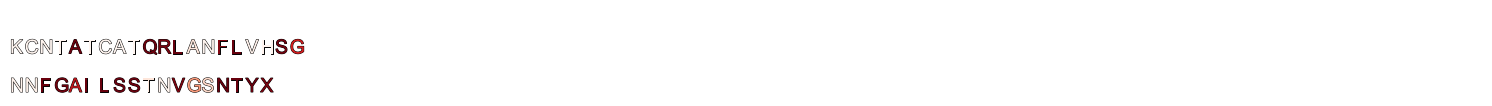

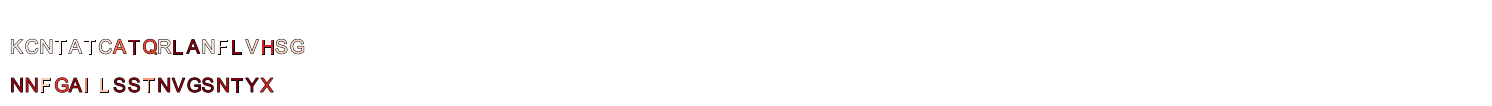

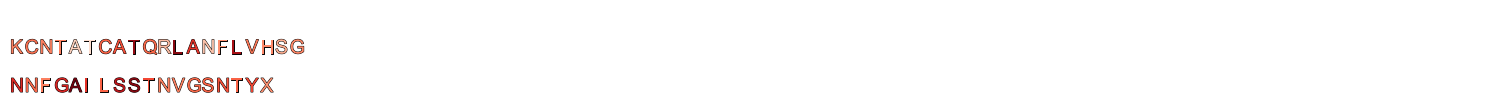

In [39]:
s20g_seq_str_ol = "KCNTATCATQRLANFLVHSGNNFGAILSSTNVGSNTYX"
for c in range(len(bounds)):
    for n, bound in enumerate(bounds[c]): 
        if len(bound) < 1: 
            continue 
        
        c_file = outdir + psystem + "_0.5_bf_centroid_c" + str(c+1) + "_b"+ str(n)+".gro"
        trj_file = outdir + psystem+ "_0.5_bf_c" + str(c+1)+ "_b"+ str(n) + ".xtc"
        trj_c = md.load(trj_file, top=c_file)
        avg_contact = contact_arr_avg(trj_c)
        
        trj_c = md.load(c_file)
        # save pdb so better visualize with chimera with cystine bond 
        trj_c.save_pdb(outdir + psystem + "_0.5_bf_centroid_c" + str(c+1) + "_b"+ str(n)+".pdb")
        make_chimera_prot_contact_file(avg_contact, outdir, psystem, c=str(c+1)+ "_b"+ str(n))
        add_color_to_string(s20g_seq_str_ol, avg_contact, cmap_name="Reds", vmin=0, vmax=1.0, fname= outdir + psystem +"_bf_c" + str(c+1)+ "_b"+ str(n) +"seq_colored_2lines.pdf")

        del trj_c

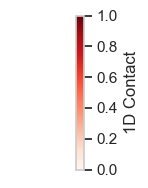

In [149]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
def create_colorbar(vmin, vmax, cmap_name='viridis', fname=None):
    fig, ax = plt.subplots(figsize=(1,2))
    ax.axis('off')

    norm = Normalize(vmin=vmin, vmax=vmax)
    sm = ScalarMappable(norm=norm, cmap=cmap_name)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('1D Contact', fontsize=12)
    # plt.tight_layout()
    plt.savefig(fname, dpi=400,  bbox_inches="tight")
    plt.show()

# Example usage
create_colorbar(vmin=0, vmax=1.0, cmap_name='Reds', fname=outdir + psystem + "_seq_colorbar.png")

### By Cluster Analysis

Text(0.5, 0.98, 'Ligand contact')

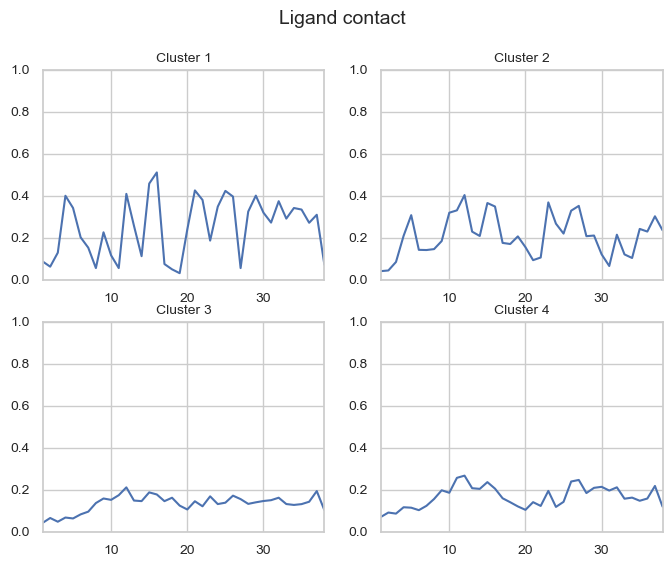

In [150]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
n_cluster = 4 
for i in range(0, n_cluster):
    frame_ind = c_dict[i]
    ax[int(i/2), i % 2].plot(hres_renum, np.average(contact_matrix[frame_ind], axis=0))
    ax[int(i/2), i % 2].set_title('Cluster %s' % str(i+1), size=10)
    ax[int(i/2), i % 2].tick_params(axis='both', labelsize=10)
    ax[int(i/2), i % 2].set_xlim(1, 38)
    ax[int(i/2), i % 2].set_ylim(0, 1.0)
fig.suptitle('Ligand contact', size = 14)

Text(0.5, 0.98, 'Ligand interaction')

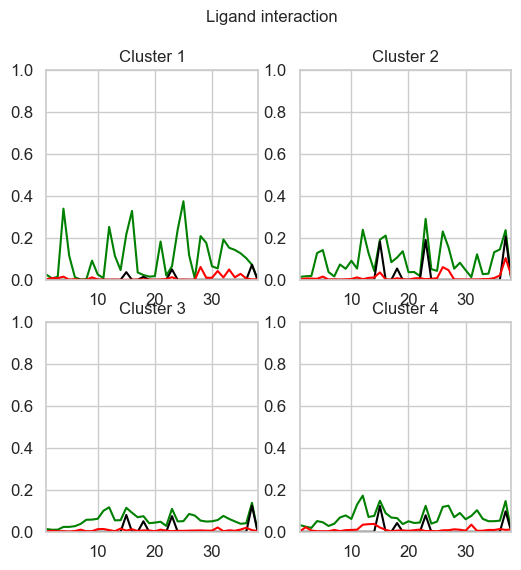

In [151]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))

for i in range(0, n_cluster):
    frame_ind = c_dict[i]
    ax[int(i/2), i % 2].plot(hres_renum, np.average(Hphob_res_contacts[frame_ind], axis=0), color = 'green')
    ax[int(i/2), i % 2].plot(hres_renum, np.average(aromatic_stacking_contacts[frame_ind], axis=0), color = 'black')
    ax[int(i/2), i % 2].plot(hres_renum, np.average(HB_Total[frame_ind], axis=0), color = 'red')    
    ax[int(i/2), i % 2].set_title('Cluster %s' % str(i+1), size=12)
    ax[int(i/2), i % 2].tick_params(axis='both', labelsize=12)
    ax[int(i/2), i % 2].set_xlim(1, 38)
    ax[int(i/2), i % 2].set_ylim(0, 1.0)
fig.suptitle('Ligand interaction', size = 12)

In [152]:
def make_dual_map(trj, prot_len=38, ligand_idx = 38):
    contact_maps = []
    for i in range(0, prot_len):
        # print(i)
        contact_map = []
        for j in range(0, prot_len):
            dist1 = md.compute_contacts(trj, [[i, ligand_idx]], scheme='closest-heavy')
            dist2 = md.compute_contacts(trj, [[j, ligand_idx]], scheme='closest-heavy')
            array1 = np.asarray(dist1[0]).astype(float)
            array2 = np.asarray(dist2[0]).astype(float)
            contact1 = np.where(array1 < 0.5, 1, 0)
            contact2 = np.where(array2 < 0.5, 1, 0)
            sum = contact1 + contact2
            contact = np.where(sum == 2, 1, 0)
            contacts = np.average(contact)
            contact_map.append(contacts)
        contact_maps.append(contact_map)
    final_map = np.asarray(contact_maps).astype(float)
    return final_map

In [153]:
dual_contact_maps = []
prot_len=38 
for i in range(len(c_dict.keys())):
    frame_ind = c_dict[i]
    temptrj = trj.slice(frame_ind)
    # dual contact map 
    dual_contact_map = make_dual_map(temptrj, prot_len-1)
    dual_contact_maps.append(dual_contact_map)

The population of cluster 1 is 0.12694675328359478
The population of cluster 2 is 0.12127315537147883
The population of cluster 3 is 0.5222546878102748
The population of cluster 4 is 0.2295254035346515


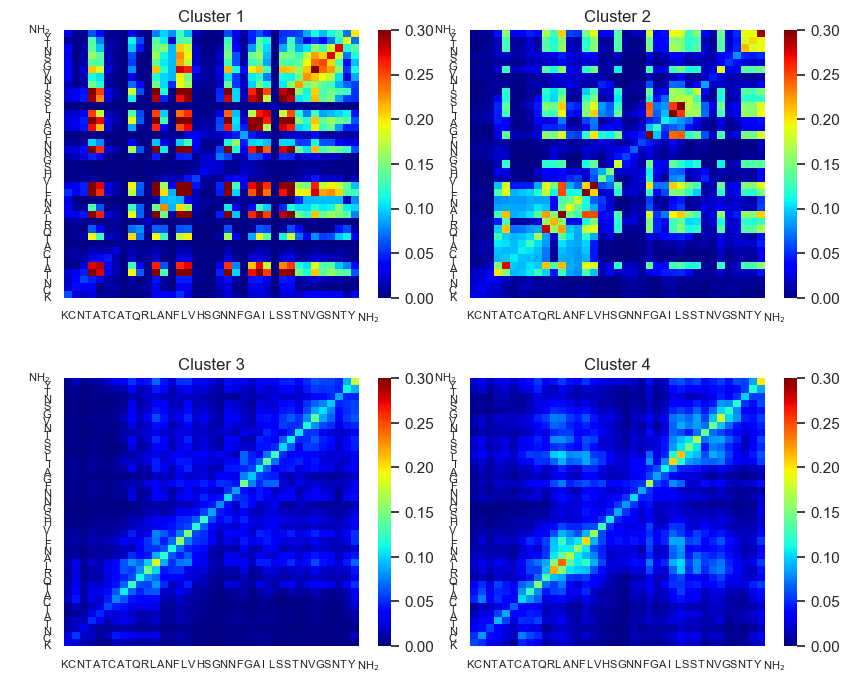

In [154]:
num_rows = 2
num_cols = 2

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))

# Loop through the axes and images to populate the subplots
for i, (ax, d_map) in enumerate(zip(axes.flat, dual_contact_maps)):
    im = sns.heatmap(d_map, cmap='jet', ax=ax, vmin=0.0, vmax = 0.3)
    ax.grid(which='both', alpha=0.5)
    ax.set_xticks(range(0,38), sequence_ol_s20g, rotation=0, size=8)
    ax.set_yticks(range(0,38), sequence_ol_s20g, rotation=0, size=8)
    ax.invert_yaxis()
    print("The population of cluster "+str(i+1)+" is", len(c_dict[i])/trj.n_frames)
    # Add a title to the subplot
    ax.set_title(f'Cluster {i+1}', fontsize=12)  # Customize title as needed

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.3)  # Increased vertical spacing

# Show the plot
plt.show()

In [155]:
def contact_map_avg(trj, prot_len, cutoff = 1.2):
    """
    This is almost the same as the above function but returns less
    create average contact maps and distance maps for entire trajectory one-hot encoded 
    :trj: (mdtraj object) trajectory 
    :prot_len: (int) the number of residues 
    returns: a signle contact map
    """     
    contact_maps = []
    contact_distances = []
    
    for i in range(0,prot_len):
        contact_map = []
        contact_distance = []

        for j in range(0,prot_len):
            if i == j:
                contacts = 0
            else:
                dist = md.compute_contacts(trj, [[i, j]])
                array = np.asarray(dist[0]).astype(float)
                distance = np.average(array)
                contact_distance.append(distance)
                contact = np.where(array < cutoff, 1, 0)
                contacts = np.average(contact)
            contact_map.append(contacts)
        contact_maps.append(contact_map)
        contact_distances.append(contact_distance)
    final_map = np.asarray(contact_maps).astype(float)
    final_distance = np.asarray(contact_distances).astype(float)

    return final_map, final_distance

In [156]:
# check contact maps 
contact_maps = []
distance_maps = []
populations = []

# trjs = []
for i in range(len(c_dict.keys())):
    frame_ind = c_dict[i]
    temptrj = trj.slice(frame_ind)
    print(temptrj.n_frames)
    populations.append(np.round(temptrj.n_frames/trj.n_frames, 2))
    # trjs.append(trj)
    # contact map 
    final_map, final_distance = contact_map_avg(temptrj, prot_len, cutoff=0.8)
    contact_maps.append(final_map)
    distance_maps.append(final_distance)

4475
4275
18410
8091


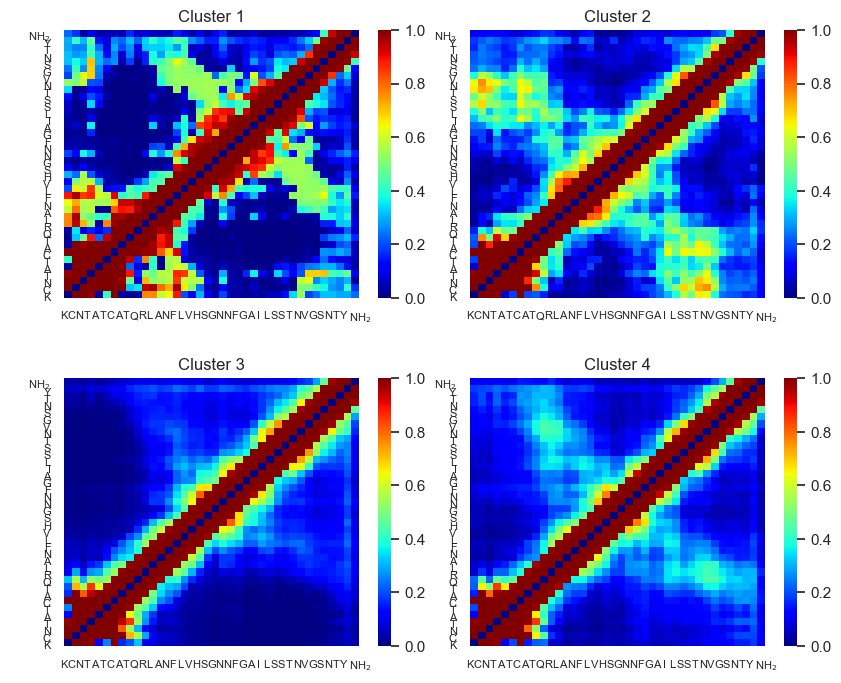

In [157]:
num_rows = 2
num_cols = 2

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))

# Loop through the axes and images to populate the subplots
for i, (ax, c_map) in enumerate(zip(axes.flat, contact_maps)):
    im = sns.heatmap(c_map, cmap='jet', ax=ax)
    ax.grid(which='both', alpha=0.5)
    ax.set_xticks(range(0,38), sequence_ol_s20g, rotation=0, size=8)
    ax.set_yticks(range(0,38), sequence_ol_s20g, rotation=0, size=8)
    ax.invert_yaxis()
    
    # Add a title to the subplot
    ax.set_title(f'Cluster {i+1}', fontsize=12)  # Customize title as needed

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.3)  # Increased vertical spacing

# Show the plot
plt.show()

/Users/f006j60/git/hIAPP_monomer_simulations/scripts/pca_tools.py:58: RuntimeWarning: invalid value encountered in divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]


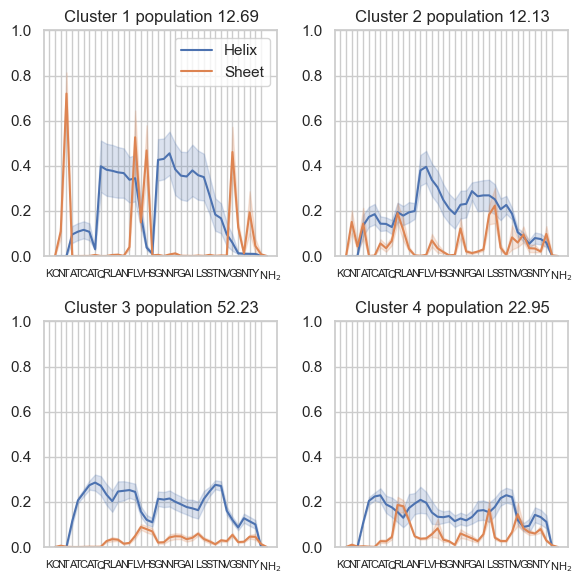

In [158]:
n_cluster = 4
# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 6))

# Loop through the axes and images to populate the subplots
for i, ax in enumerate(axes.flat):
    if i > n_cluster-1: 
        break
    H1_H, H1_E = dssp_convert(dsspH1[c_dict[i]])

    ax.plot(hres_renum, H1_H[:, 0], label='Helix', color="C0")
    ax.fill_between(hres_renum, H1_H[:, 0]-H1_H[:, 1],
                     H1_H[:, 0]+H1_H[:, 1], alpha=0.2, color="C0")
    
    ax.plot(hres_renum, H1_E[:, 0], label='Sheet', color="C1")
    ax.fill_between(hres_renum, H1_E[:, 0]-H1_E[:, 1],
                     H1_E[:, 0]+H1_E[:, 1], alpha=0.2, color="C1")
    
    ax.set_xticks(range(38), sequence_ol_s20g, fontsize=8)
    ax.set_ylim(0,1.0)
    # Add a title to the subplotp.
    ax.set_title(f'Cluster {i+1} population ' + str(np.round((c_dict[i].size/trj.n_frames * 100), decimals=2)))  # Customize title as needed

# add legend only to last cluster
axes[0,0].legend(loc = "upper right")
# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.3)  # Increased vertical spacing
plt.tight_layout()
# Show the plot
plt.show()

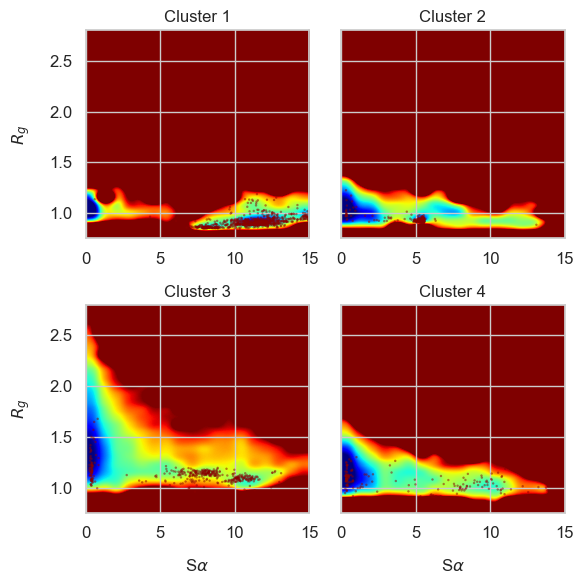

In [159]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 6), sharey=True)
Rg = np.load(outdir+"/Rg_total" + ".npy")
Sa = np.load(outdir+"/Sa_total" + ".npy")

for i, ax in enumerate(axes.flat):
    if i > n_cluster-1: 
        break
    
    frame_ind = c_dict[i]

    a, xedges, yedges = np.histogram2d(Rg[frame_ind], Sa[frame_ind], 30, [
        [0.5, 2.8], [0, 25.0]], density=True, weights=None)
    a = np.log(np.flipud(a)+.000001)
    T = 300
    a = -(0.001987*T)*a

    in_contact = np.intersect1d(pos_contact,frame_ind)
    ax.scatter(Sa[in_contact], Rg[in_contact], s=3, c="darkred", alpha=0.5, marker="o",edgecolors="None")

    im = ax.imshow(a, interpolation='gaussian', extent=[
        yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap="jet", aspect='auto')
    im.set_clim(0.1, 3)
    ax.set_xlim(0, 15)
    ax.set_ylim(0.75,2.8)
    if i % 2 <1: 
        ax.set_ylabel("$R_g$", size=12, labelpad=12)
    if i > 1: 
        ax.set_xlabel(r'S$\alpha$', size=12, labelpad=12)
    ax.set_title('Cluster %s' % str(i+1), size=12)
    ax.tick_params(axis='both', labelsize=12)
plt.tight_layout()

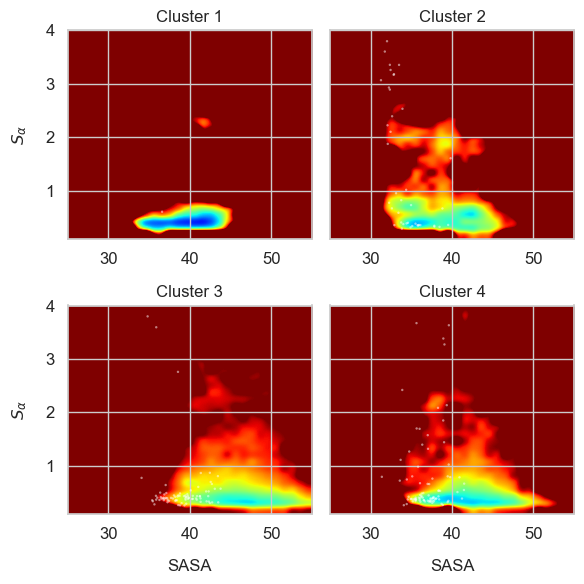

In [160]:
num_rows = 2
num_cols = 2
n_cluster = 4
n=0
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 6), sharey=True)
Rg = np.load(outdir+"/Rg_total" + ".npy")
solv_sum = np.sum(np.load(outdir+"/sasa.npy"), axis=1)

for i, ax in enumerate(axes.flat):
    if i > n_cluster-1: 
        break
    
    frame_ind = c_dict[i]

    a, xedges, yedges = np.histogram2d(Sa[frame_ind], solv_sum[frame_ind], 30, [
        [0.1, 4], [25, 55.0]], density=True, weights=None)
    a = np.log(np.flipud(a)+.000001)
    T = 300
    a = -(0.001987*T)*a

    in_contact = np.intersect1d(pos_contact,frame_ind)
    ax.scatter(solv_sum[in_contact], Sa[in_contact], s=3, c="white", alpha=0.5, marker="o",edgecolors="None")

    im = ax.imshow(a, interpolation='gaussian', extent=[
        yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap="jet", aspect='auto')
    im.set_clim(0.1, 3)
    ax.set_xlim(25, 55)
    ax.set_ylim(0.1,4)
    if i % 2 <1: 
        ax.set_ylabel("$S_{\\alpha}$", size=12, labelpad=12)
    if i > 1: 
        ax.set_xlabel(r'SASA', size=12, labelpad=12)
    ax.set_title('Cluster %s' % str(i+1), size=12)
    ax.tick_params(axis='both', labelsize=12)
plt.tight_layout()

### Calculate Ligand Probabilities 

In [8]:
def make_chimera_lig_contact_file(contact_probability, traj, traj_dir, psystem, c=-1, lig_resid=38): 
    # calculate the ligand centroid, with all its atoms 
    temptrj_lig = traj.atom_slice(traj.top.select("resid "+str(lig_resid)))
    lig_centroid = temptrj_lig.slice(get_centroid(temptrj_lig))
    lig_centroid.save_gro(traj_dir + "/ct_"+ psystem +"_5Acutoff_centroid_C"+str(c+1) + "_" +".gro")

    # get atom labels 
    labels = np.array([str(atom).split("-")[1] for atom in lig_centroid.top.atoms])
    file_path = outdir + psystem +".zip.lig.5Acutoff.contacts.all."+"c"+str(c+1)+ ".txt"

    # automated file writing for each atom 
    with open(file_path, "w") as file:
        file.write("attribute: contact_all \n")
        file.write("match mode: 1-to-1 \n")
        file.write("recipient: atoms \n")

        for n in range(len(labels)):
            # add residue index
            file.write("\t"+":39@" + str(labels[n]) + "\t" + str(np.round(contact_probability[n],3)) + "\n")
    return

def ligand_contact_probability(traj, lig_resid = 38, prot_start = 0, prot_end = 37): 
    # create queries for 
    lig_atoms = traj.top.select("resid " + str(lig_resid))
    prot_atoms = traj.top.select("resid " + str(prot_start) + " to " + str(prot_end))
    lig_contact_probabilities = []

    for atom in lig_atoms: 
        lig_contacts = md.compute_neighbors(traj, cutoff=0.5, query_indices=[atom], haystack_indices=prot_atoms, periodic=True)
        lig_contacts = np.array([x.size for x in lig_contacts])
        lig_contacts = np.where(lig_contacts > 0 , 1, 0)
        lig_prob = np.sum(lig_contacts)/ traj.n_frames
        lig_contact_probabilities.append(lig_prob)

    return lig_contact_probabilities

In [10]:
# compute contacts and get chimera attribute file for all 
psystem = "iapp_s20g_yxa1"
contact_probability = ligand_contact_probability(trj)
np.save(outdir+psystem+"_ligand_contact_array" + ".dat", contact_probability)        

# map onto chimera ligands
make_chimera_lig_contact_file(contact_probability, trj, outdir, psystem, c=-1, lig_resid=38)

In [162]:
for c in range(len(bounds)):
    for n, bound in enumerate(bounds[c]): 
        if len(bound) < 1: 
            continue 
        
        c_file = outdir + psystem + "_0.5_bf_centroid_c" + str(c+1) + "_b"+ str(n)+".gro"
        trj_file = outdir + psystem+ "_0.5_bf_c" + str(c+1)+ "_b"+ str(n) + ".xtc"
        trj_c = md.load(trj_file, top=c_file)

        # compute contacts 
        contact_probability = ligand_contact_probability(trj_c)
        np.save(outdir+psystem+"_ligand_contact_array" + ".dat", contact_probability)        

        # map onto chimera ligands
        make_chimera_lig_contact_file(contact_probability, trj_c, outdir, psystem + "_"+str(n), c=c, lig_resid=38)